# prep

In [1]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import numpy as np
from numpy import dot
from numpy.linalg import norm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import scipy.stats as stats
from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm
from IPython.display import clear_output
import os
import pickle

%load_ext autoreload
%autoreload 2

In [3]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    # repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
    repo_dir = r'C:\Users\ll357\Documents\inter/'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [4]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LM = meta.copy()
meta_LM.tail()

area
LM    22
Name: count, dtype: int64 22


mouse    date area  depth  num  cellpose_seg manual_seg paradigm gcamp  \
17   1373  230302   LM  200.0  003           1.0        NaN  grating    6s   
18   1373  230302   LM  150.0  004           1.0        NaN  grating    6s   
19   1381  230307   LM  200.0  002           1.0        NaN  grating    6s   
20   1381  230307   LM  200.0  003           1.0        NaN  grating    6s   
21   1381  230307   LM  150.0  004           1.0        NaN  grating    6s   

    AWS                                             note  
17  NaN  suspected not LM? Too many (74) well fit cells?  
18  NaN                                              NaN  
19  NaN                                              NaN  
20  NaN                                              NaN  
21  NaN                                              NaN

In [5]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

area
V1    6
Name: count, dtype: int64 6


mouse    date area  depth  num  cellpose_seg manual_seg paradigm gcamp  \
0   1323  200720   V1  200.0  003           NaN       True  grating    6s   
1   1324  200728   V1  200.0  003           NaN       True  grating    6s   
2   1322  200803   V1  200.0  002           NaN       True  grating    6s   
3   1328  201015   V1  200.0  004           NaN       True  grating    6s   
4   1329  201209   V1  200.0  002           NaN       True  grating    6s   
5   1337  210120   V1  150.0  003           1.0        NaN  grating    6s   

   AWS note  
0  1.0  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  1.0  NaN  
4  NaN  NaN  
5  NaN  NaN

In [6]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LI = meta.copy()
meta_LI

area
LI    18
Name: count, dtype: int64 18


mouse    date area  depth  num  cellpose_seg manual_seg paradigm gcamp  \
0    1323  200723   LI  200.0  003           NaN       True  grating    6s   
1    1322  200806   LI  200.0  003           NaN       True  grating    6s   
2    1328  201202   LI  200.0  003           NaN       True  grating    6s   
3    1328  201202   LI  150.0  004           NaN       True  grating    6s   
4    1329  210113   LI  200.0  004           NaN       True  grating    6s   
5    1329  210113   LI  150.0  006           NaN       True  grating    6s   
6    1337  210203   LI  200.0  003           NaN       True  grating    6s   
7    1337  210203   LI  150.0  004           NaN       True  grating    6s   
8    1339  210930   LI  200.0  002           NaN       True  grating    6s   
9    1339  210930   LI  150.0  003           NaN       True  grating    6s   
10   1350  211028   LI  200.0  002           NaN       True  grating    6s   
11   1350  211028   LI  150.0  003           NaN       True  grating    6s   
12   1380  230110   LI  200.0  002           1.0       True  grating    6s   
13   1380  230110   LI  150.0  003           1.0       True  grating    6s   
14   1373  230228   LI  200.0  002           1.0        NaN  grating    6s   
15   1373  230228   LI  150.0  003           1.0        NaN  grating    6s   
16   1381  230309   LI  200.0  002           1.0       True  grating    6s   
17   1381  230309   LI  150.0  003           1.0       True  grating    6s   

    AWS                                    note  
0   1.0                                     NaN  
1   1.0                                     NaN  
2   1.0  terrible find_ca_latency_ca_window.jpg  
3   1.0  terrible find_ca_latency_ca_window.jpg  
4   NaN                                     NaN  
5   NaN  terrible find_ca_latency_ca_window.jpg  
6   NaN                                     NaN  
7   NaN                                     NaN  
8   NaN  terrible find_ca_latency_ca_window.jpg  
9   NaN  terrible find_ca_latency_ca_window.jpg  
10  NaN  terrible find_ca_latency_ca_window.jpg  
11  NaN  terrible find_ca_latency_ca_window.jpg  
12  NaN                                     NaN  
13  NaN  terrible find_ca_latency_ca_window.jpg  
14  NaN                                     NaN  
15  NaN                                     NaN  
16  NaN  terrible find_ca_latency_ca_window.jpg  
17  NaN  terrible find_ca_latency_ca_window.jpg

# batch write df_tidy (don't rerun unless needed)

In [1059]:
# meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# nset = len(meta)

# for iset in tqdm(range(nset)):
#     print(f'iset={iset}, nset={nset}')


#     ## load data
#     mouse = meta.loc[iset, 'mouse'].astype(str)
#     imouse = 'i' + mouse
#     date = meta.loc[iset, 'date'].astype(str)
#     area = meta.loc[iset, 'area']
#     sess = meta.loc[iset, 'num']
#     print(mouse, date, area, sess)
#     dir_identifier = f'{area}_{imouse}_{date}_{sess}'

#     mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
#     for dirname in os.listdir(mat_inter):
#         if dir_identifier in dirname:
#             dir_data = mat_inter + dirname
#             break

#     stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
#     ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


#     ## construct dfof
#     R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
#     R2_dfof = resp_tg.flatten()
#     dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


#     ## construct cell, trial, resp id
#     ncell = resp_ad.shape[0]
#     ntrial = resp_ad.shape[1]
#     cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
#     cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

#     trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
#     trial_id = np.hstack((trial_id, trial_id))

#     len_df = ncell * ntrial * 2 # 2 for (R1, R2)
#     resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


#     ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
#     trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
#     trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
#     for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#         trial_stim_orien_dict[item] = i
#     trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

#     trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
#     trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

#     trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
#     trial_isi_nframe = trial_isi_nframe[:ntrial]
#     trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

#     ## make stim info col: same as trial_id - tile then hstack
#     stim_id_col = np.tile(trial_stim_orien_int, ncell)
#     isi_col = np.tile(trial_isi_nframe, ncell)
#     ad_con_col = np.tile(trial_adapter_contrast, ncell)

#     stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
#     isi_col = np.hstack((isi_col, isi_col))
#     ad_con_col = np.hstack((ad_con_col, ad_con_col))

#     df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                             'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                             'stim2_id': stim_id_col,})
#     df_tidy['area'] = area
#     df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
#     df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
#     df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

#     df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
#     df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


#     ## vis cell filter, well_fit filter, & img driven cell-stim filter
#     df_tidy['filter_cell_vis'] = np.nan
#     df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
#     df_tidy['filter_cell_well_fit'] = np.nan
#     df_tidy['filter_cell_stim'] = np.nan

#     with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # changed to strict bonferroni
#     # with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni_strict.pickle'), 'rb') as f: # changed to strict bonferroni
#         filter_file = pickle.load(f)
#     filter_cell_stim = filter_file['img_driven']
#     filter_cell_vis = filter_file['vis_driven']
#     filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim
        
#     well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
#     well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

#     for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#         for istim in np.arange(filter_cell_stim.shape[1]):
#             df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
#     # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


#     # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
#     # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
#     # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
#     # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

#     # ori_pref_runs_sorted = well_fit['ori_pref_runs']
#     # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
#     # # for icell in np.arange(10):
#     # #     plt.plot(ori_pref_runs_sorted[icell, :])

#     # percentile_threshold = 0.9
#     # # if area == 'LI':
#     # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
#     # nrun = ori_pref_runs_sorted.shape[1]
#     # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
#     # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
#     # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


#     # ## goodness of fit (R square) in isi 250 or 750
#     # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
#     # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
#     # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
#     # R_square_250 = R_square[:, 2]
#     # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
#     # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


#     # ## write cell property to df_tidy
#     # ncell = df_tidy.cell_id.unique().shape[0]
#     # for icell in np.arange(ncell):
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
#     # break

#     ## save df_tidy as csv
#     df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

# # clear_output()

  0%|          | 0/46 [00:00<?, ?it/s]

iset=0, nset=46
1323 200720 V1 003
ncell: 103, nstim: 8, ntrial: 463


  2%|▏         | 1/46 [00:04<03:36,  4.82s/it]

iset=1, nset=46
1324 200728 V1 003
ncell: 93, nstim: 8, ntrial: 463


  4%|▍         | 2/46 [00:16<06:26,  8.79s/it]

iset=2, nset=46
1322 200803 V1 002
ncell: 97, nstim: 8, ntrial: 463


  7%|▋         | 3/46 [00:31<08:20, 11.64s/it]

iset=3, nset=46
1328 201015 V1 004
ncell: 82, nstim: 8, ntrial: 464


  9%|▊         | 4/46 [00:45<08:44, 12.48s/it]

iset=4, nset=46
1329 201209 V1 002
ncell: 146, nstim: 8, ntrial: 463


 11%|█         | 5/46 [01:01<09:28, 13.86s/it]

iset=5, nset=46
1337 210120 V1 003
ncell: 62, nstim: 8, ntrial: 464


 13%|█▎        | 6/46 [01:13<08:42, 13.06s/it]

iset=6, nset=46
1323 200721 LM 002
ncell: 39, nstim: 8, ntrial: 465


 15%|█▌        | 7/46 [01:17<06:44, 10.36s/it]

iset=7, nset=46
1324 200729 LM 003
ncell: 52, nstim: 8, ntrial: 464


 17%|█▋        | 8/46 [01:25<05:56,  9.39s/it]

iset=8, nset=46
1322 200804 LM 003
ncell: 69, nstim: 8, ntrial: 464


 20%|█▉        | 9/46 [01:38<06:38, 10.77s/it]

iset=9, nset=46
1328 201119 LM 003
ncell: 71, nstim: 8, ntrial: 464


 22%|██▏       | 10/46 [01:49<06:24, 10.67s/it]

iset=10, nset=46
1328 201127 LM 002
ncell: 40, nstim: 8, ntrial: 463


 24%|██▍       | 11/46 [01:55<05:24,  9.26s/it]

iset=11, nset=46
1329 201217 LM 002
ncell: 107, nstim: 8, ntrial: 464


 26%|██▌       | 12/46 [02:07<05:48, 10.26s/it]

iset=12, nset=46
1329 201217 LM 004
ncell: 90, nstim: 8, ntrial: 463


 28%|██▊       | 13/46 [02:22<06:17, 11.43s/it]

iset=13, nset=46
1337 210127 LM 002
ncell: 86, nstim: 8, ntrial: 464


 30%|███       | 14/46 [02:35<06:20, 11.88s/it]

iset=14, nset=46
1337 210127 LM 003
ncell: 62, nstim: 8, ntrial: 463


 33%|███▎      | 15/46 [02:45<05:57, 11.54s/it]

iset=15, nset=46
1338 210325 LM 002
ncell: 85, nstim: 8, ntrial: 465


 35%|███▍      | 16/46 [02:58<05:55, 11.84s/it]

iset=16, nset=46
1338 210805 LM 002
ncell: 80, nstim: 8, ntrial: 463


 37%|███▋      | 17/46 [03:10<05:44, 11.87s/it]

iset=17, nset=46
1350 211020 LM 002
ncell: 62, nstim: 8, ntrial: 463


 39%|███▉      | 18/46 [03:21<05:28, 11.73s/it]

iset=18, nset=46
1350 211020 LM 003
ncell: 68, nstim: 8, ntrial: 463


 41%|████▏     | 19/46 [03:29<04:44, 10.54s/it]

iset=19, nset=46
1351 220228 LM 002
ncell: 63, nstim: 8, ntrial: 464


 43%|████▎     | 20/46 [03:36<04:07,  9.52s/it]

iset=20, nset=46
1351 220228 LM 003
ncell: 72, nstim: 8, ntrial: 464


 46%|████▌     | 21/46 [03:47<04:05,  9.82s/it]

iset=21, nset=46
1380 230221 LM 002
ncell: 67, nstim: 8, ntrial: 500


 48%|████▊     | 22/46 [03:59<04:16, 10.67s/it]

iset=22, nset=46
1380 230221 LM 003
ncell: 36, nstim: 8, ntrial: 501


 50%|█████     | 23/46 [04:05<03:28,  9.08s/it]

iset=23, nset=46
1373 230302 LM 003
ncell: 139, nstim: 8, ntrial: 502


 52%|█████▏    | 24/46 [04:23<04:19, 11.80s/it]

iset=24, nset=46
1373 230302 LM 004
ncell: 142, nstim: 8, ntrial: 500


 54%|█████▍    | 25/46 [04:44<05:05, 14.56s/it]

iset=25, nset=46
1381 230307 LM 002
ncell: 87, nstim: 8, ntrial: 500


 57%|█████▋    | 26/46 [05:02<05:13, 15.67s/it]

iset=26, nset=46
1381 230307 LM 003
ncell: 98, nstim: 8, ntrial: 500


 59%|█████▊    | 27/46 [05:16<04:47, 15.14s/it]

iset=27, nset=46
1381 230307 LM 004
ncell: 100, nstim: 8, ntrial: 500


 61%|██████    | 28/46 [05:31<04:33, 15.20s/it]

iset=28, nset=46
1323 200723 LI 003
ncell: 33, nstim: 8, ntrial: 464


 63%|██████▎   | 29/46 [05:36<03:23, 11.96s/it]

iset=29, nset=46
1322 200806 LI 003
ncell: 53, nstim: 8, ntrial: 464


 65%|██████▌   | 30/46 [05:42<02:45, 10.35s/it]

iset=30, nset=46
1328 201202 LI 003
ncell: 9, nstim: 8, ntrial: 463


 67%|██████▋   | 31/46 [05:43<01:53,  7.59s/it]

iset=31, nset=46
1328 201202 LI 004
ncell: 29, nstim: 8, ntrial: 463


 70%|██████▉   | 32/46 [05:49<01:38,  7.04s/it]

iset=32, nset=46
1329 210113 LI 004
ncell: 22, nstim: 8, ntrial: 464


 72%|███████▏  | 33/46 [05:56<01:28,  6.83s/it]

iset=33, nset=46
1329 210113 LI 006
ncell: 23, nstim: 8, ntrial: 463


 74%|███████▍  | 34/46 [05:59<01:09,  5.77s/it]

iset=34, nset=46
1337 210203 LI 003
ncell: 43, nstim: 8, ntrial: 463


 76%|███████▌  | 35/46 [06:06<01:06,  6.09s/it]

iset=35, nset=46
1337 210203 LI 004
ncell: 25, nstim: 8, ntrial: 463


 78%|███████▊  | 36/46 [06:10<00:56,  5.61s/it]

iset=36, nset=46
1339 210930 LI 002
ncell: 24, nstim: 8, ntrial: 462


 80%|████████  | 37/46 [06:13<00:42,  4.68s/it]

iset=37, nset=46
1339 210930 LI 003
ncell: 25, nstim: 8, ntrial: 463


 83%|████████▎ | 38/46 [06:18<00:38,  4.81s/it]

iset=38, nset=46
1350 211028 LI 002
ncell: 35, nstim: 8, ntrial: 464


 85%|████████▍ | 39/46 [06:23<00:35,  5.05s/it]

iset=39, nset=46
1350 211028 LI 003
ncell: 34, nstim: 8, ntrial: 462


 87%|████████▋ | 40/46 [06:29<00:31,  5.19s/it]

iset=40, nset=46
1380 230110 LI 002
ncell: 35, nstim: 8, ntrial: 463


 89%|████████▉ | 41/46 [06:33<00:24,  4.89s/it]

iset=41, nset=46
1380 230110 LI 003
ncell: 15, nstim: 8, ntrial: 462


 91%|█████████▏| 42/46 [06:36<00:16,  4.18s/it]

iset=42, nset=46
1373 230228 LI 002
ncell: 73, nstim: 8, ntrial: 501


 93%|█████████▎| 43/46 [06:50<00:21,  7.16s/it]

iset=43, nset=46
1373 230228 LI 003
ncell: 86, nstim: 8, ntrial: 502


 96%|█████████▌| 44/46 [07:04<00:18,  9.43s/it]

iset=44, nset=46
1381 230309 LI 002
ncell: 94, nstim: 8, ntrial: 501


 98%|█████████▊| 45/46 [07:17<00:10, 10.44s/it]

iset=45, nset=46
1381 230309 LI 003
ncell: 33, nstim: 8, ntrial: 478


100%|██████████| 46/46 [07:22<00:00,  9.62s/it]


# batch load df_tidy

In [89]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta = meta_LI.copy()
# meta.sample(5, random_state=0)
meta

mouse    date area  depth  num  cellpose_seg manual_seg paradigm gcamp  \
0    1323  200720   V1  200.0  003           NaN       True  grating    6s   
1    1324  200728   V1  200.0  003           NaN       True  grating    6s   
2    1322  200803   V1  200.0  002           NaN       True  grating    6s   
3    1328  201015   V1  200.0  004           NaN       True  grating    6s   
4    1329  201209   V1  200.0  002           NaN       True  grating    6s   
5    1337  210120   V1  150.0  003           1.0        NaN  grating    6s   
6    1323  200721   LM  200.0  002           NaN       True  grating    6s   
7    1324  200729   LM  200.0  003           NaN       True  grating    6s   
8    1322  200804   LM  200.0  003           NaN       True  grating    6s   
9    1328  201119   LM  200.0  003           NaN       True  grating    6s   
10   1328  201127   LM  200.0  002           NaN       True  grating    6s   
11   1329  201217   LM  200.0  002           1.0        NaN  grating    6s   
12   1329  201217   LM  150.0  004           1.0        NaN  grating    6s   
13   1337  210127   LM  200.0  002           1.0        NaN  grating    6s   
14   1337  210127   LM  150.0  003           1.0        NaN  grating    6s   
15   1338  210325   LM  200.0  002           1.0        NaN  grating    6s   
16   1338  210805   LM  150.0  002           1.0        NaN  grating    6s   
17   1350  211020   LM  200.0  002           1.0        NaN  grating    6s   
18   1350  211020   LM  150.0  003           1.0        NaN  grating    6s   
19   1351  220228   LM  200.0  002           1.0        NaN  grating    6s   
20   1351  220228   LM  150.0  003           1.0        NaN  grating    6s   
21   1380  230221   LM  200.0  002           1.0        NaN  grating    6s   
22   1380  230221   LM  150.0  003           1.0        NaN  grating    6s   
23   1373  230302   LM  200.0  003           1.0        NaN  grating    6s   
24   1373  230302   LM  150.0  004           1.0        NaN  grating    6s   
25   1381  230307   LM  200.0  002           1.0        NaN  grating    6s   
26   1381  230307   LM  200.0  003           1.0        NaN  grating    6s   
27   1381  230307   LM  150.0  004           1.0        NaN  grating    6s   
28   1323  200723   LI  200.0  003           NaN       True  grating    6s   
29   1322  200806   LI  200.0  003           NaN       True  grating    6s   
30   1328  201202   LI  200.0  003           NaN       True  grating    6s   
31   1328  201202   LI  150.0  004           NaN       True  grating    6s   
32   1329  210113   LI  200.0  004           NaN       True  grating    6s   
33   1329  210113   LI  150.0  006           NaN       True  grating    6s   
34   1337  210203   LI  200.0  003           NaN       True  grating    6s   
35   1337  210203   LI  150.0  004           NaN       True  grating    6s   
36   1339  210930   LI  200.0  002           NaN       True  grating    6s   
37   1339  210930   LI  150.0  003           NaN       True  grating    6s   
38   1350  211028   LI  200.0  002           NaN       True  grating    6s   
39   1350  211028   LI  150.0  003           NaN       True  grating    6s   
40   1380  230110   LI  200.0  002           1.0       True  grating    6s   
41   1380  230110   LI  150.0  003           1.0       True  grating    6s   
42   1373  230228   LI  200.0  002           1.0        NaN  grating    6s   
43   1373  230228   LI  150.0  003           1.0        NaN  grating    6s   
44   1381  230309   LI  200.0  002           1.0       True  grating    6s   
45   1381  230309   LI  150.0  003           1.0       True  grating    6s   

    AWS                                             note  
0   1.0                                              NaN  
1   NaN                                              NaN  
2   NaN                                              NaN  
3   1.0                                              NaN  
4   NaN                                   

In [90]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [9]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381' '1339'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307' '200723' '200806' '201202' '210113'
 '210203' '210930' '211028' '230110' '230228' '230309'] ['003' '002' '004' '006'] ['V1' 'LM' 'LI'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


dfof         cell_id  trial_id resp_id  isi  stim1_contrast  \
1535086  0.240415  230302_004_131       195      R1  250               1   
1498362  0.018307   230302_004_25       274      R1  750               1   
10251    0.200723   200720_003_31       432      R1  250               1   
26153   -0.088930   200720_003_81       217      R1  250               1   
1794444 -0.057807   230307_004_76       294      R1  750               1   

         stim2_id area  stim1_id  filter_cell_vis  filter_cell_vis_pval  \
1535086         6   LM         0             True          3.519462e-09   
1498362         6   LM         0             True          1.549022e-02   
10251           7   V1         0            False          7.609371e-02   
26153           3   V1         0            False          8.084665e-02   
1794444         0   LM         0            False          1.724086e-01   

         filter_cell_well_fit  filter_cell_stim mouse    date sess  
1535086                   0.0             False  1373  230302  004  
1498362                   1.0             False  1373  230302  004  
10251                     0.0             False  1323  200720  003  
26153                     1.0             False  1323  200720  003  
1794444                   0.0             False  1381  230307  004

# adaptation by area

## cell level adp across area

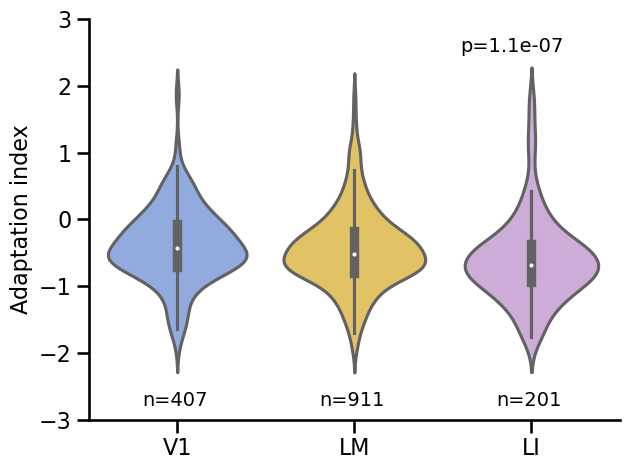

In [45]:
## suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 2]
    # gb_adp = gb_adp[np.abs(gb_R1) > 0.1]

    return gb_adp

df_filter = df_tidy[(df_tidy.filter_cell_vis == True)
                    ]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])

# plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
# plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
# plt.hist(gb_adp_LI, bins=50, alpha=.5, label='LI')
# plt.legend();

# adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
# adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
# adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
#                np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
#                 np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
# plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
# plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
# plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
# plt.ylim([-1, 0]);
# plt.legend(frameon=False);

# sns.boxplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], palette='Set2', notch=True, showfliers=False) # dont show the outliers beyond the caps

# ax = sns.swarmplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI],
#                      palette=['#85A7EB', '#F4C129', '#D1A6DE'],
#                      size=3)

ax = sns.violinplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
                    palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                    )
# plt.setp(ax.collections, alpha=.8)
# plt.setp(ax.lines, alpha=.5);

## ncell in each area
xpos = -0.2
ypos = -2.8
plt.text(xpos, ypos, f'n={len(gb_adp_V1)}', fontsize=14)
plt.text(xpos+1, ypos, f'n={len(gb_adp_LM)}', fontsize=14)
plt.text(xpos+2, ypos, f'n={len(gb_adp_LI)}', fontsize=14)

## p value
_, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
plt.text(xpos+1.8, 2.5, 'p={:.1e}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylim([-3, 3]);
plt.ylabel('Adaptation index', fontsize=16);
sns.despine();
plt.tight_layout();

dir_fig = repo_dir + r'\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'fig2_adp_by_area_grat8_vis_bonferroni.pdf'))

In [21]:
df_filter.groupby('area').cell_id.nunique()

area
LI    222
LM    983
V1    449
Name: cell_id, dtype: int64

In [20]:
## kruskal wallis test
print(stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_adp_V1, gb_adp_LM), stats.mannwhitneyu(gb_adp_V1, gb_adp_LI), stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)

KruskalResult(statistic=32.12426436459191, pvalue=1.0575590489842391e-07)


(MannwhitneyuResult(statistic=203162.0, pvalue=0.005368948767119582),
 MannwhitneyuResult(statistic=52253.0, pvalue=2.5494297556943888e-08),
 MannwhitneyuResult(statistic=108902.0, pvalue=2.5643475251736573e-05))

## population level adp across area

In [44]:
df_tidy['date_sess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)

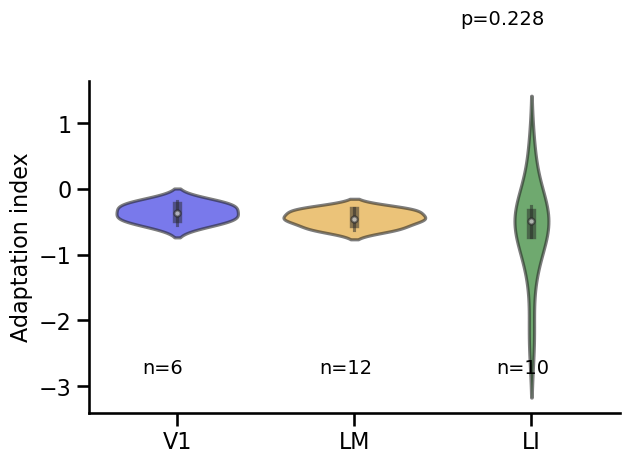

In [179]:
# ## suppress FutureWarning
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

def adp_in_area_pop(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['mouse']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['mouse']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    # gb_adp = gb_adp[np.abs(gb_adp) < 2]

    return gb_adp

df_filter = df_tidy[(df_tidy.isi == 250)
                    & (df_tidy.filter_cell_vis == True)
                    ]
gb_adp_V1 = adp_in_area_pop(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area_pop(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area_pop(df_filter[df_filter.area == 'LI'])

ax = sns.violinplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
                    palette=['blue', 'orange', 'green'], 
                    )
plt.setp(ax.collections, alpha=.6)
plt.setp(ax.lines, alpha=.5);

## ncell in each area
xpos = -0.2
ypos = -2.8
plt.text(xpos, ypos, f'n={len(gb_adp_V1)}', fontsize=14)
plt.text(xpos+1, ypos, f'n={len(gb_adp_LM)}', fontsize=14)
plt.text(xpos+2, ypos, f'n={len(gb_adp_LI)}', fontsize=14)

## p value
_, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
plt.text(xpos+1.8, 2.5, 'p={:.3f}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
# plt.ylim([-3, 3]);
plt.ylabel('Adaptation index', fontsize=16);
sns.despine();
plt.tight_layout();

dir_fig = repo_dir + r'\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'adp_by_area_grat8_vis.pdf'))

In [180]:
## kruskal wallis test
print(stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_adp_V1, gb_adp_LM), stats.mannwhitneyu(gb_adp_V1, gb_adp_LI), stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)

KruskalResult(statistic=2.9534482758620726, pvalue=0.22838462080849378)


(MannwhitneyuResult(statistic=51.0, pvalue=0.1797026502908856),
 MannwhitneyuResult(statistic=44.0, pvalue=0.14710289710289712),
 MannwhitneyuResult(statistic=70.0, pvalue=0.5310451014658126))

## old version adaptation

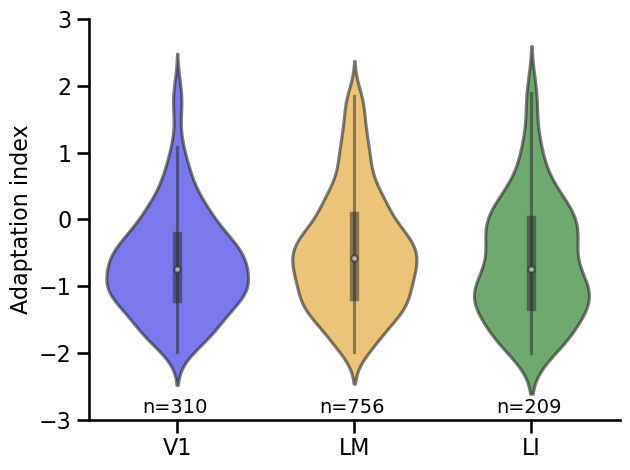

In [122]:
# ## suppress FutureWarning
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

def old_adp_in_area(df_filter, area):

    gb_R1 = (df_filter[(df_filter.area == area) 
                & (df_filter.stim2_id == 0) 
                & (df_filter.resp_id == 'R1')
                ]
            .groupby(['trial_id', 'cell_id']) # each trial_id is a pair of R1-R2
            .dfof.apply(lambda x: x.values[0]) # take dfof value from the only row in each group
            )
    gb_R2 = (df_filter[(df_filter.area == area) 
                & (df_filter.stim2_id == 0) 
                & (df_filter.resp_id == 'R2')
                ]
            .groupby(['trial_id', 'cell_id'])
            .dfof.apply(lambda x: x.values[0])
            )

    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)

    gb = (df_filter[(df_filter.area == area) 
                & (df_filter.stim2_id == 0) 
                & (df_filter.resp_id == 'R1')
                ]
            .groupby(['trial_id', 'cell_id'])
            .dfof.sum().to_frame() # not used, just providing index
            )
    gb['adp'] = gb_adp
    gb = gb.drop(columns='dfof').reset_index()
    adp_cell = gb.groupby('cell_id').adp.mean().values
    adp_cell = adp_cell[np.abs(adp_cell) < 2]

    return adp_cell


df_filter = df_tidy[(df_tidy.isi == 250)
                    & (df_tidy.filter_cell_vis == True)
                    ]
gb_adp_V1 = old_adp_in_area(df_filter, 'V1')
gb_adp_LM = old_adp_in_area(df_filter, 'LM')
gb_adp_LI = old_adp_in_area(df_filter, 'LI')


ax = sns.violinplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
                    palette=['blue', 'orange', 'green'], 
                    )
plt.setp(ax.collections, alpha=.6)
plt.setp(ax.lines, alpha=.5);

## ncell in each area
xpos = -0.2
ypos = -2.9
plt.text(xpos, ypos, f'n={len(gb_adp_V1)}', fontsize=14)
plt.text(xpos+1, ypos, f'n={len(gb_adp_LM)}', fontsize=14)
plt.text(xpos+2, ypos, f'n={len(gb_adp_LI)}', fontsize=14)

# ## p value
# _, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
# plt.text(xpos+1.8, 2.5, 'p={:.1e}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylim([-3, 3]);
plt.ylabel('Adaptation index', fontsize=16);
sns.despine();
plt.tight_layout();

dir_fig = repo_dir + r'\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'old_ver_adp_by_area_grat8_vis.pdf'))

# tuning bias crude max-ori

## filter cell well-max

11

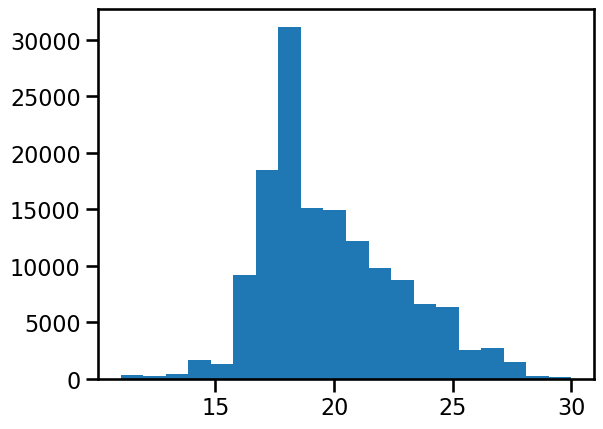

In [52]:
df_nrep = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).count() # count trials per cell, isi, ori
            )
plt.hist(df_nrep.values.flatten(), bins=20);
min(df_nrep.values.flatten())

In [53]:
## construct tuning_vec column

max_ori_bootstrap = np.array([])
nboot = 50

for iboot in tqdm(range(nboot)):
    max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .sample(frac=.7, random_state=iboot) # sample x trials per group. min rep = 48
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
                .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
                .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
                .rename(columns={0: 'max_ori'}).max_ori.values
                )
    max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)

100%|██████████| 50/50 [03:43<00:00,  4.46s/it]


In [84]:
max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

## sort max_ori_bootstrap in each col (across boots)
max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

## count the most freq value in each col (across boots)
# max_ori_mode = stats.mode(max_ori_bootstrap, axis=0)[0] # value of mode (most freq max_ori)
max_ori_mode_freq = stats.mode(max_ori_bootstrap, axis=0)[1] # count of mode
filter_cell_well_max = (max_ori_mode_freq >= nboot * 0.7) # NOTE: strictness of well-max can be adjusted here

# ## query values at ith and (100-i)th percentile to see if their diff > 1
# percentile = 5 # NOTE: strictness of well-max can be adjusted here
# max_ori_boot_low = np.percentile(max_ori_bootstrap, percentile, axis=0)
# max_ori_boot_high = np.percentile(max_ori_bootstrap, 100-percentile, axis=0)
# max_ori_boot_var = max_ori_boot_high - max_ori_boot_low
# max_ori_boot_var.shape # df_tidy.cell_id.nunique() x df_tidy.isi.nunique() = 160 x 3

# ## use max_ori_boot_var to get filter_cell_well_max
# filter_cell_well_max = ((max_ori_boot_var <= 1) | (max_ori_boot_var == 7)) # 7 is equivalent to 1, due to circularity. NOTE: strictness of well-max can be adjusted here too
# # plt.plot(max_ori_boot_var[10:30], color='k');
# # plt.plot(filter_cell_well_max[10:30], color='r');

## merge filter_cell_well_max with df
df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
                .groupby(['cell_id', 'isi'])
                .first() # get first trial per cell, isi
                .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
                )
df_well_max['filter_cell_well_max'] = filter_cell_well_max
# df_well_max.filter_cell_well_max.sum() / df_well_max.shape[0]
df_well_max

cell_id   isi  filter_cell_well_max
0     200720_003_0   250                 False
1     200720_003_0   750                  True
2     200720_003_0  6000                 False
3     200720_003_1   250                  True
4     200720_003_1   750                 False
...            ...   ...                   ...
8962  230309_003_8   750                 False
8963  230309_003_8  6000                  True
8964  230309_003_9   250                  True
8965  230309_003_9   750                 False
8966  230309_003_9  6000                  True

[8967 rows x 3 columns]

In [94]:
## inherit df_well_max['filter_cell_well_max']
df_tidy = df_tidy.merge(
      df_well_max, 
      on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi
df_tidy

dfof        cell_id  trial_id resp_id   isi  stim1_contrast  \
0       -0.003253   200720_003_0         0      R1   750               1   
1        0.088726   200720_003_0         1      R1   250               1   
2       -0.010485   200720_003_0         2      R1   250               1   
3       -0.050493   200720_003_0         3      R1   750               1   
4        0.052611   200720_003_0         5      R1   750               1   
...           ...            ...       ...     ...   ...             ...   
2413843  0.074167  230309_003_32       473      R2   750               1   
2413844 -0.023736  230309_003_32       474      R2   750               1   
2413845  0.060245  230309_003_32       475      R2   250               1   
2413846  0.009333  230309_003_32       476      R2  6000               0   
2413847 -0.079758  230309_003_32       477      R2   750               1   

         stim2_id area  stim1_id  filter_cell_vis  filter_cell_vis_pval  \
0               5   V1         0             True              0.006817   
1               2   V1         0             True              0.006817   
2               2   V1         0             True              0.006817   
3               3   V1         0             True              0.006817   
4               0   V1         0             True              0.006817   
...           ...  ...       ...              ...                   ...   
2413843         6   LI         0            False              0.181598   
2413844         0   LI         0            False              0.181598   
2413845         1   LI         0            False              0.181598   
2413846         2   LI         0            False              0.181598   
2413847         6   LI         0            False              0.181598   

         filter_cell_well_fit  filter_cell_stim mouse    date sess  \
0                         1.0             False  1323  200720  003   
1                         1.0             False  1323  200720  003   
2                         1.0             False  1323  200720  003   
3                         1.0             False  1323  200720  003   
4                         1.0             False  1323  200720  003   
...                       ...               ...   ...     ...  ...   
2413843                   0.0             False  1381  230309  003   
2413844                   0.0             False  1381  230309  003   
2413845                   0.0             False  1381  230309  003   
2413846                   0.0             False  1381  230309  003   
2413847                   0.0             False  1381  230309  003   

         filter_cell_well_max  
0                        True  
1                       False  
2                       False  
3                        True  
4                        True  
...                       ...  
2413843                 False  
2413844                 False  
2413845                  True  
2413846                 False  
2413847                 False  

[2413848 rows x 17 columns]

## pref_ori for cell, no adapter or with adapter
crude preference: take max-resp orientation as the preferred orien

In [95]:
pref_ori_noad = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_noad'})
                )

pref_ori_ad_250 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_250'})
                )

pref_ori_ad_750 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 750)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_750'})
                )

df_tidy = (df_tidy.merge(pref_ori_noad, on='cell_id')
            .merge(pref_ori_ad_250, on='cell_id')
            .merge(pref_ori_ad_750, on='cell_id'))
df_tidy

dfof        cell_id  trial_id resp_id   isi  stim1_contrast  \
0       -0.003253   200720_003_0         0      R1   750               1   
1        0.088726   200720_003_0         1      R1   250               1   
2       -0.010485   200720_003_0         2      R1   250               1   
3       -0.050493   200720_003_0         3      R1   750               1   
4        0.052611   200720_003_0         5      R1   750               1   
...           ...            ...       ...     ...   ...             ...   
2413843  0.074167  230309_003_32       473      R2   750               1   
2413844 -0.023736  230309_003_32       474      R2   750               1   
2413845  0.060245  230309_003_32       475      R2   250               1   
2413846  0.009333  230309_003_32       476      R2  6000               0   
2413847 -0.079758  230309_003_32       477      R2   750               1   

         stim2_id area  stim1_id  filter_cell_vis  filter_cell_vis_pval  \
0               5   V1         0             True              0.006817   
1               2   V1         0             True              0.006817   
2               2   V1         0             True              0.006817   
3               3   V1         0             True              0.006817   
4               0   V1         0             True              0.006817   
...           ...  ...       ...              ...                   ...   
2413843         6   LI         0            False              0.181598   
2413844         0   LI         0            False              0.181598   
2413845         1   LI         0            False              0.181598   
2413846         2   LI         0            False              0.181598   
2413847         6   LI         0            False              0.181598   

         filter_cell_well_fit  filter_cell_stim mouse    date sess  \
0                         1.0             False  1323  200720  003   
1                         1.0             False  1323  200720  003   
2                         1.0             False  1323  200720  003   
3                         1.0             False  1323  200720  003   
4                         1.0             False  1323  200720  003   
...                       ...               ...   ...     ...  ...   
2413843                   0.0             False  1381  230309  003   
2413844                   0.0             False  1381  230309  003   
2413845                   0.0             False  1381  230309  003   
2413846                   0.0             False  1381  230309  003   
2413847                   0.0             False  1381  230309  003   

         filter_cell_well_max  pref_ori_noad  pref_ori_ad_250  pref_ori_ad_750  
0                        True              4                3                3  
1                       False              4                3                3  
2                       False              4                3                3  
3                        True              4                3                3  
4                        True              4                3                3  
...                       ...            ...              ...              ...  
2413843                 False              5                0                7  
2413844                 False              5                0                7  
2413845                  True              5                0                7  
2413846                 False              5                0                7  
2413847                 False              5                0                7  

[2413848 rows x 20 columns]

In [96]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def distace_from_adapter(x):
    # adapter is always 0 deg
    x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter

df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

dfof        cell_id  trial_id resp_id  isi  stim1_contrast  \
1535086  0.070788  230302_004_53       353      R2  750               1   
1498362 -0.001468  230302_004_10        50      R2  250               1   
10251   -0.030888  200720_003_13        84      R1  250               1   
26153   -0.020128  200720_003_33       401      R1  250               1   
1794444  0.021428  230307_004_31       149      R2  250               1   

         stim2_id area  stim1_id  filter_cell_vis  ...    date  sess  \
1535086         3   LM         0             True  ...  230302   004   
1498362         7   LM         0             True  ...  230302   004   
10251           6   V1         0             True  ...  200720   003   
26153           0   V1         0            False  ...  200720   003   
1794444         3   LM         0            False  ...  230307   004   

         filter_cell_well_max pref_ori_noad pref_ori_ad_250 pref_ori_ad_750  \
1535086                  True             5               3               3   
1498362                 False             0               0               7   
10251                    True             0               0               0   
26153                    True             7               7               3   
1794444                  True             6               6               7   

         pref_unadapted_distance  pref_unadapted_distance_bin  \
1535086                     67.5                           90   
1498362                      0.0                            0   
10251                        0.0                            0   
26153                       22.5                            0   
1794444                     45.0                           45   

         pref_adapted_distance  tuning_bias  
1535086                   67.5          0.0  
1498362                    0.0          0.0  
10251                      0.0          0.0  
26153                     22.5          0.0  
1794444                   45.0          0.0  

[5 rows x 24 columns]

In [97]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

dfof        cell_id  trial_id resp_id  isi  stim1_contrast  \
1535086  0.070788  230302_004_53       353      R2  750               1   
1498362 -0.001468  230302_004_10        50      R2  250               1   
10251   -0.030888  200720_003_13        84      R1  250               1   
26153   -0.020128  200720_003_33       401      R1  250               1   
1794444  0.021428  230307_004_31       149      R2  250               1   

         stim2_id area  stim1_id  filter_cell_vis  ...    date  sess  \
1535086         3   LM         0             True  ...  230302   004   
1498362         7   LM         0             True  ...  230302   004   
10251           6   V1         0             True  ...  200720   003   
26153           0   V1         0            False  ...  200720   003   
1794444         3   LM         0            False  ...  230307   004   

         filter_cell_well_max pref_ori_noad pref_ori_ad_250 pref_ori_ad_750  \
1535086                  True             5               3               3   
1498362                 False             0               0               7   
10251                    True             0               0               0   
26153                    True             7               7               3   
1794444                  True             6               6               7   

         pref_unadapted_distance  pref_unadapted_distance_bin  \
1535086                     67.5                           90   
1498362                      0.0                            0   
10251                        0.0                            0   
26153                       22.5                            0   
1794444                     45.0                           45   

         pref_adapted_distance  tuning_bias  
1535086                   67.5          0.0  
1498362                    0.0          0.0  
10251                      0.0          0.0  
26153                     22.5          0.0  
1794444                   45.0          0.0  

[5 rows x 24 columns]

## tuning bias plot no fit

In [119]:
df_tidy.groupby('cell_id').first().reset_index()[(df_tidy.filter_cell_vis == True) & (df_tidy.isi == 250)].groupby(['area']).filter_cell_well_max.mean()

C:\Users\ll357\AppData\Local\Temp\2\ipykernel_33756\965233296.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tidy.groupby('cell_id').first().reset_index()[(df_tidy.filter_cell_vis == True) & (df_tidy.isi == 250)].groupby(['area']).filter_cell_well_max.mean()


area
LI    0.44375
LM    0.52069
V1    0.59589
Name: filter_cell_well_max, dtype: float64

In [111]:
df_tidy[(df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_max == True) & (df_tidy.isi == 250)].groupby('area').cell_id.nunique()

area
LI    112
LM    532
V1    281
Name: cell_id, dtype: int64

In [99]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    # & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.isi == 250)
                    ]
df_filter = df_filter.groupby('cell_id').first().reset_index() # drop duplicate cell_id
df_filter.groupby('area').cell_id.nunique()

area
LI    112
LM    532
V1    281
Name: cell_id, dtype: int64

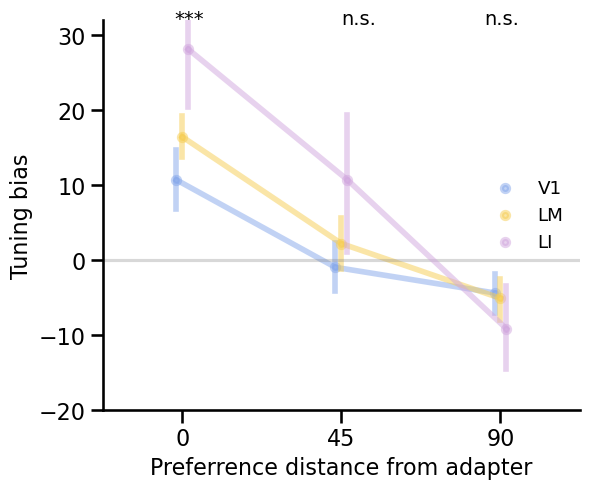

In [113]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', palette=['#85A7EB', '#F6CD51', '#D1A6DE'],
                   errorbar=('ci', 95), #errwidthfloat=1, capsize=.1,
                   )

ax.text(0.15, 0.99, '***', transform=ax.transAxes, fontsize=14)
ax.text(0.5, 0.99, 'n.s.', transform=ax.transAxes, fontsize=14)
ax.text(0.8, 0.99, 'n.s.', transform=ax.transAxes, fontsize=14)

# ## ncell in each area for each bin
# jitter_large = 0.3
# jitter_small = 0.1
# y_text = -14
# ax.text(-jitter_large, y_text, f'V1 n={df_filter[(df_filter.area == "V1") & (df_filter.pref_unadapted_distance_bin == 0)].cell_id.nunique()}', fontsize=12)
# ax.text(1-jitter_small, y_text, f'{df_filter[(df_filter.area == "V1") & (df_filter.pref_unadapted_distance_bin == 45)].cell_id.nunique()}', fontsize=12)
# ax.text(2-jitter_small, y_text, f'{df_filter[(df_filter.area == "V1") & (df_filter.pref_unadapted_distance_bin == 90)].cell_id.nunique()}', fontsize=12)
# ax.text(-jitter_large, y_text-2, f'LM n={df_filter[(df_filter.area == "LM") & (df_filter.pref_unadapted_distance_bin == 0)].cell_id.nunique()}', fontsize=12)
# ax.text(1-jitter_small, y_text-2, f'{df_filter[(df_filter.area == "LM") & (df_filter.pref_unadapted_distance_bin == 45)].cell_id.nunique()}', fontsize=12)
# ax.text(2-jitter_small, y_text-2, f'{df_filter[(df_filter.area == "LM") & (df_filter.pref_unadapted_distance_bin == 90)].cell_id.nunique()}', fontsize=12)
# ax.text(-jitter_large, y_text-4, f'LI n={df_filter[(df_filter.area == "LI") & (df_filter.pref_unadapted_distance_bin == 0)].cell_id.nunique()}', fontsize=12)
# ax.text(1-jitter_small, y_text-4, f'{df_filter[(df_filter.area == "LI") & (df_filter.pref_unadapted_distance_bin == 45)].cell_id.nunique()}', fontsize=12)
# ax.text(2-jitter_small, y_text-4, f'{df_filter[(df_filter.area == "LI") & (df_filter.pref_unadapted_distance_bin == 90)].cell_id.nunique()}', fontsize=12)

plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.5);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False, loc='right');
plt.xlabel('Preferrence distance from adapter', fontsize=16);
plt.ylabel('Tuning bias', fontsize=16);
plt.ylim([-20, 32]);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_wellmax_by_area_grat8_vis_bonf_ci95.pdf'))

In [133]:
(df_filter
    # .sort_values(by='area')
    # .sort_values(by='pref_unadapted_distance_bin')
    .groupby(['area', 'pref_unadapted_distance_bin'], 
            #  sort=False
             )
    .cell_id.nunique())

area  pref_unadapted_distance_bin
LI    0                               40
      45                              26
      90                              71
LM    0                              252
      45                             128
      90                             218
V1    0                              104
      45                              70
      90                             116
Name: cell_id, dtype: int64

In [107]:
bias_0_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'V1')].tuning_bias.values
bias_0_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LM')].tuning_bias.values
bias_0_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_0_V1, bias_0_LM, bias_0_LI))

bias_45_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'V1')].tuning_bias.values
bias_45_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LM')].tuning_bias.values
bias_45_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_45_V1, bias_45_LM, bias_45_LI))

bias_90_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'V1')].tuning_bias.values
bias_90_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LM')].tuning_bias.values
bias_90_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_90_V1, bias_90_LM, bias_90_LI))

KruskalResult(statistic=21.597479716168692, pvalue=2.0425225884058178e-05)
KruskalResult(statistic=5.2026785459656955, pvalue=0.07417417219844605)
KruskalResult(statistic=3.2773047556309245, pvalue=0.19424163032056777)


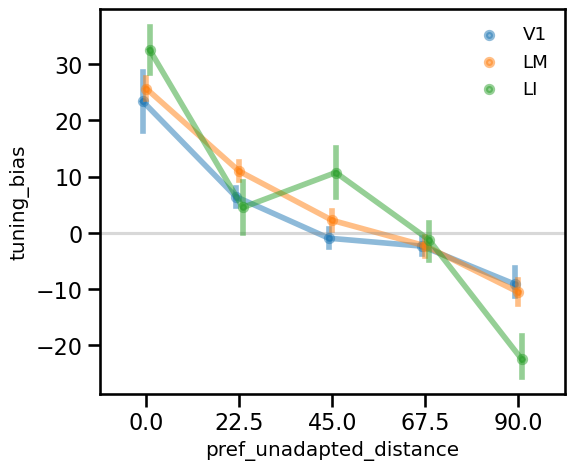

In [108]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', 
                   errorbar=('ci', 68), #errwidthfloat=1, capsize=.1,
                   )
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.5);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False);

In [26]:
df_filter.groupby(['area', 'pref_unadapted_distance']).cell_id.nunique()

area  pref_unadapted_distance
LI    0.0                         31
      22.5                         9
      45.0                        26
      67.5                        47
      90.0                        24
LM    0.0                         97
      22.5                       155
      45.0                       128
      67.5                       146
      90.0                        72
V1    0.0                         32
      22.5                        72
      45.0                        70
      67.5                        81
      90.0                        35
Name: cell_id, dtype: int64

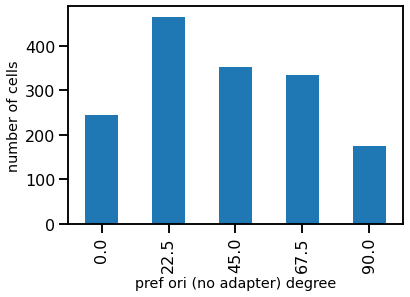

In [ ]:
# df_filter.groupby('pref_unadapted_distance').cell_id.nunique().sort_index().plot(kind='bar')
# # plt.xticks(np.arange(0, 5, 1), np.arange(0, 90+22.5, 22.5), rotation=45)
# plt.xlabel('pref ori (no adapter) degree')
# plt.ylabel('number of cells');

# tuning bias preprocessing
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell & isi
~~crude preference: take max-resp orientation as the preferred orien~~  
fitted preference: use pref from von mises curve fit

In [10]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def bin_ori_finer(x):
    # bin pref ori to n bins, with equal bin width
    nbin = 4 # n_edge = nbin + 1
    bin_width = 90 / nbin
    return (x // bin_width) * bin_width

def distance_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x)) # bin the distance to 5 edges, 0, 22.5, 45, 67.5, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

dfof         cell_id  trial_id resp_id  isi  stim1_contrast  \
1535086  0.240415  230302_004_131       195      R1  250               1   
1498362  0.018307   230302_004_25       274      R1  750               1   
10251    0.200723   200720_003_31       432      R1  250               1   
26153   -0.088930   200720_003_81       217      R1  250               1   
1794444 -0.057807   230307_004_76       294      R1  750               1   

         stim2_id area  stim1_id  filter_cell_vis  ...  ori_pref_noad2  \
1535086         6   LM         0             True  ...      120.626840   
1498362         6   LM         0             True  ...       81.351494   
10251           7   V1         0             True  ...      120.642231   
26153           3   V1         0             True  ...      157.858841   
1794444         0   LM         0            False  ...      157.510524   

         filter_cell_well_fit_ad_250  filter_cell_well_fit_ad_750  mouse  \
1535086                        False                        False   1373   
1498362                         True                        False   1373   
10251                          False                         True   1323   
26153                           True                        False   1323   
1794444                        False                         True   1381   

           date  sess  pref_unadapted_distance  pref_unadapted_distance_bin  \
1535086  230302   004                22.411221                            0   
1498362  230302   004                58.724983                           45   
10251    200720   003                43.627369                           45   
26153    200720   003                26.301962                            0   
1794444  230307   004                44.647932                           45   

         pref_adapted_distance tuning_bias  
1535086              88.885041   66.473820  
1498362              53.278383   -5.446600  
10251                51.436862    7.809493  
26153                25.532079   -0.769883  
1794444              25.656653  -18.991279  

[5 rows x 26 columns]

In [11]:
df_control = df_tidy.copy()

df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x))

df_control['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

df_control.sample(5, random_state=0)

dfof         cell_id  trial_id resp_id  isi  stim1_contrast  \
1535086  0.240415  230302_004_131       195      R1  250               1   
1498362  0.018307   230302_004_25       274      R1  750               1   
10251    0.200723   200720_003_31       432      R1  250               1   
26153   -0.088930   200720_003_81       217      R1  250               1   
1794444 -0.057807   230307_004_76       294      R1  750               1   

         stim2_id area  stim1_id  filter_cell_vis  ...  ori_pref_noad2  \
1535086         6   LM         0             True  ...      120.626840   
1498362         6   LM         0             True  ...       81.351494   
10251           7   V1         0             True  ...      120.642231   
26153           3   V1         0             True  ...      157.858841   
1794444         0   LM         0            False  ...      157.510524   

         filter_cell_well_fit_ad_250  filter_cell_well_fit_ad_750  mouse  \
1535086                        False                        False   1373   
1498362                         True                        False   1373   
10251                          False                         True   1323   
26153                           True                        False   1323   
1794444                        False                         True   1381   

           date  sess  pref_unadapted_distance  pref_unadapted_distance_bin  \
1535086  230302   004                22.411221                            0   
1498362  230302   004                58.724983                           45   
10251    200720   003                43.627369                           45   
26153    200720   003                26.301962                            0   
1794444  230307   004                44.647932                           45   

         pref_adapted_distance tuning_bias  
1535086              59.373160   36.961939  
1498362              81.351494   22.626511  
10251                59.357769   15.730399  
26153                22.141159   -4.160803  
1794444              22.489476  -22.158456  

[5 rows x 26 columns]

## merge df real vs control

In [12]:
assert len(df_tidy) == len(df_control) # same number of rows
assert (df_tidy.columns == df_control.columns).all() # all columns are the same
assert np.sum(df_control['pref_unadapted_distance_bin'].values == df_tidy['pref_unadapted_distance_bin'].values) == len(df_tidy) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
assert np.sum(df_tidy.tuning_bias.values == df_control.tuning_bias.values) < len(df_tidy) # different tuning bias
print('for tuning bias plot, only tuning bias col differs between control and real df')

for tuning bias plot, only tuning bias col differs between control and real df


In [13]:
df_tidy['tuning_bias_control'] = df_control['tuning_bias']
df_tidy

dfof        cell_id  trial_id resp_id   isi  stim1_contrast  \
0       -0.003253   200720_003_0         0      R1   750               1   
1        0.088726   200720_003_0         1      R1   250               1   
2       -0.010485   200720_003_0         2      R1   250               1   
3       -0.050493   200720_003_0         3      R1   750               1   
4        0.052611   200720_003_0         5      R1   750               1   
...           ...            ...       ...     ...   ...             ...   
2413843  0.074167  230309_003_32       473      R2   750               1   
2413844 -0.023736  230309_003_32       474      R2   750               1   
2413845  0.060245  230309_003_32       475      R2   250               1   
2413846  0.009333  230309_003_32       476      R2  6000               0   
2413847 -0.079758  230309_003_32       477      R2   750               1   

         stim2_id area  stim1_id  filter_cell_vis  ...  \
0               5   V1         0             True  ...   
1               2   V1         0             True  ...   
2               2   V1         0             True  ...   
3               3   V1         0             True  ...   
4               0   V1         0             True  ...   
...           ...  ...       ...              ...  ...   
2413843         6   LI         0            False  ...   
2413844         0   LI         0            False  ...   
2413845         1   LI         0            False  ...   
2413846         2   LI         0            False  ...   
2413847         6   LI         0            False  ...   

         filter_cell_well_fit_ad_250  filter_cell_well_fit_ad_750  mouse  \
0                               True                         True   1323   
1                               True                         True   1323   
2                               True                         True   1323   
3                               True                         True   1323   
4                               True                         True   1323   
...                              ...                          ...    ...   
2413843                         True                        False   1381   
2413844                         True                        False   1381   
2413845                         True                        False   1381   
2413846                         True                        False   1381   
2413847                         True                        False   1381   

           date  sess  pref_unadapted_distance  pref_unadapted_distance_bin  \
0        200720   003                73.675005                           90   
1        200720   003                73.675005                           90   
2        200720   003                73.675005                           90   
3        200720   003                73.675005                           90   
4        200720   003                73.675005                           90   
...         ...   ...                      ...                          ...   
2413843  230309   003                23.145373                            0   
2413844  230309   003                23.145373                            0   
2413845  230309   003                23.145373                            0   
2413846  230309   003                23.145373                            0   
2413847  230309   003                23.145373                            0   

         pref_adapted_distance  tuning_bias tuning_bias_control  
0                    71.987028    -1.687976            2.857408  
1                    71.465895    -2.209110            2.857408  
2                    71.465895    -2.209110            2.857408  
3                    71.987028    -1.687976            2.857408  
4                    71.987028    -1.687976            2.857408  
...                        ...          ...                 ...  
2413843              22.057334    -1.088039           49.018433  
2413844      

## save & reload

In [15]:
dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = dir_df + 'df_tidy_tuning_bias_diff_exclude_bad_LI.csv'

# chunks = np.array_split(df_tidy.index, 100) # split into 100 chunks
# for chunk, subset in enumerate(tqdm(chunks)):
#     if chunk == 0: # first row
#         df_tidy.loc[subset].to_csv(csv_filename, mode='w', index=True)
#     else:
#         df_tidy.loc[subset].to_csv(csv_filename, header=None, mode='a', index=True)

df_tidy = pd.read_csv(os.path.join(dir_df, csv_filename), index_col=0) # this csv excludes bad LI data
df_tidy

dfof        cell_id  trial_id resp_id   isi  stim1_contrast  \
0       -0.003253   200720_003_0         0      R1   750               1   
1        0.088726   200720_003_0         1      R1   250               1   
2       -0.010485   200720_003_0         2      R1   250               1   
3       -0.050493   200720_003_0         3      R1   750               1   
4        0.052611   200720_003_0         5      R1   750               1   
...           ...            ...       ...     ...   ...             ...   
2413843  0.074167  230309_003_32       473      R2   750               1   
2413844 -0.023736  230309_003_32       474      R2   750               1   
2413845  0.060245  230309_003_32       475      R2   250               1   
2413846  0.009333  230309_003_32       476      R2  6000               0   
2413847 -0.079758  230309_003_32       477      R2   750               1   

         stim2_id area  stim1_id  filter_cell_vis  ...  \
0               5   V1         0             True  ...   
1               2   V1         0             True  ...   
2               2   V1         0             True  ...   
3               3   V1         0             True  ...   
4               0   V1         0             True  ...   
...           ...  ...       ...              ...  ...   
2413843         6   LI         0            False  ...   
2413844         0   LI         0            False  ...   
2413845         1   LI         0            False  ...   
2413846         2   LI         0            False  ...   
2413847         6   LI         0            False  ...   

         filter_cell_well_fit_ad_250  filter_cell_well_fit_ad_750  mouse  \
0                               True                         True   1323   
1                               True                         True   1323   
2                               True                         True   1323   
3                               True                         True   1323   
4                               True                         True   1323   
...                              ...                          ...    ...   
2413843                         True                        False   1381   
2413844                         True                        False   1381   
2413845                         True                        False   1381   
2413846                         True                        False   1381   
2413847                         True                        False   1381   

           date  sess  pref_unadapted_distance  pref_unadapted_distance_bin  \
0        200720     3                73.675005                           90   
1        200720     3                73.675005                           90   
2        200720     3                73.675005                           90   
3        200720     3                73.675005                           90   
4        200720     3                73.675005                           90   
...         ...   ...                      ...                          ...   
2413843  230309     3                23.145373                            0   
2413844  230309     3                23.145373                            0   
2413845  230309     3                23.145373                            0   
2413846  230309     3                23.145373                            0   
2413847  230309     3                23.145373                            0   

         pref_adapted_distance  tuning_bias  tuning_bias_control  
0                    71.987028    -1.687976             2.857408  
1                    71.465895    -2.209110             2.857408  
2                    71.465895    -2.209110             2.857408  
3                    71.987028    -1.687976             2.857408  
4                    71.987028    -1.687976             2.857408  
...                        ...          ...                  ...  
2413843              22.057334    -1.088039            49.018433  
24138

## if use all trials, not half trials

In [31]:
df_tidy_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias.csv'), index_col=0)
df_tidy_control_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias_control.csv'), index_col=0)

In [36]:
assert len(df_tidy_all_trials) == len(df_tidy_control_all_trials) # same number of rows
assert (df_tidy_all_trials.columns == df_tidy_control_all_trials.columns).all() # all columns are the same
# assert np.sum(df_tidy_control_all_trials['pref_unadapted_distance_bin'].values == df_tidy_all_trials['pref_unadapted_distance_bin'].values) == len(df_tidy_all_trials) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
assert np.sum(df_tidy_all_trials.tuning_bias.values == df_tidy_control_all_trials.tuning_bias.values) < len(df_tidy_all_trials) # different tuning bias
print('for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df')
df_tidy_all_trials['tuning_bias_control'] = df_tidy_control_all_trials['tuning_bias']
df_tidy_all_trials['pref_unadapted_distance_bin_control'] = df_tidy_control_all_trials['pref_unadapted_distance_bin']
df_tidy_all_trials

for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df


cell_id  trial_id resp_id   isi  stim1_contrast  stim2_id  \
dfof                                                                         
-0.003253   200720_003_0         0      R1   750               1         5   
 0.088726   200720_003_0         1      R1   250               1         2   
-0.010485   200720_003_0         2      R1   250               1         2   
-0.050493   200720_003_0         3      R1   750               1         3   
 0.052611   200720_003_0         5      R1   750               1         0   
...                  ...       ...     ...   ...             ...       ...   
 0.056616  230323_003_64       496      R2  6000               0         5   
 0.077247  230323_003_64       497      R2  6000               0         6   
 0.026982  230323_003_64       498      R2   250               1         6   
-0.069060  230323_003_64       499      R2  6000               0         7   
-0.002458  230323_003_64       500      R2   750               1         3   

          area  stim1_id  filter_cell_vis  filter_cell_well_fit  ...  \
dfof                                                             ...   
-0.003253   V1         0             True                   1.0  ...   
 0.088726   V1         0             True                   1.0  ...   
-0.010485   V1         0             True                   1.0  ...   
-0.050493   V1         0             True                   1.0  ...   
 0.052611   V1         0             True                   1.0  ...   
...        ...       ...              ...                   ...  ...   
 0.056616   LI         0            False                   0.0  ...   
 0.077247   LI         0            False                   0.0  ...   
 0.026982   LI         0            False                   0.0  ...   
-0.069060   LI         0            False                   0.0  ...   
-0.002458   LI         0            False                   0.0  ...   

           filter_cell_well_fit_ad_750  mouse    date  sess  \
dfof                                                          
-0.003253                         True   1323  200720     3   
 0.088726                         True   1323  200720     3   
-0.010485                         True   1323  200720     3   
-0.050493                         True   1323  200720     3   
 0.052611                         True   1323  200720     3   
...                                ...    ...     ...   ...   
 0.056616                        False   1374  230323     3   
 0.077247                        False   1374  230323     3   
 0.026982                        False   1374  230323     3   
-0.069060                        False   1374  230323     3   
-0.002458                        False   1374  230323     3   

           pref_unadapted_distance  pref_unadapted_distance_bin  \
dfof                                                              
-0.003253                82.347391                           90   
 0.088726                82.347391                           90   
-0.010485                82.347391                           90   
-0.050493                82.347391                           90   
 0.052611                82.347391                           90   
...                            ...                          ...   
 0.056616                 7.524045                            0   
 0.077247                 7.524045                            0   
 0.026982                 7.524045                            0   
-0.069060                 7.524045                            0   
-0.002458                 7.524045                            0   

           pref_adapted_distance  tuning_bias  tuning_bias_control  \
dfof                                                                 
-0.003253              73.637094    -8.710298            -1.662357   
 0.088726              68.247541   -14.099850            -1.662357   
-0.010485              68.247541   -14.099850            -1.662357   
-0.050493              

In [40]:
df_filter = df_tidy_all_trials[(df_tidy_all_trials.trial_id > -1) # placeholder, always true
                            & (df_tidy_all_trials.filter_cell_vis == True)
                            & (df_tidy_all_trials.filter_cell_well_fit == True)
                            & (df_tidy_all_trials.isi == 250)
                            ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'pref_unadapted_distance_bin_control', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

cell_id area  pref_unadapted_distance_bin  \
0     200720_003_0   V1                           90   
1     200720_003_2   V1                           90   
2    200720_003_22   V1                           90   
3    200720_003_24   V1                            0   
4    200720_003_25   V1                           90   
..             ...  ...                          ...   
632  230307_004_26   LM                            0   
633  230307_004_45   LM                           45   
634  230307_004_47   LM                            0   
635  230309_002_44   LI                           90   
636  230323_002_49   LI                            0   

     pref_unadapted_distance_bin_control  tuning_bias  tuning_bias_control  \
0                                     90   -14.099850            -1.662357   
1                                     90    -6.375618             0.529648   
2                                     90     7.036726             0.703476   
3                                      0    14.101941             2.149425   
4                                     90     6.757597             1.970022   
..                                   ...          ...                  ...   
632                                    0     4.357937            -8.113508   
633                                   45   -30.671126             5.708120   
634                                    0   -15.573513            -7.068267   
635                                   90   -50.296272            -1.398636   
636                                    0    36.563369             0.917558   

     tuning_bias_diff  
0          -12.437493  
1           -6.905266  
2            6.333250  
3           11.952516  
4            4.787575  
..                ...  
632         12.471445  
633        -36.379246  
634         -8.505246  
635        -48.897635  
636         35.645811  

[637 rows x 7 columns]

### tuning bias plot (all trials)

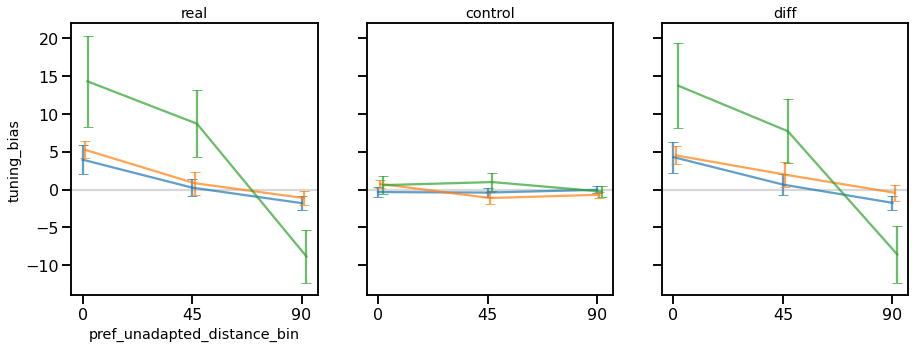

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin_control.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean() - df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

### stats sig

In [50]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (85,), (172,), (20,))

In [51]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

71.34761782293795 185.11324610274514


(-0.9513678466644974, 0.17118402305896058)

In [52]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

71.34761782293795 185.11324610274514 263.0468090748901
4.286658281671407e-07 1.632584685658505e-14 0.0015573829878121614


F_onewayResult(statistic=3.801247822372638, pvalue=0.023530258467825266)

In [53]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=9.896509703989182, pvalue=0.007095781318701659)

# tuning bias plot

In [16]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    # & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_tidy.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

cell_id area  pref_unadapted_distance_bin  tuning_bias  \
0     200720_003_0   V1                           90    -2.209110   
1     200720_003_2   V1                           90     1.545071   
2    200720_003_22   V1                           90    10.614124   
3    200720_003_24   V1                            0    11.165754   
4    200720_003_25   V1                           90    -7.029553   
..             ...  ...                          ...          ...   
631  230307_004_24   LM                            0    28.209884   
632  230307_004_26   LM                            0   -12.258905   
633  230307_004_45   LM                           90   -40.721540   
634  230307_004_47   LM                            0     7.807087   
635  230309_002_44   LI                           90   -65.059039   

     tuning_bias_control  tuning_bias_diff  
0               2.857408         -5.066517  
1               8.433376         -6.888306  
2              -3.925642         14.539765  
3              -4.270538         15.436292  
4              -3.337455         -3.692098  
..                   ...               ...  
631             6.004743         22.205141  
632             3.118108        -15.377012  
633           -13.967277        -26.754263  
634             3.307979          4.499108  
635             2.891672        -67.950710  

[636 rows x 6 columns]

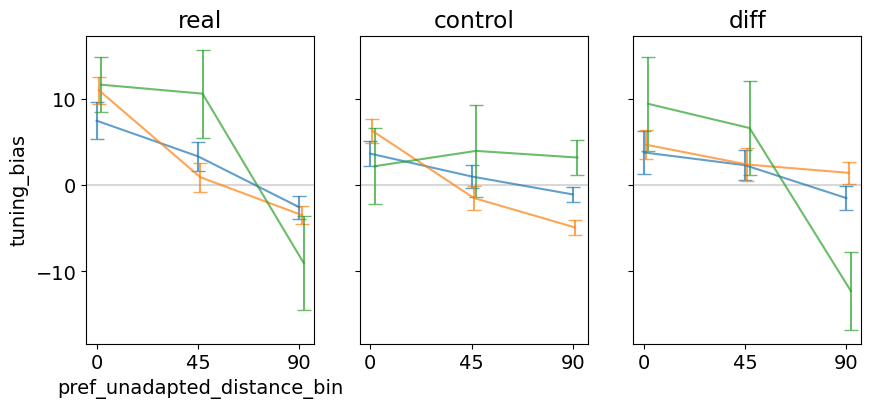

In [17]:
# set plt style to default
plt.style.use('default')

# set font size
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

# fig.savefig(os.path.join(r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/'), 'tuning_bias_by_area_with_control.pdf'), bbox_inches='tight')

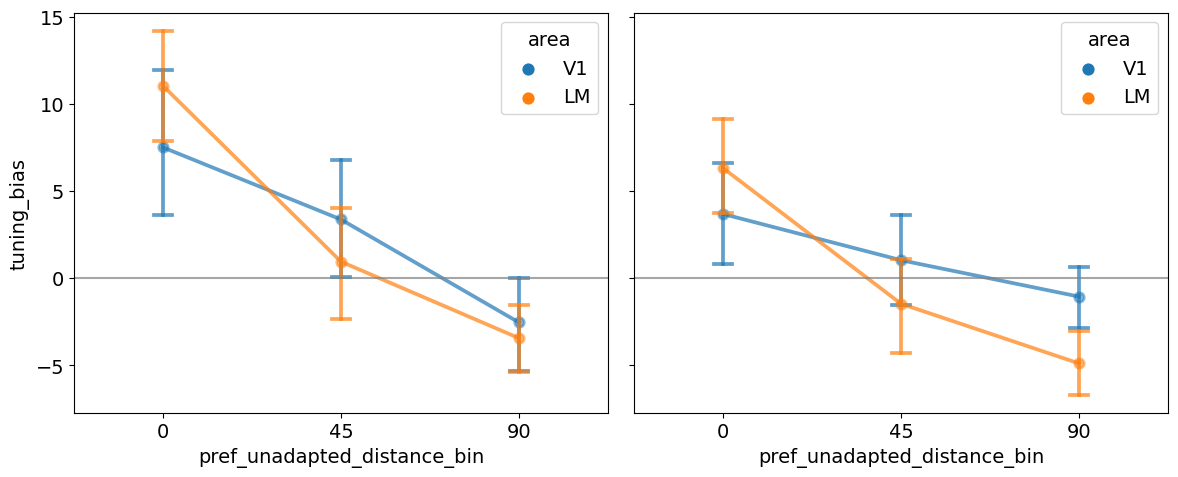

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_filter, hue='area',
                  errorbar="se", errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_filter, hue='area',
                   errorbar='se', 
                #    errorbar=('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

### stats sig

In [25]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (84,), (175,), (17,))

In [26]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

159.55193074673565 277.28870767509255


(-1.5635064143636679, 0.05972281688189927)

In [27]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

159.55193074673565 277.28870767509255 322.2720352824679
8.062943201991857e-09 6.215306314061309e-08 0.0006468608044087887


F_onewayResult(statistic=6.259144877158457, pvalue=0.002198717293043121)

In [28]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=13.168785484999262, pvalue=0.0013817662007700436)

### ncell by area & well fit %

In [29]:
df_filter.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), \
df_tidy.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), 

(pref_unadapted_distance_bin  area
 0                            LI        5
                              LM      117
                              V1       57
 45                           LI       10
                              LM       87
                              V1       85
 90                           LI       17
                              LM      175
                              V1       84
 Name: cell_id, dtype: int64,
 pref_unadapted_distance_bin  area
 0                            LI      327
                              LM      739
                              V1      216
 45                           LI      238
                              LM      417
                              V1      176
 90                           LI      305
                              LM      559
                              V1      191
 Name: cell_id, dtype: int64)

In [63]:
# stacked bar plot, colored by well_fit, for each area
df_tidy.groupby(['pref_unadapted_distance_bin', 'area', 'filter_cell_well_fit']).cell_id.nunique().unstack().plot(kind='bar', stacked=True, figsize=(12, 5), title='well_fit', colormap='tab10', legend='reverse', width=0.7);

# set legend frameon=False
plt.legend(frameon=False);

# set legend text content
plt.legend(['not well fit', 'well fit'], frameon=False);

plt.xlabel('preferred orientation distance from 0 degree adapter, area')
plt.ylabel('cell count')
plt.title('');
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'well_fit_by_area.pdf'))

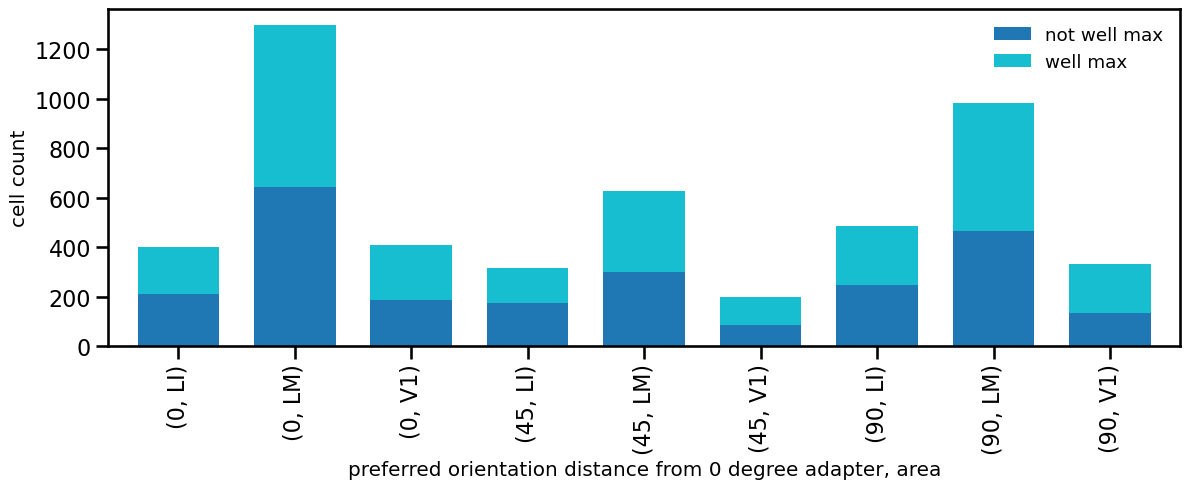

In [66]:
# stacked bar plot, colored by well_fit, for each area
(df_tidy.groupby(['pref_unadapted_distance_bin', 'area', 'filter_cell_well_max'])
 .cell_id.nunique().unstack()
 .plot(kind='bar', stacked=True, 
       figsize=(12, 5), title='well_max', 
       colormap='tab10', legend='reverse', width=0.7))

# set legend frameon=False
plt.legend(frameon=False);

# set legend text content
plt.legend(['not well max', 'well max'], frameon=False);

plt.xlabel('preferred orientation distance from 0 degree adapter, area')
plt.ylabel('cell count')
plt.title('');
plt.tight_layout();

plt.savefig(os.path.join(dir_fig, 'well_max_by_area.pdf'))

# df for tuning curve

In [154]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    'ori_pref_ad_250', 'ori_pref_noad', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    'tuning_bias', #'tuning_bias_control',
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    # & (df_tuning.area == 'LI')
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    # & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    # & (df_tuning.pref_unadapted_distance_bin == 90)
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.sort_values(by=['tuning_bias'], inplace=True) # df_tuning sort by tuning_bias_distance
df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 636/636 [02:41<00:00,  3.94it/s]


dfof        cell_id resp_id   isi  stim2_id area  \
20277    0.177746  200720_003_25      R2   250         2   V1   
1025811 -0.006025  210805_002_18      R2   250         6   LM   
1382193  0.035764  230302_003_13      R2   250         5   LM   
243999   0.125984  201015_004_17      R2  6000         7   V1   
480160  -0.038404  200721_002_26      R2   250         5   LM   

         filter_cell_vis  filter_cell_well_fit  filter_cell_well_fit_ad_250  \
20277               True                   1.0                        False   
1025811             True                   1.0                         True   
1382193             True                   1.0                         True   
243999              True                   1.0                         True   
480160              True                   1.0                         True   

         ori_pref_ad_250  ori_pref_noad  pref_unadapted_distance  \
20277          99.188945      92.159392                     67.5   
1025811        45.131557      48.995404                     45.0   
1382193        85.769124      78.532751                     90.0   
243999         67.522685      68.143864                     67.5   
480160         35.939160      39.992416                     45.0   

         pref_unadapted_distance_bin  pref_adapted_distance  tuning_bias  \
20277                             90                   90.0         22.5   
1025811                           45                   45.0          0.0   
1382193                           90                   67.5        -22.5   
243999                            90                    NaN          NaN   
480160                            45                   45.0          0.0   

                                               tuning_noad  \
20277    [-0.0018507992276713045, 0.06215882017835943, ...   
1025811  [0.025523786334807154, 0.03592235858228637, 0....   
1382193  [0.0022148492839876664, 0.02465958053766841, 0...   
243999   [0.019385999593291615, 0.008579004641462154, 0...   
480160   [0.037888198455414746, 0.13223266003314707, 0....   

                                                tuning_250  
20277    [-0.037093575337656774, -0.026934926615661957,...  
1025811  [0.00045834750380095203, 0.008241683892145468,...  
1382193  [0.003837844959831291, 0.00513778493864718, 0....  
243999   [-0.024580455714557033, -0.005500357654778451,...  
480160   [0.10636026684330444, 0.1805371811926468, 0.26...

## polar plot of tuning
before and after adaptation  
filter cells 

In [161]:
for icell in tqdm(df_tuning[df_tuning.area != 'V1'].cell_id.unique()):

    gOSI_noad = df_tuning[df_tuning.cell_id == icell].gOSI_noad.values[0]
    gOSI_250 = df_tuning[df_tuning.cell_id == icell].gOSI_250.values[0]

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))

    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)

    # plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    # ## plot 90 deg as a line
    # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
    # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (noad) as a line
    ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    if ori_pref_noad_opp > 2*np.pi:
        ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (ad 250) as a line
    ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    if ori_pref_ad_250_opp > 2*np.pi:
        ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

    ## add text at top left
    bias_color = 'blue'
    minus_flag = 'pos'
    if tuning_bias < 0: # attractive bias
        bias_color = 'red'
        minus_flag = 'neg'
    plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=bias_color, fontsize=16) # in cartesian coordinates
    gOSI_color = 'green'
    if gOSI_noad < 0.5 or gOSI_250 < 0.5:
        gOSI_color = 'orange'
    if gOSI_noad < 0.5 and gOSI_250 < 0.5:
        gOSI_color = 'red'
    plt.text(0.05, 0.85, f'gOSI_noad: {np.round(gOSI_noad, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates
    plt.text(0.05, 0.8, f'gOSI_250: {np.round(gOSI_250, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(min_val, max_val)

    area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    ax.set_title(f'cell_id {icell} in {area}')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\lan\Documents\repos\inter\results\tuning bias single cell'.replace('\\', '/')
    fig.savefig(os.path.join(dir_result, f'gOSI_{np.round(gOSI_noad, 2)}_{icell}_tuning_curve.pdf'), bbox_inches='tight')
    plt.close(fig)
    clear_output(wait=True)

100%|██████████| 410/410 [07:40<00:00,  1.12s/it]


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [156]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()#.head(20)

100%|██████████| 636/636 [01:14<00:00,  8.53it/s]


area  gOSI_noad  gOSI_250
cell_id                                
200728_003_33   V1   0.866154  0.729479
201015_004_12   V1   0.846736  0.789616
220228_002_16   LM   0.845744  0.809035
201127_002_3    LM   0.843627  0.700373
201015_004_6    V1   0.841990  0.720656
...            ...        ...       ...
201127_002_28   LM   0.173120  0.316416
210805_002_21   LM   0.171098  0.127466
200720_003_65   V1   0.161497  0.068662
200720_003_25   V1   0.139127  0.154438
220228_003_16   LM   0.114256  0.196087

[636 rows x 3 columns]

In [26]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_noad.hist(bins=20, alpha=.5, ax=axes[0]);
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_250.hist(bins=20, alpha=.5, ax=axes[1]);

# axes[0].legend(['V1', 'LM', 'LI',], frameon=False) # sorted area descending
# plt.tight_layout();
# ## indeed, gOSI is between 0 and 1. higher gOSI means more orientation selective

In [27]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

count      mean       std       min       25%       50%       75%  \
area                                                                         
LI     15111.0  0.493826  0.105991  0.289015  0.419533  0.491224  0.563361   
LM    186036.0  0.547436  0.148353  0.114256  0.444634  0.553049  0.661415   
V1    104642.0  0.547458  0.155385  0.139127  0.426200  0.559070  0.654359   

           max  
area            
LI    0.709965  
LM    0.845744  
V1    0.866154

In [28]:
df_tidy.groupby('area').filter_cell_well_fit.describe() # well fit cell filter discards most cells in LI already

count      mean       std  min  25%  50%  75%  max
area                                                        
LI     561185.0  0.061358  0.239985  0.0  0.0  0.0  0.0  1.0
LM    1393600.0  0.238967  0.426453  0.0  0.0  0.0  0.0  1.0
V1     459063.0  0.408351  0.491529  0.0  0.0  0.0  1.0  1.0

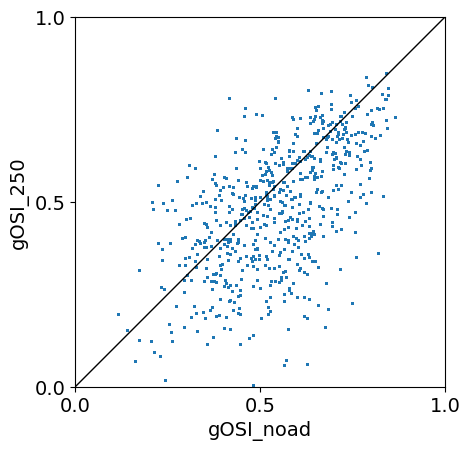

In [29]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

r2 score of gOSI_noad vs tuning_bias:  0.019663151965021997
r2 score of gOSI_250 vs tuning_bias:  0.003738889210329721
slope:  15.16351373942225
intercept:  -6.25223627335961
positive correlation between gOSI and tuning_bias


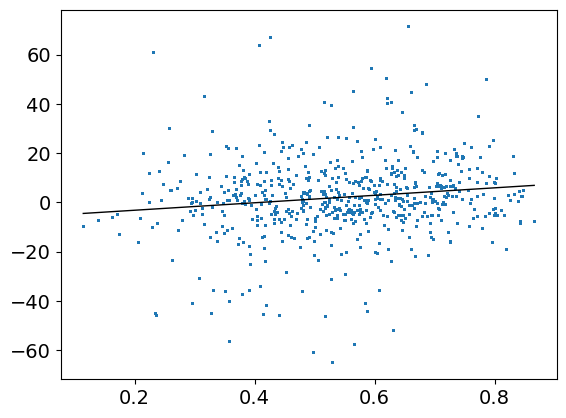

In [30]:
## regression: gOSI vs tuning_bias
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values
tmp1 = tmp1[~np.isnan(tmp3)]
tmp2 = tmp2[~np.isnan(tmp3)]
tmp3 = tmp3[~np.isnan(tmp3)]
tmp1 = tmp1.reshape(-1, 1)
tmp2 = tmp2.reshape(-1, 1)
tmp3 = tmp3.reshape(-1, 1)

reg1 = LinearRegression().fit(tmp1, tmp3)
reg2 = LinearRegression().fit(tmp2, tmp3)
print('r2 score of gOSI_noad vs tuning_bias: ', r2_score(tmp3, reg1.predict(tmp1)))
print('r2 score of gOSI_250 vs tuning_bias: ', r2_score(tmp3, reg2.predict(tmp2)))

plt.scatter(tmp1, tmp3, alpha=.1, s=1);
plt.plot(tmp1, reg1.predict(tmp1), color='k', linestyle='-', linewidth=1);
print('slope: ', reg1.coef_[0][0])
print('intercept: ', reg1.intercept_[0])

print('positive correlation between gOSI and tuning_bias')

### tuning bias plot - high gOSI
didnt seem to help

In [265]:
gOSI_thres = 0.5 # In visual neuroscience, neurons with gOSI > 0.33 are often considered to be orientation-selective (Piscopo et al., 2013; Kondo & Ohki, 2015).
df_tuning_gOSI = df_tuning[(df_tuning.gOSI_noad > gOSI_thres) & (df_tuning.gOSI_250 > gOSI_thres)]
print(df_tuning_gOSI.groupby('area').cell_id.nunique())

df_tuning_gOSI = df_tuning_gOSI.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_tuning_gOSI

area
LI     10
LM    152
V1     94
Name: cell_id, dtype: int64


cell_id area  pref_unadapted_distance_bin  tuning_bias  \
0    200720_003_24   V1                            0    11.165754   
1    200720_003_29   V1                            0     4.465665   
2    200720_003_57   V1                            0    13.236476   
3    200720_003_59   V1                           45    54.626962   
4    200720_003_61   V1                           45    -0.369852   
..             ...  ...                          ...          ...   
251  230307_004_24   LM                            0    28.209884   
252  230307_004_26   LM                            0   -12.258905   
253  230307_004_45   LM                           90   -40.721540   
254  230307_004_47   LM                            0     7.807087   
255  230309_002_44   LI                           90   -65.059039   

     tuning_bias_control  
0              -4.270538  
1               6.922370  
2               0.945789  
3               7.780432  
4             -10.973383  
..                   ...  
251             6.004743  
252             3.118108  
253           -13.967277  
254             3.307979  
255             2.891672  

[256 rows x 5 columns]

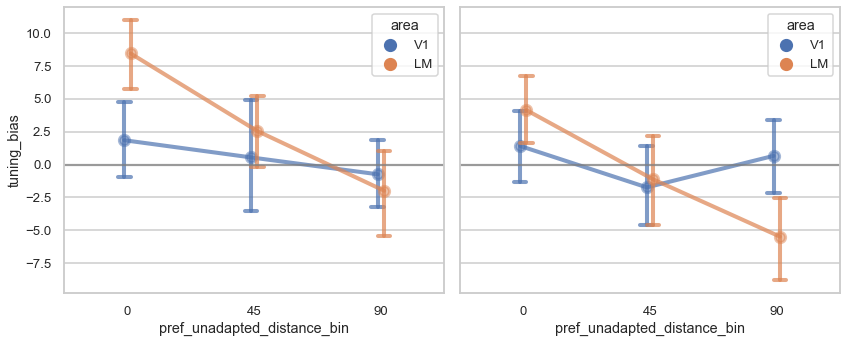

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

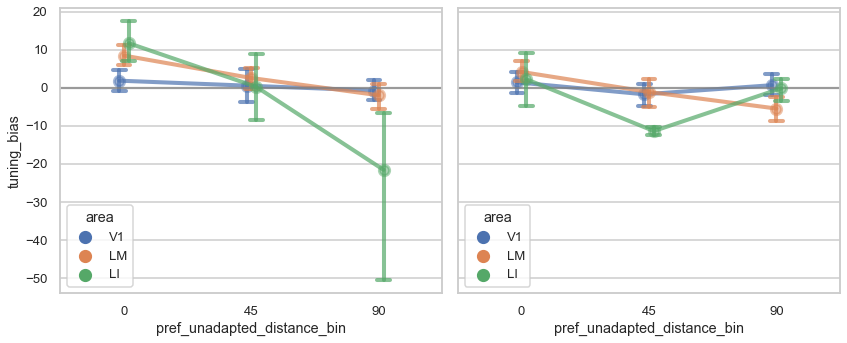

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_tuning_gOSI, hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_tuning_gOSI, hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

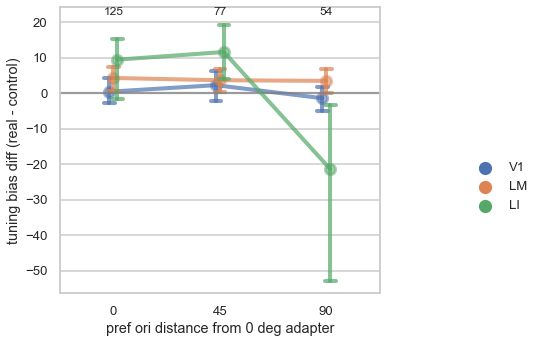

In [268]:
df_tuning_gOSI['tuning_bias_diff'] = df_tuning_gOSI['tuning_bias'] - df_tuning_gOSI['tuning_bias_control']

fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_tuning_gOSI, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_tuning_gOSI.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [31]:
## construct tuning_vec column

cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )
df_ori_mod

cell_id   isi                                         tuning_vec  \
0     200720_003_0   250  [0.016361998006661493, 0.010278129175002568, 0...   
1     200720_003_0   750  [0.025038532340778488, 0.027538047461942633, 0...   
2     200720_003_0  6000  [0.020152732636819985, -0.0013945580654881541,...   
3     200720_003_1   250  [0.036562610558938564, 0.057022308981587506, 0...   
4     200720_003_1   750  [0.050733120887446, 0.03534524443593661, 0.035...   
...            ...   ...                                                ...   
8962  230309_003_8   750  [0.010098233103305406, 0.00922235218530763, 0....   
8963  230309_003_8  6000  [-0.0007265278837471503, -0.010356049984017944...   
8964  230309_003_9   250  [0.002111642689842034, -0.03229428397250415, -...   
8965  230309_003_9   750  [-0.020504815243051422, -0.012417518632523836,...   
8966  230309_003_9  6000  [-0.004049473873904683, -0.01946705104685816, ...   

     area  filter_cell_vis  
0      V1             True  
1      V1             True  
2      V1             True  
3      V1            False  
4      V1            False  
...   ...              ...  
8962   LI            False  
8963   LI            False  
8964   LI            False  
8965   LI            False  
8966   LI            False  

[8967 rows x 5 columns]

In [32]:
## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

cell_id   isi                                         tuning_vec  \
0     200720_003_0   250  [0.016361998006661493, 0.010278129175002568, 0...   
1     200720_003_0   750  [0.025038532340778488, 0.027538047461942633, 0...   
2     200720_003_0  6000  [0.020152732636819985, -0.0013945580654881541,...   
3     200720_003_1   250  [0.036562610558938564, 0.057022308981587506, 0...   
4     200720_003_1   750  [0.050733120887446, 0.03534524443593661, 0.035...   
...            ...   ...                                                ...   
8962  230309_003_8   750  [0.010098233103305406, 0.00922235218530763, 0....   
8963  230309_003_8  6000  [-0.0007265278837471503, -0.010356049984017944...   
8964  230309_003_9   250  [0.002111642689842034, -0.03229428397250415, -...   
8965  230309_003_9   750  [-0.020504815243051422, -0.012417518632523836,...   
8966  230309_003_9  6000  [-0.004049473873904683, -0.01946705104685816, ...   

     area  filter_cell_vis  ori_mod  
0      V1             True    False  
1      V1             True     True  
2      V1             True     True  
3      V1            False    False  
4      V1            False    False  
...   ...              ...      ...  
8962   LI            False    False  
8963   LI            False    False  
8964   LI            False     True  
8965   LI            False    False  
8966   LI            False    False  

[8967 rows x 6 columns]

In [33]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
df_ori_mod.groupby('max_ori').max_ori_dist.unique()

max_ori
0     [0.0]
1    [22.5]
2    [45.0]
3    [67.5]
4    [90.0]
5    [67.5]
6    [45.0]
7    [22.5]
Name: max_ori_dist, dtype: object

In [34]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )
## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist']], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

## inherit tuning_vec from df_ori_mod, for each isi
df_lineplot = df_lineplot.merge(
      df_ori_mod
      [['cell_id', 'tuning_vec', 'isi']],
      on=['cell_id', 'isi'], how='left') # take tuning_vec from df_ori_mod, for each cell and isi

df_lineplot

dfof        cell_id area  filter_cell_vis resp_id   isi  \
0        0.000877   200720_003_0   V1             True      R2   750   
1       -0.055881   200720_003_0   V1             True      R2   250   
2        0.037413   200720_003_0   V1             True      R2   250   
3        0.512942   200720_003_0   V1             True      R2   750   
4        0.046603   200720_003_0   V1             True      R2  6000   
...           ...            ...  ...              ...     ...   ...   
1420146  0.074167  230309_003_32   LI            False      R2   750   
1420147 -0.023736  230309_003_32   LI            False      R2   750   
1420148  0.060245  230309_003_32   LI            False      R2   250   
1420149  0.009333  230309_003_32   LI            False      R2  6000   
1420150 -0.079758  230309_003_32   LI            False      R2   750   

         stim2_id  ori_mod  max_ori  max_ori_dist  \
0               5     True        4          90.0   
1               2     True        4          90.0   
2               2     True        4          90.0   
3               3     True        4          90.0   
4               2     True        4          90.0   
...           ...      ...      ...           ...   
1420146         6    False        5          67.5   
1420147         0    False        5          67.5   
1420148         1    False        5          67.5   
1420149         2    False        5          67.5   
1420150         6    False        5          67.5   

                                                tuning_vec  
0        [0.025038532340778488, 0.027538047461942633, 0...  
1        [0.016361998006661493, 0.010278129175002568, 0...  
2        [0.016361998006661493, 0.010278129175002568, 0...  
3        [0.025038532340778488, 0.027538047461942633, 0...  
4        [0.020152732636819985, -0.0013945580654881541,...  
...                                                    ...  
1420146  [-0.00018231075970984991, -0.01066406876792216...  
1420147  [-0.00018231075970984991, -0.01066406876792216...  
1420148  [0.027510405271565317, 0.009753824245836214, 0...  
1420149  [-0.04039721066009392, 0.005847991523749155, 0...  
1420150  [-0.00018231075970984991, -0.01066406876792216...  

[1420151 rows x 11 columns]

In [35]:
# for each cell_id, divide tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad

result = tmp - tmp_noad
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

0         1         2         3         4         5  \
cell_id      isi                                                                
200720_003_0 250  -0.003791  0.011673  0.033518 -0.012615 -0.032216 -0.022168   
             750   0.004886  0.028933  0.010938  0.076091  0.014486 -0.035019   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
200720_003_1 250   0.030914  0.049451  0.023036 -0.031079 -0.050838 -0.000731   
             750   0.045084  0.027774  0.037137  0.029714 -0.001707  0.023756   
...                     ...       ...       ...       ...       ...       ...   
230309_003_8 750   0.010825  0.019578 -0.018142 -0.121883 -0.017589  0.013620   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
230309_003_9 250   0.006161 -0.012827  0.012561  0.040171  0.047026 -0.037958   
             750  -0.016455  0.007050  0.000591 -0.025480  0.056306  0.007642   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                          6         7  \
cell_id      isi                        
200720_003_0 250  -0.027436 -0.012193   
             750  -0.034831 -0.028225   
             6000  0.000000  0.000000   
200720_003_1 250  -0.018446 -0.041205   
             750  -0.034462 -0.000538   
...                     ...       ...   
230309_003_8 750   0.001717  0.005170   
             6000  0.000000  0.000000   
230309_003_9 250   0.022852 -0.017974   
             750   0.017519  0.009197   
             6000  0.000000  0.000000   

                                                         tuning_diff  
cell_id      isi                                                      
200720_003_0 250   [-0.003790734630158492, 0.011672687240490722, ...  
             750   [0.004885799703958502, 0.028932605527430787, 0...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
200720_003_1 250   [0.030913819139125755, 0.04945062365731872, 0....  
             750   [0.04508432946763319, 0.027773559111667828, 0....  
...                                                              ...  
230309_003_8 750   [0.010824760987052555, 0.019578402169325576, -...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
230309_003_9 250   [0.006161116563746717, -0.012827232925645988, ...  
             750   [-0.01645534136914674, 0.007049532414334323, 0...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[8967 rows x 9 columns]

(-0.10174320629244175, 1.1575233159863254, 0.19320843091334894)

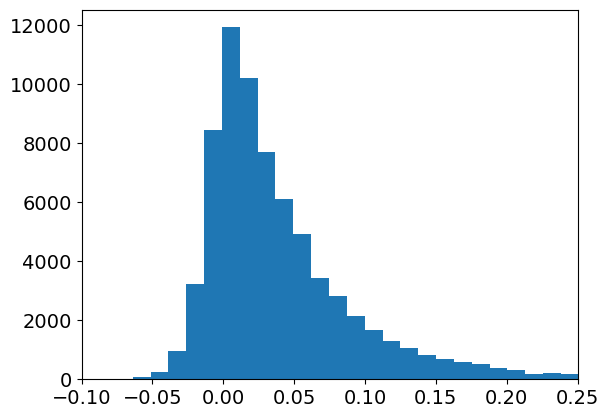

In [36]:
plt.hist(tmp_noad.values.flatten(), bins=100);
plt.xlim([-0.1, 0.25])

np.min(tmp_noad.values.flatten()), np.max(tmp_noad.values.flatten()), \
    sum(tmp_noad.values.flatten() < 0) / len(tmp_noad.values.flatten())

## tuning curve bias
no fitting, just align max response ori

In [37]:
## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.merge(
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

dfof        cell_id area  filter_cell_vis resp_id   isi  \
0        0.000877   200720_003_0   V1             True      R2   750   
1       -0.055881   200720_003_0   V1             True      R2   250   
2        0.037413   200720_003_0   V1             True      R2   250   
3        0.512942   200720_003_0   V1             True      R2   750   
4        0.046603   200720_003_0   V1             True      R2  6000   
...           ...            ...  ...              ...     ...   ...   
1420146  0.074167  230309_003_32   LI            False      R2   750   
1420147 -0.023736  230309_003_32   LI            False      R2   750   
1420148  0.060245  230309_003_32   LI            False      R2   250   
1420149  0.009333  230309_003_32   LI            False      R2  6000   
1420150 -0.079758  230309_003_32   LI            False      R2   750   

         stim2_id  ori_mod  max_ori  max_ori_dist  \
0               5     True        4          90.0   
1               2     True        4          90.0   
2               2     True        4          90.0   
3               3     True        4          90.0   
4               2     True        4          90.0   
...           ...      ...      ...           ...   
1420146         6    False        5          67.5   
1420147         0    False        5          67.5   
1420148         1    False        5          67.5   
1420149         2    False        5          67.5   
1420150         6    False        5          67.5   

                                                tuning_vec  \
0        [0.025038532340778488, 0.027538047461942633, 0...   
1        [0.016361998006661493, 0.010278129175002568, 0...   
2        [0.016361998006661493, 0.010278129175002568, 0...   
3        [0.025038532340778488, 0.027538047461942633, 0...   
4        [0.020152732636819985, -0.0013945580654881541,...   
...                                                    ...   
1420146  [-0.00018231075970984991, -0.01066406876792216...   
1420147  [-0.00018231075970984991, -0.01066406876792216...   
1420148  [0.027510405271565317, 0.009753824245836214, 0...   
1420149  [-0.04039721066009392, 0.005847991523749155, 0...   
1420150  [-0.00018231075970984991, -0.01066406876792216...   

                                               tuning_diff  
0        [0.004885799703958502, 0.028932605527430787, 0...  
1        [-0.003790734630158492, 0.011672687240490722, ...  
2        [-0.003790734630158492, 0.011672687240490722, ...  
3        [0.004885799703958502, 0.028932605527430787, 0...  
4                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
...                                                    ...  
1420146  [0.04021489990038407, -0.01651206029167132, -0...  
1420147  [0.04021489990038407, -0.01651206029167132, -0...  
1420148  [0.06790761593165924, 0.003905832722087059, 0....  
1420149           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1420150  [0.04021489990038407, -0.01651206029167132, -0...  

[1420151 rows x 12 columns]

In [49]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['sess'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot[df_lineplot.area == 'V1'].date.unique()

array(['200720', '200728', '200803', '201015', '201209', '210120'],
      dtype=object)

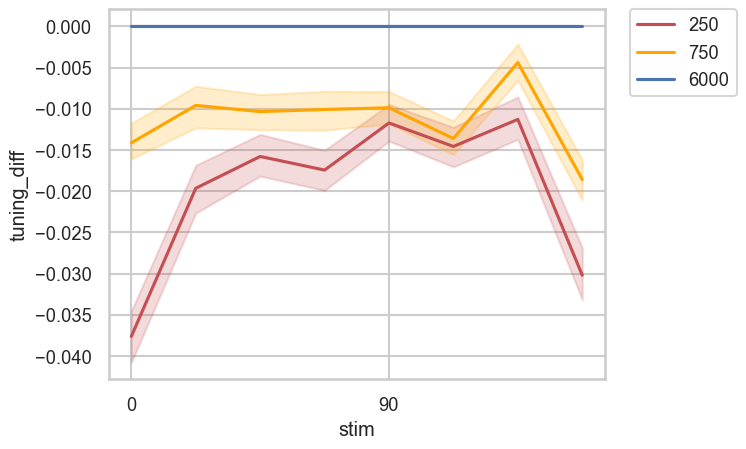

In [54]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                    #    & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LM')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]
# print(df_filter.groupby('max_ori').cell_id.nunique())
# 
df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff

## set sns color palette
sns.lineplot(data=df_tuning_diff, x='stim', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xticks([0, 4], ['0', '90'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

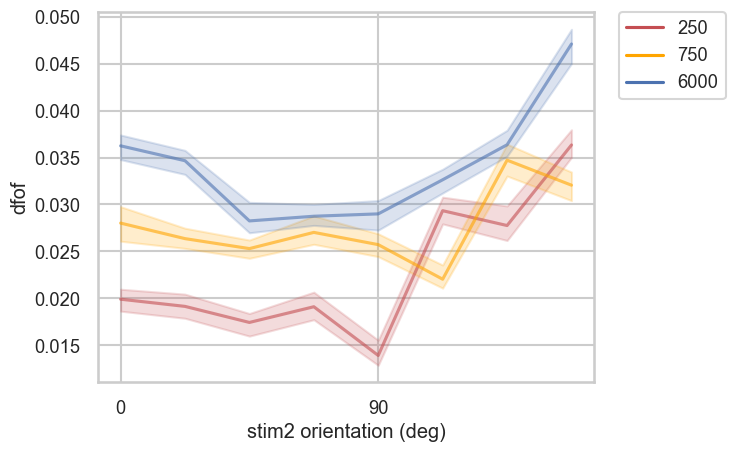

In [55]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.median, 
            palette=['r', 'orange', 'b'],)
plt.xticks([0, 4], ['0', '90'])
plt.xlabel('stim2 orientation (deg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

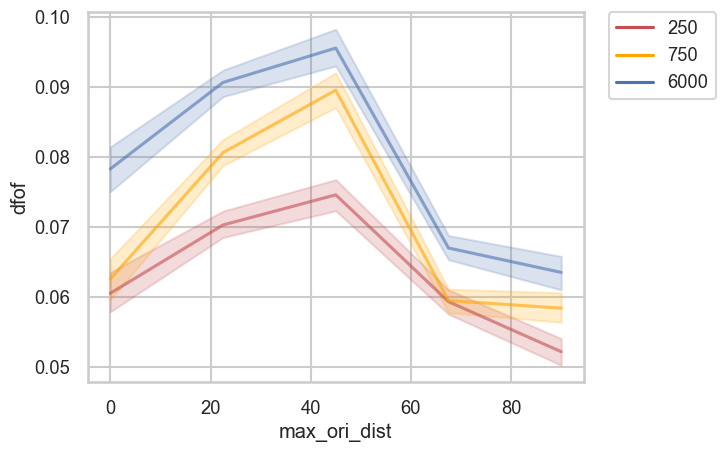

In [56]:
sns.lineplot(data=df_filter, x='max_ori_dist', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

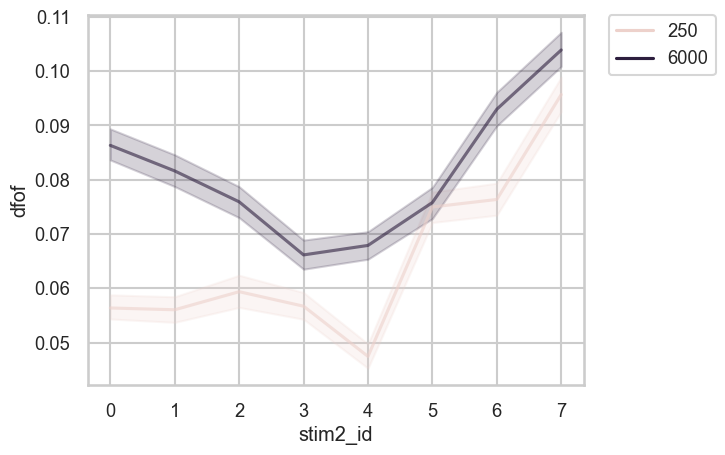

In [47]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'V1')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            # estimator=np.median
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, row="date", hue="isi")
# g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
# g.figure.subplots_adjust(wspace=0.1, hspace=0.3)
# g.add_legend();

# # set xticks to 0, 4
# for ax in g.axes.flat:
#     ax.set_xticks([0, 4])
#     ax.set_xticklabels(['0', '90'])


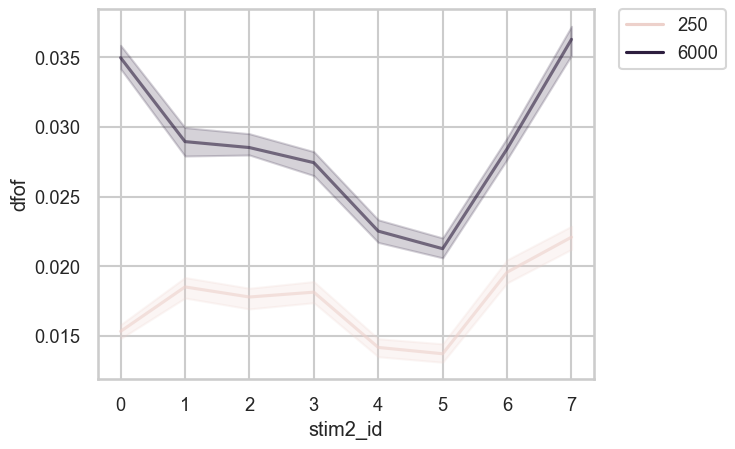

In [394]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LM')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, estimator=np.median)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

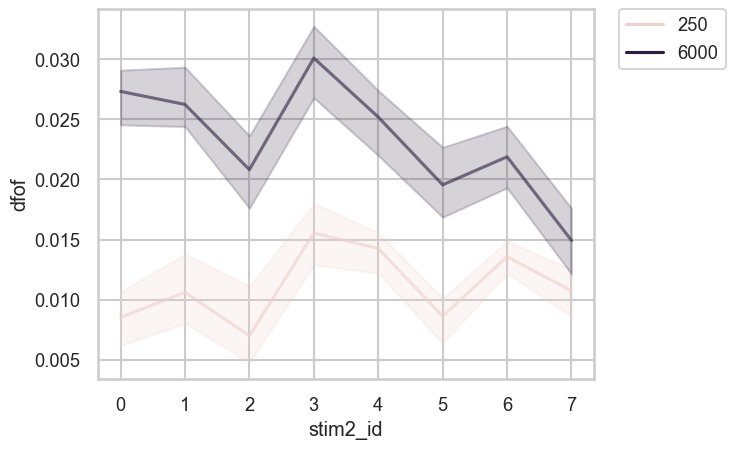

In [395]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LI')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, estimator=np.median)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Jin 2019 Fig 2

In [66]:
df_lineplot.area.unique()

array(['V1', 'LM', 'LI'], dtype=object)

In [76]:
## construct df for tuning_diff lineplot:
## for each cell_id, subtract tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp.head(6)

tmp_noad_shift = tmp.copy()
tmp_noad_shift['tuning_vec'] = tmp_noad_shift.tuning_vec.apply(lambda x: [min(x) for i in range(len(x))])
tmp_noad_shift.head(6)

tmp_noad_shift = (tmp_noad_shift.groupby(level=['cell_id']).transform('last')) # last isi is 6000
epsilon = 0.001
tmp_noad_shift.tuning_vec = tmp_noad_shift.tuning_vec.apply(lambda x: [-min(0, i) + epsilon for i in x])
tmp_noad_shift.head(6)

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp.head(6)
# plt.hist(tmp.values.flatten(), bins=100);
# min(tmp.values.flatten()), max(tmp.values.flatten())

tmp_noad_shift = tmp_noad_shift.tuning_vec.apply(pd.Series)
tmp_noad_shift.head(6)

tmp = tmp + tmp_noad_shift # shift tuning_vec of all isi by min(tuning_vec) of isi 6000
tmp.head(6)

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad.head(6)

result = tmp / tmp_noad
result
# plt.hist(result.values.flatten(), bins=100);
# min(result.values.flatten()), max(result.values.flatten())

thresh = 5
result = result.applymap(lambda x: x if abs(x) < thresh else np.nan) # threshold too large values - change to nan
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_diff'].merge( # prevent duplicate column
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

dfof        cell_id area  filter_cell_vis resp_id   isi  \
0        0.000877   200720_003_0   V1             True      R2   750   
1       -0.055881   200720_003_0   V1             True      R2   250   
2        0.037413   200720_003_0   V1             True      R2   250   
3        0.512942   200720_003_0   V1             True      R2   750   
4        0.046603   200720_003_0   V1             True      R2  6000   
...           ...            ...  ...              ...     ...   ...   
1420146  0.074167  230309_003_32   LI            False      R2   750   
1420147 -0.023736  230309_003_32   LI            False      R2   750   
1420148  0.060245  230309_003_32   LI            False      R2   250   
1420149  0.009333  230309_003_32   LI            False      R2  6000   
1420150 -0.079758  230309_003_32   LI            False      R2   750   

         stim2_id  ori_mod  max_ori  max_ori_dist  \
0               5     True        4          90.0   
1               2     True        4          90.0   
2               2     True        4          90.0   
3               3     True        4          90.0   
4               2     True        4          90.0   
...           ...      ...      ...           ...   
1420146         6    False        5          67.5   
1420147         0    False        5          67.5   
1420148         1    False        5          67.5   
1420149         2    False        5          67.5   
1420150         6    False        5          67.5   

                                                tuning_vec    date sess  \
0        [0.025038532340778488, 0.027538047461942633, 0...  200720  003   
1        [0.016361998006661493, 0.010278129175002568, 0...  200720  003   
2        [0.016361998006661493, 0.010278129175002568, 0...  200720  003   
3        [0.025038532340778488, 0.027538047461942633, 0...  200720  003   
4        [0.020152732636819985, -0.0013945580654881541,...  200720  003   
...                                                    ...     ...  ...   
1420146  [-0.00018231075970984991, -0.01066406876792216...  230309  003   
1420147  [-0.00018231075970984991, -0.01066406876792216...  230309  003   
1420148  [0.027510405271565317, 0.009753824245836214, 0...  230309  003   
1420149  [-0.04039721066009392, 0.005847991523749155, 0...  230309  003   
1420150  [-0.00018231075970984991, -0.01066406876792216...  230309  003   

                                               tuning_diff  
0        [1.2166912099757665, nan, 1.4257613946367818, ...  
1        [0.8318762692951647, nan, 2.3047409011535818, ...  
2        [0.8318762692951647, nan, 2.3047409011535818, ...  
3        [1.2166912099757665, nan, 1.4257613946367818, ...  
4                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  
...                                                    ...  
1420146  [nan, 0.6505029182133945, -0.9093955642052809,...  
1420147  [nan, 0.6505029182133945, -0.9093955642052809,...  
1420148  [nan, 1.0826715209491216, 1.0962224815562718, ...  
1420149           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  
1420150  [nan, 0.6505029182133945, -0.9093955642052809,...  

[1420151 rows x 14 columns]

In [94]:
df_filter = df_lineplot[(df_lineplot.area == 'V1')
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]
# df_filter

df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff['ori_dist'] = df_tuning_diff.stim.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells
df_tuning_diff

## inherit max_ori from df_lineplot
df_tuning_diff = df_tuning_diff.merge(df_filter[['cell_id', 'isi', 'max_ori', 'max_ori_dist']], on=['cell_id', 'isi'], how='inner')
df_tuning_diff = df_tuning_diff.drop_duplicates() # TODO: why are there duplicates?
df_tuning_diff

cell_id   isi  stim  tuning_diff  ori_dist  max_ori  max_ori_dist
0       200720_003_0   250     0     0.831876       0.0        4          90.0
149     200720_003_0   250     1          NaN      22.5        4          90.0
298     200720_003_0   250     2     2.304741      45.0        4          90.0
447     200720_003_0   250     3     0.857256      67.5        4          90.0
596     200720_003_0   250     4     0.638013      90.0        4          90.0
...              ...   ...   ...          ...       ...      ...           ...
966835  210120_003_8  6000     3     1.000000      67.5        7          22.5
966972  210120_003_8  6000     4     1.000000      90.0        7          22.5
967109  210120_003_8  6000     5     1.000000      67.5        7          22.5
967246  210120_003_8  6000     6     1.000000      45.0        7          22.5
967383  210120_003_8  6000     7     1.000000      22.5        7          22.5

[6264 rows x 7 columns]

In [95]:
df_tuning_diff.cell_id.nunique() # how many cells

261

In [96]:
## map with dict
ori_dist_bin = {0:0, 
                22.5:45,
                45:45,
                67.5:90,
                90:90,}

df_tuning_diff['ori_dist_bin'] = df_tuning_diff.ori_dist.map(ori_dist_bin)
df_tuning_diff['max_ori_dist_bin'] = df_tuning_diff.max_ori_dist.map(ori_dist_bin)

df_tuning_diff

cell_id   isi  stim  tuning_diff  ori_dist  max_ori  \
0       200720_003_0   250     0     0.831876       0.0        4   
149     200720_003_0   250     1          NaN      22.5        4   
298     200720_003_0   250     2     2.304741      45.0        4   
447     200720_003_0   250     3     0.857256      67.5        4   
596     200720_003_0   250     4     0.638013      90.0        4   
...              ...   ...   ...          ...       ...      ...   
966835  210120_003_8  6000     3     1.000000      67.5        7   
966972  210120_003_8  6000     4     1.000000      90.0        7   
967109  210120_003_8  6000     5     1.000000      67.5        7   
967246  210120_003_8  6000     6     1.000000      45.0        7   
967383  210120_003_8  6000     7     1.000000      22.5        7   

        max_ori_dist  ori_dist_bin  max_ori_dist_bin  
0               90.0             0                90  
149             90.0            45                90  
298             90.0            45                90  
447             90.0            90                90  
596             90.0            90                90  
...              ...           ...               ...  
966835          22.5            90                45  
966972          22.5            90                45  
967109          22.5            90                45  
967246          22.5            45                45  
967383          22.5            45                45  

[6264 rows x 9 columns]

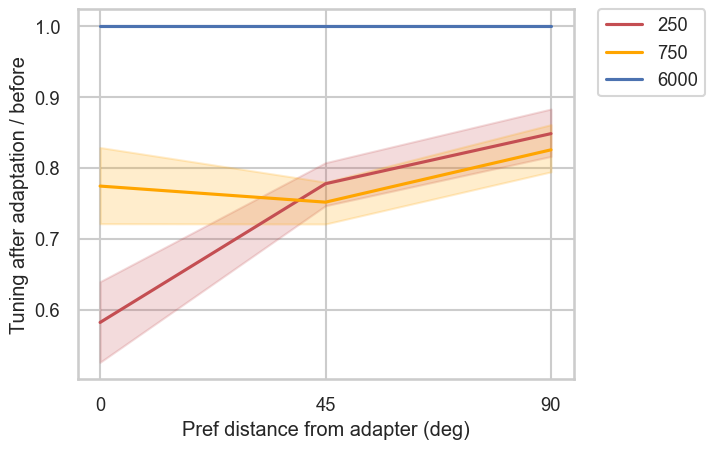

In [97]:
tmp = df_tuning_diff[df_tuning_diff.max_ori == df_tuning_diff.stim] # only take rows with max ori = stim2 ori
tmp

sns.lineplot(data=tmp, x='max_ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )

# set xticks 0, 45, 90
plt.xticks([0, 45, 90], [0, 45, 90])

plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'Fig2E Jin2019.pdf', bbox_inches='tight')

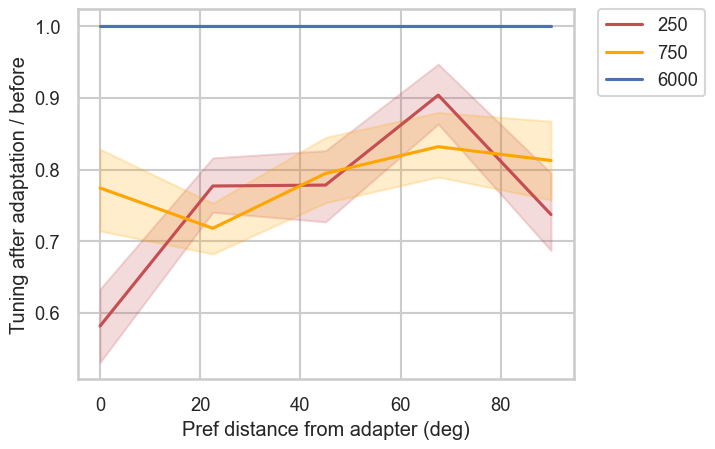

In [98]:
sns.lineplot(data=tmp, x='max_ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning_diff_lineplot_binned.pdf', bbox_inches='tight')

In [89]:
sns.lineplot(data=df_tuning_diff, x='ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning vs stim2_binned-adapter dist.pdf', bbox_inches='tight')

In [90]:
## set sns color palette
sns.lineplot(data=df_tuning_diff, x='ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# # plt.savefig(dir_fig + 'tuning vs stim2-adapter dist.pdf', bbox_inches='tight')
# plt.savefig(dir_fig + 'Fig2D Jin2019.pdf', bbox_inches='tight')

## facet grid

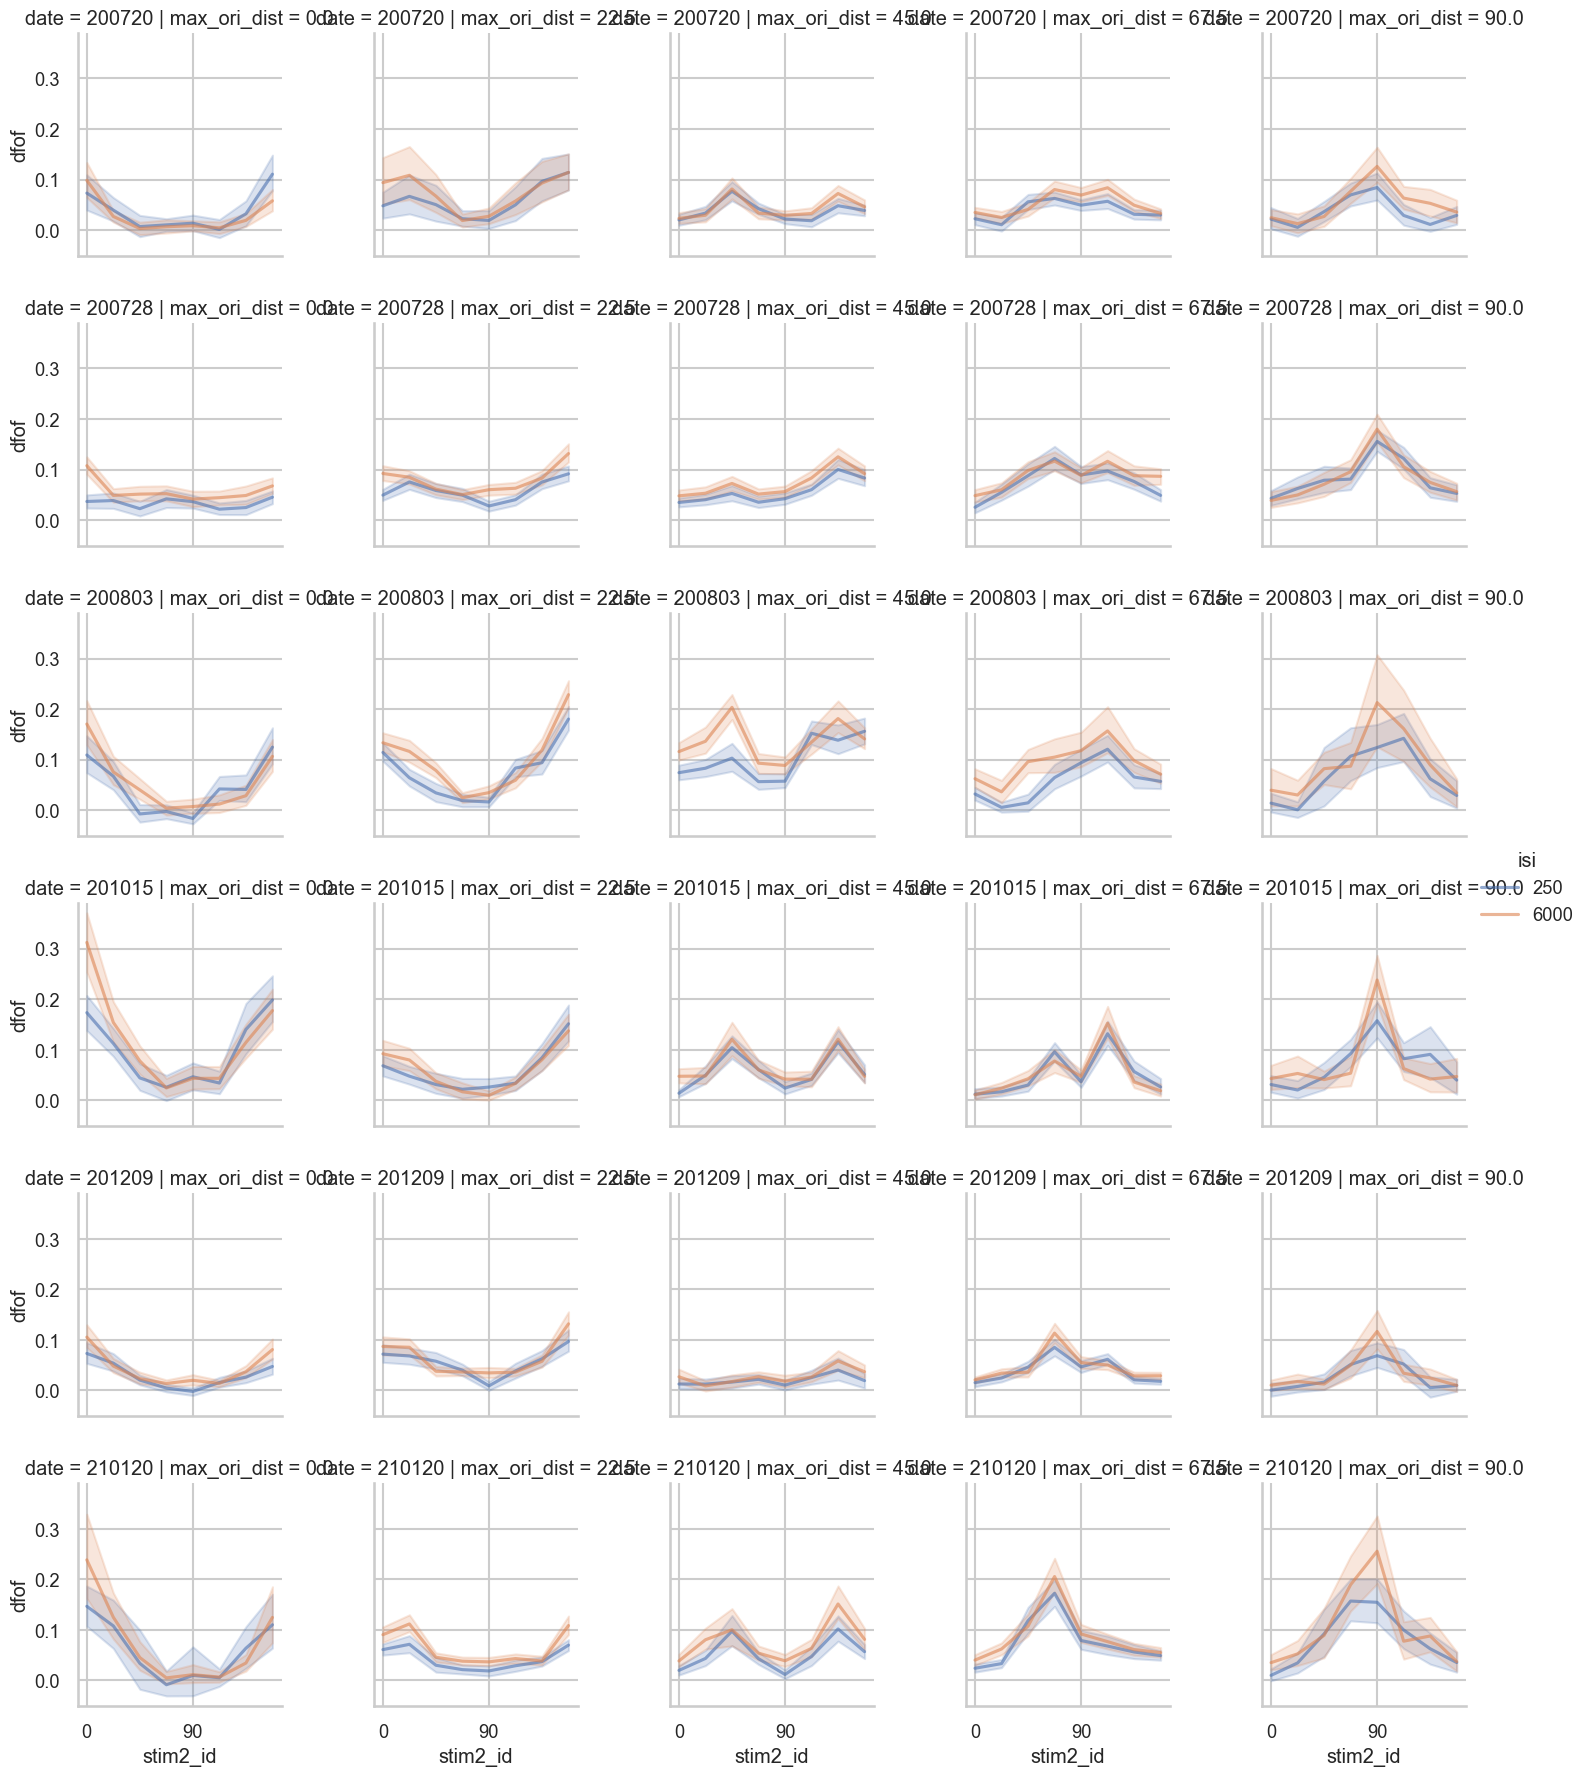

In [378]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                      #  & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'V1')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori_dist", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori_dist", row="date", hue="isi")
# g = sns.FacetGrid(df_filter, col="date", row="max_ori_dist", hue="isi") # which date has the most outrageous adp at orthogonal ori relative to adapter ori
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.45, hspace=0.3)
g.add_legend();

# set xticks to 0, 4
for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])


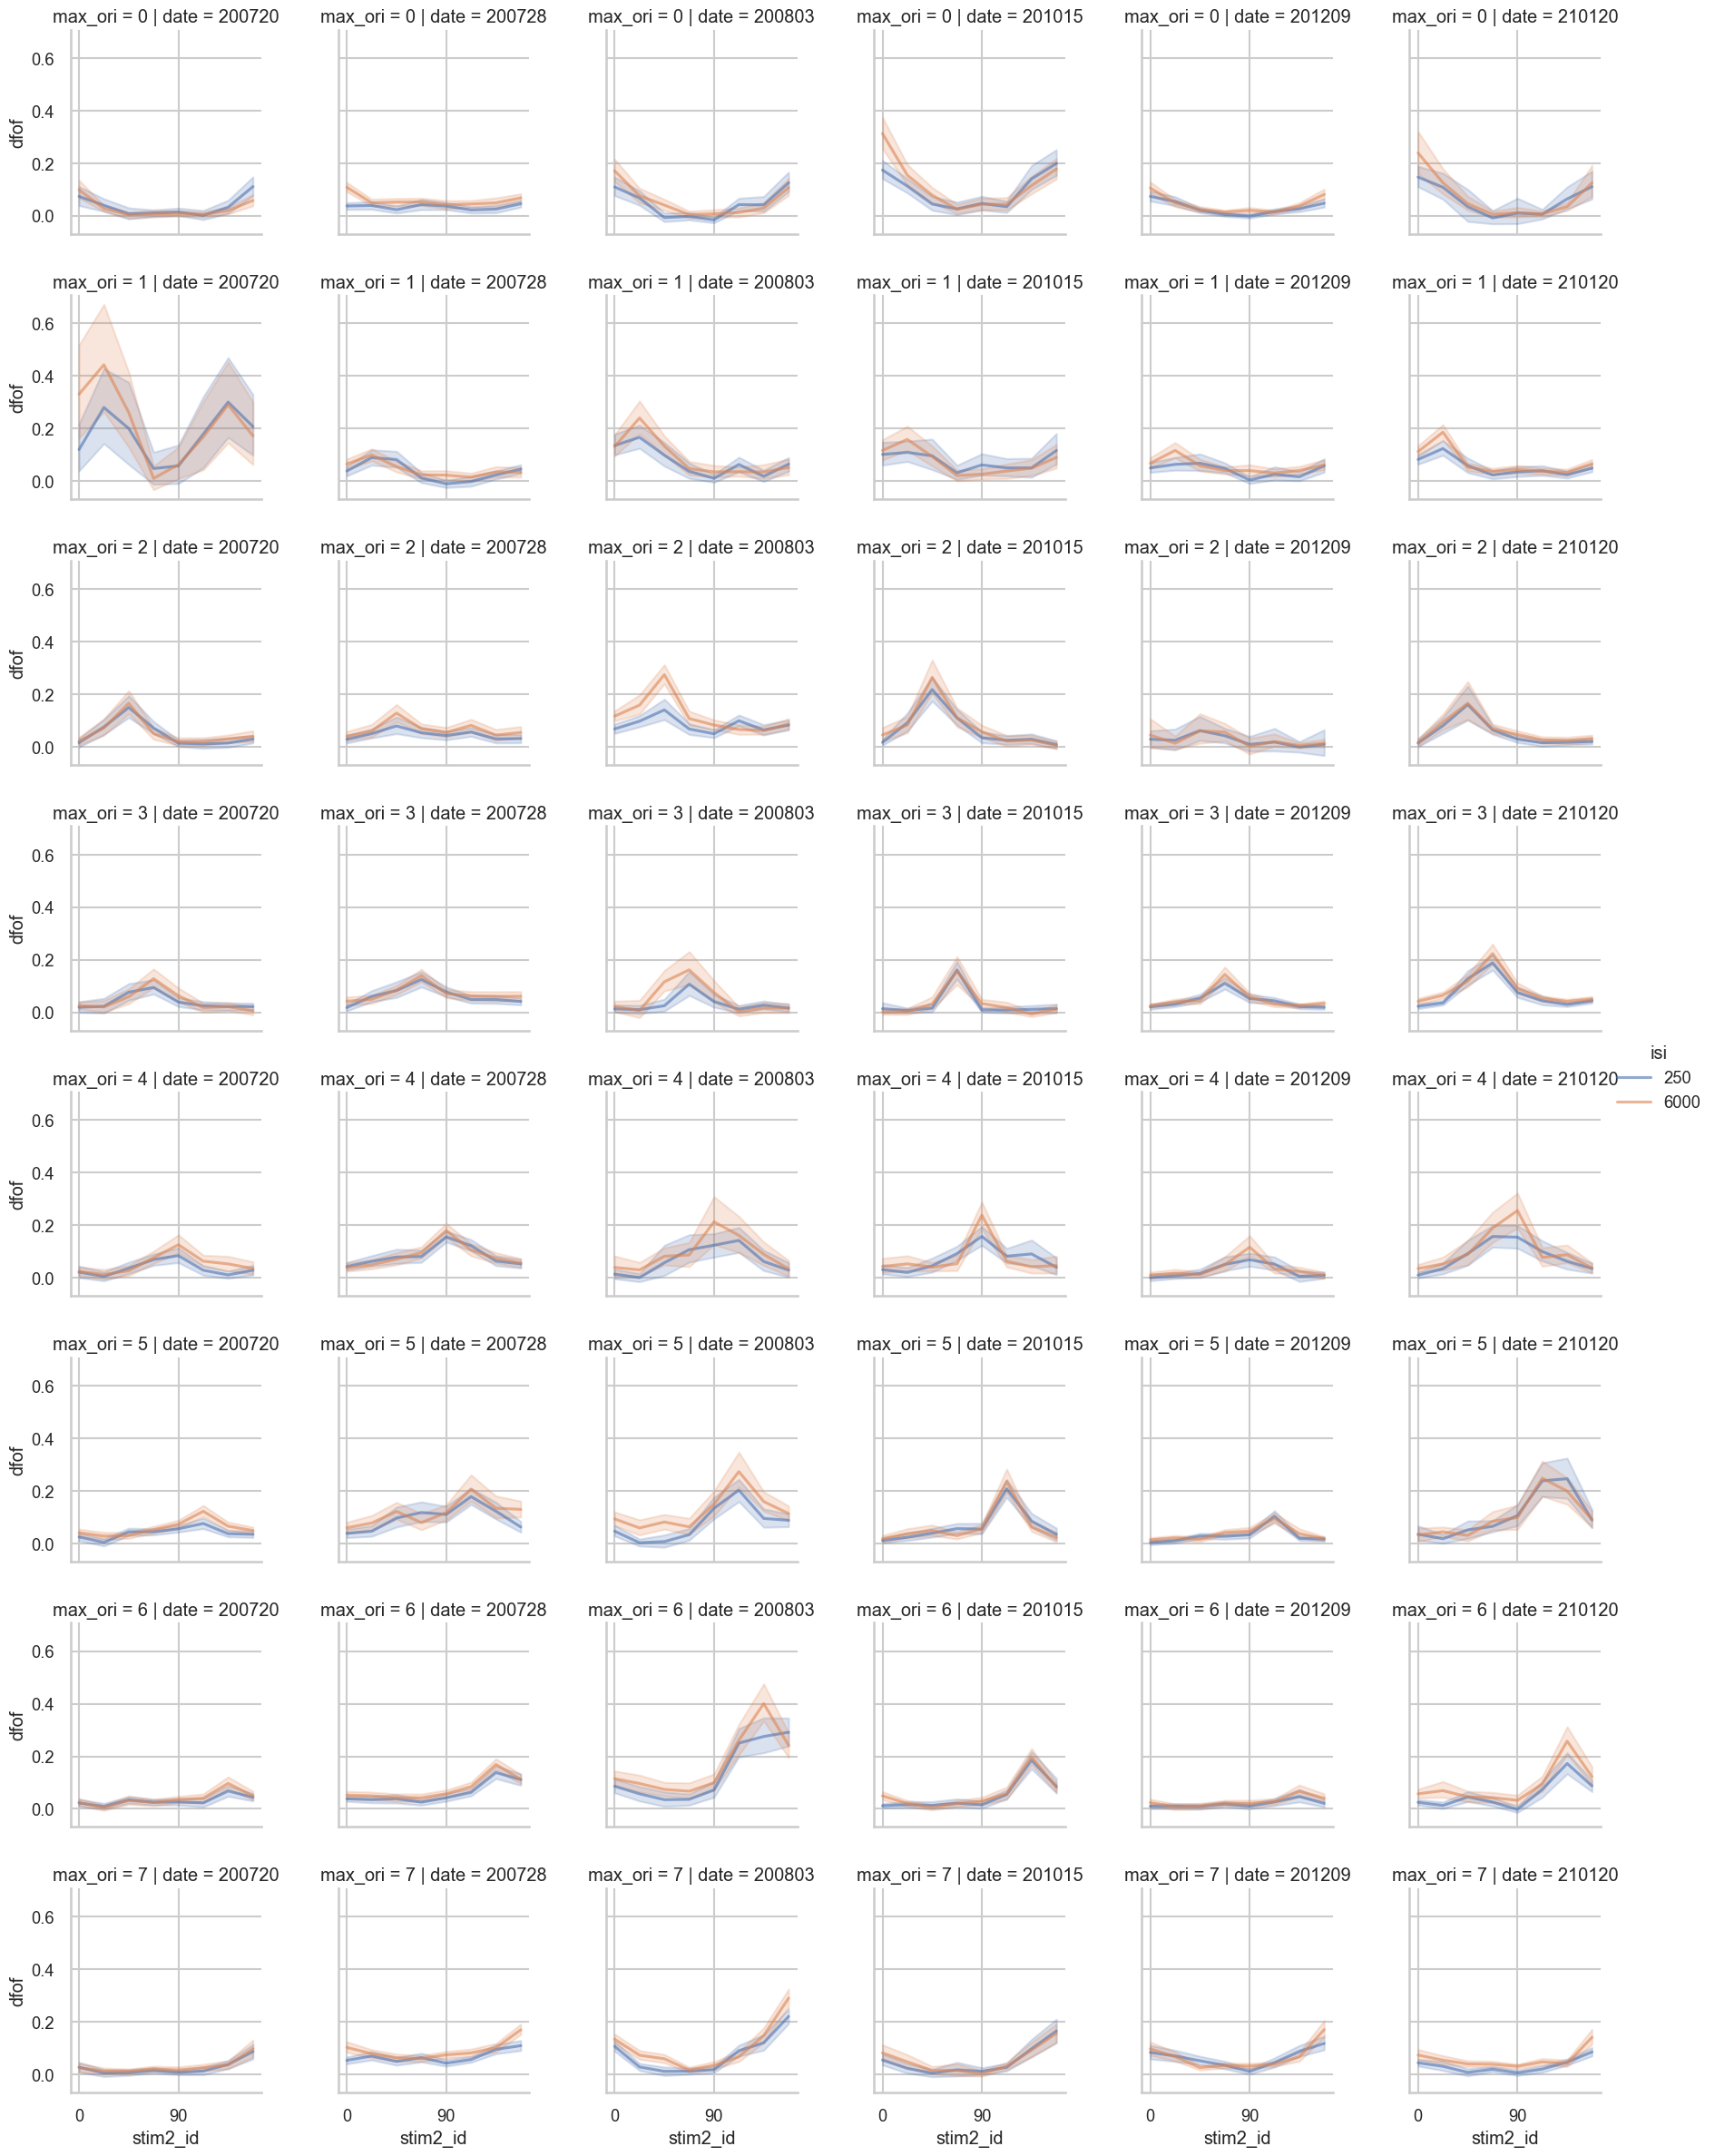

In [379]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g = sns.FacetGrid(df_filter, col="date", row="max_ori", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

dir_result = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check'.replace('\\', os.sep)
g.savefig(os.path.join(dir_result, 'tuning_before_vs_after_adp.pdf'), bbox_inches='tight')

# san check
what can generate possibly fake adp when adapter vs target are orthogonal?  
check if bin=90 tuning curve is real: plot timecourse for stim2=90, noad vs 250

In [335]:
df_test = df_lineplot[(df_lineplot.date == '210120')] # use this date and sess for sanity check
df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id
df_test

C:\Users\ll357\AppData\Local\Temp\6\ipykernel_43944\1917010594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id


dfof cell_id area  filter_cell_vis resp_id   isi  stim2_id  \
241305 -0.059959       0   V1             True      R2   250         4   
241306 -0.066803       0   V1             True      R2   250         3   
241307  0.055740       0   V1             True      R2  6000         4   
241308 -0.104743       0   V1             True      R2   250         0   
241309  0.035202       0   V1             True      R2   750         4   
...          ...     ...  ...              ...     ...   ...       ...   
270068 -0.015048      61   V1             True      R2   250         5   
270069  0.027682      61   V1             True      R2   750         2   
270070  0.091247      61   V1             True      R2   750         1   
270071 -0.030568      61   V1             True      R2   250         0   
270072  0.111430      61   V1             True      R2   750         2   

        ori_mod  max_ori  max_ori_dist    date sess  
241305    False        1          22.5  210120  003  
241306    False        1          22.5  210120  003  
241307    False        1          22.5  210120  003  
241308    False        1          22.5  210120  003  
241309    False        1          22.5  210120  003  
...         ...      ...           ...     ...  ...  
270068     True        6          45.0  210120  003  
270069     True        6          45.0  210120  003  
270070     True        6          45.0  210120  003  
270071     True        6          45.0  210120  003  
270072     True        6          45.0  210120  003  

[28768 rows x 12 columns]

In [369]:
df_filter = df_test[(df_test.filter_cell_vis == True)
                    # & (df_test.ori_mod == True)
                    & (df_test.isi != 750)
                    ]
df_filter.cell_id.nunique(), df_test.cell_id.nunique()

cell_id_bool = pd.DataFrame(df_test.cell_id.astype(int).unique()).isin(df_filter.cell_id.astype(int).unique())
cell_id_bool.head(20) # whether this cell passes the filter (vis and ori_mod)
cell_id_bool = cell_id_bool.values.astype(int).flatten()
cell_id_bool

import scipy.io as sio
dir_mat = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# sio.savemat(dir_mat+'vis_orimod_cell_bool.mat', {'vis_orimod_cell_bool': cell_id_bool})
sio.savemat(dir_mat+'vis_cell_bool.mat', {'vis_cell_bool': cell_id_bool}) # if only filter by vis, not ori_mod

# decorrelation
cosine similarity

In [1052]:
## suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

df_decorr = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 
                    'area', 'mouse', 'date', 'sess'
                    ]]

df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                          # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
df_decorr['date_sess'] = df_decorr.date + '_' + df_decorr.sess

current_area = 'V1'
df_decorr = df_decorr[(df_decorr.isi != 750)
                      & (df_decorr.filter_cell_vis == True)
                      # & (df_decorr.filter_cell_stim == True)
                      # & (df_decorr.filter_cell_well_fit == True)
                      & (df_decorr.resp_id == 'R2')
                      & (df_decorr.area == current_area)
                    ]

df_decorr

dfof        cell_id resp_id   isi  stim2_id  filter_cell_vis  \
33064  -0.055881   200720_003_0      R2   250         2             True   
33065   0.037413   200720_003_0      R2   250         2             True   
33067   0.046603   200720_003_0      R2  6000         2             True   
33069  -0.096475   200720_003_0      R2   250         7             True   
33071   0.133746   200720_003_0      R2   250         4             True   
...          ...            ...     ...   ...       ...              ...   
459054  0.096986  210120_003_61      R2   250         0             True   
459055 -0.048658  210120_003_61      R2   250         4             True   
459056  0.136464  210120_003_61      R2  6000         1             True   
459058 -0.015048  210120_003_61      R2   250         5             True   
459061 -0.030568  210120_003_61      R2   250         0             True   

        filter_cell_stim  filter_cell_well_fit area mouse    date sess  \
33064              False                   1.0   V1  1323  200720  003   
33065              False                   1.0   V1  1323  200720  003   
33067              False                   1.0   V1  1323  200720  003   
33069              False                   1.0   V1  1323  200720  003   
33071               True                   1.0   V1  1323  200720  003   
...                  ...                   ...  ...   ...     ...  ...   
459054             False                   1.0   V1  1337  210120  003   
459055             False                   1.0   V1  1337  210120  003   
459056             False                   1.0   V1  1337  210120  003   
459058             False                   1.0   V1  1337  210120  003   
459061             False                   1.0   V1  1337  210120  003   

        stim2_dist   date_sess  
33064         45.0  200720_003  
33065         45.0  200720_003  
33067         45.0  200720_003  
33069         22.5  200720_003  
33071         90.0  200720_003  
...            ...         ...  
459054         0.0  210120_003  
459055        90.0  210120_003  
459056        22.5  210120_003  
459058        67.5  210120_003  
459061         0.0  210120_003  

[138219 rows x 14 columns]

## decorr from self
before vs after adp

In [467]:
cos_sim_sets = []
for iset in tqdm(df_decorr.date_sess.unique()):
    # print(iset)
    
    df_pop_vec = (df_decorr[df_decorr.date_sess == iset]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.mean().reset_index()
                  .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                )
    nori = df_decorr.stim2_dist.nunique()
    
    cos_sim_iset = []
    for iori in range(nori):
        pop_vec_ref = df_pop_vec.iloc[nori + iori, :].values # ref is the same ori, but before adp (isi=6000)
        pop_vec_ori = df_pop_vec.iloc[iori, :].values # pop vec after adp (isi=250)
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_iset.append(cos_sim)
    cos_sim_sets.append(cos_sim_iset)
    
len(cos_sim_sets), len(cos_sim_sets[0]) # n of recording, n of self-decorrelation pairs (nori)

100%|██████████| 6/6 [00:00<00:00, 23.57it/s]


(6, 5)

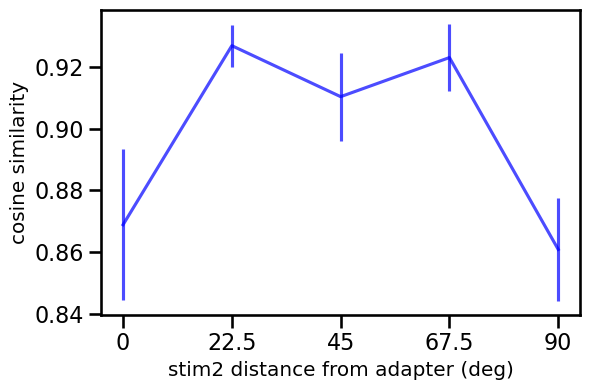

In [468]:
cos_sim_sets = np.array(cos_sim_sets)
cos_sim_sets_avg = np.nanmean(cos_sim_sets, axis=0) # across recordings
cos_sim_sets_sem = np.nanstd(cos_sim_sets, axis=0) / np.sqrt(cos_sim_sets.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
ax.errorbar(x=np.arange(len(cos_sim_sets_avg)),
               y=cos_sim_sets_avg,
               yerr=cos_sim_sets_sem,
               color='blue', # label='isi 250', 
               alpha=0.7)

# ax.legend(frameon=False, loc='lower center')
ax.set_xlabel('stim2 distance from adapter (deg)');
ax.set_ylabel('cosine similarity')
ax.set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

fig.tight_layout();
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=self before adp'.replace('\\', os.sep)
fig_name = 'decorr_from_self_after_adp_' + current_area + '.pdf'
plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## decorr from ref repre

In [1044]:
(df_tidy[(df_tidy.filter_cell_vis == True)
        #  & (df_tidy.filter_cell_well_fit == True)
         ]
        .groupby('area')
        .cell_id.nunique())

area
LI     288
LM    1098
V1     460
Name: cell_id, dtype: int64

In [ ]:
''' 
if resample cells without affecting trials: 
1. groupby cell_id, then sample n cells. set cell_id as index, use df.reindex(cell_id) to get the resampled df
2. set cell_id as index in df_decorr, df_decorr[df_decorr.cell_id.isin(subsample_cell)] -> df.reindex
3. df_pop_vec. ... .groupby, reset_index, sample n cells, pivot_table
'''

In [1053]:
## bootstrap resample cells to get error bar

nboot = 100
# subsample_cell_ratio = 0.7
# ncell_subsample = (df_tidy[(df_tidy.filter_cell_vis == True)]
#                    .groupby('area')
#                    .cell_id.nunique()
#                    .min()) # min ncells across areas - determine subsample size
cos_sim_boots = []

for iboot in tqdm(range(nboot)):
    
    np.random.seed(iboot)
    subsample_cell = np.random.choice(df_decorr.cell_id.unique(), 
                                    #   size=int(subsample_cell_ratio*df_decorr.cell_id.nunique()), 
                                    #   size=ncell_subsample,
                                      size=df_decorr.cell_id.nunique(), 
                                      replace=True)
    
    # df_pop_vec = df_decorr.sample(frac=1, 
    #                               replace=True, 
    #                               random_state=iboot) # resample cellxtrial (row-wise) with replacement, same size as original
    
    df_pop_vec = (df_decorr # [df_decorr.cell_id.isin(subsample_cell)]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
                  .groupby(['isi', 'stim2_dist'])
                  .sample(frac=3, replace=True, random_state=iboot) # resample cells with replacement in each cond
                  .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                  .fillna(0) # fill nan with 0, bc some cells are not sampled in some conditions
                )
    nori = df_decorr.stim2_dist.nunique()
    nisi_now = df_decorr.isi.nunique() # discarded isi 750

    cos_sim_iboot = []
    for iisi in range(nisi_now):
        if iisi == 0:
            # iref = 0
            iref = 4
        elif iisi == 1:
            # iref = nori
            iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
        pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
        
        for iori in range(nori):
            irow = iisi * nori + iori
            pop_vec_ori = df_pop_vec.iloc[irow, :].values
            cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
            cos_sim_iboot.append(cos_sim)
    cos_sim_boots.append(cos_sim_iboot)
    
len(cos_sim_boots), len(cos_sim_boots[0]) # n of boot, n of decorrelation pairs (nisi * nori)

100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


(100, 10)

In [1011]:
# tmp = (df_decorr # [df_decorr.cell_id.isin(subsample_cell)]
#         .groupby(['isi', 'stim2_dist', 'cell_id'])
#         .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
#         .groupby(['isi', 'stim2_dist'])
#         .sample(frac=4/122, replace=True, random_state=0) # resample cells with replacement, same size as original
#         .groupby(['isi', 'stim2_dist'])
#         # .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
#         )
# tmp#.cell_id.nunique(), df_decorr.cell_id.nunique()

# for key, group in tmp:
#     # print(key)
#     # print(group)
#     break
# group.cell_id.nunique(), df_decorr.cell_id.nunique()
# group

isi  stim2_dist        cell_id      dfof
44   250         0.0  210203_003_21  0.025144
47   250         0.0  210203_003_30  0.015220
117  250         0.0   230228_003_4 -0.011095
64   250         0.0  230110_002_32  0.025775

In [603]:
## separate recordings to get error bar

# cos_sim_sets = []
# for iset in tqdm(df_decorr.date_sess.unique()):
#     # print(iset)
    
#     df_pop_vec = (df_decorr[df_decorr.date_sess == iset]
#                   .groupby(['isi', 'stim2_dist', 'cell_id'])
#                   .dfof.mean().reset_index()
#                   .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
#                 )
#     nori = df_decorr.stim2_dist.nunique()
#     nisi_now = df_decorr.isi.nunique() # discarded isi 750

#     cos_sim_iset = []
#     for iisi in range(nisi_now):
#         if iisi == 0:
#             iref = 0
#             # iref = 4
#         elif iisi == 1:
#             iref = nori
#             # iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
#         pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
        
#         for iori in range(nori):
#             irow = iisi * nori + iori
#             pop_vec_ori = df_pop_vec.iloc[irow, :].values
#             cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
#             cos_sim_iset.append(cos_sim)
#     cos_sim_sets.append(cos_sim_iset)
    
# len(cos_sim_sets), len(cos_sim_sets[0]) # n of recording, n of decorrelation pairs (nisi * nori)

100%|██████████| 18/18 [00:00<00:00, 33.49it/s]


(18, 10)

In [863]:
# ## save boot
# # V1_decorr_boot = cos_sim_boots.copy()
# # LM_decorr_boot = cos_sim_boots.copy()
# # LI_decorr_boot = cos_sim_boots.copy()

# # decorr_boot = {'V1_decorr_boot': V1_decorr_boot,
# #                'LM_decorr_boot': LM_decorr_boot,
# #                'LI_decorr_boot': LI_decorr_boot,}

# # import pickle
# # pickle_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
# # pickle_name = 'decorr_vs_stim2_dist_errorbar_bootstrap_CI_' + '.pickle'
# # with open(os.path.join(pickle_dir, pickle_name), 'wb') as handle:
# #     pickle.dump(decorr_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# ## load boot
# with open(os.path.join(pickle_dir, pickle_name), 'rb') as handle:
#     decorr_boot = pickle.load(handle)
# decorr_boot.keys()

# V1_decorr_boot = decorr_boot['V1_decorr_boot']
# LM_decorr_boot = decorr_boot['LM_decorr_boot']
# LI_decorr_boot = decorr_boot['LI_decorr_boot']

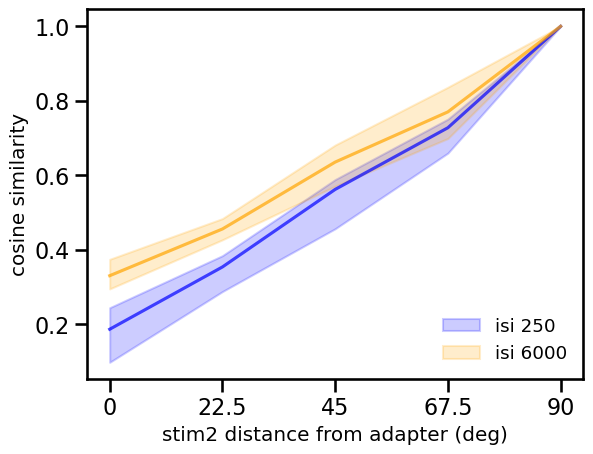

In [1054]:
cos_sim_sets = np.array(cos_sim_boots)
cos_sim_sets_avg = np.mean(cos_sim_sets, axis=0) # across boots

perc = 2.5
plt.plot(cos_sim_sets_avg[:nori], color='blue', alpha=0.7)
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[:nori],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[:nori],
                label='isi 250',
                color='blue', alpha=0.2)

plt.plot(cos_sim_sets_avg[nori:], color='orange', alpha=0.7)
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[nori:],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[nori:],
                label='isi 6000',
                color='orange', alpha=0.2);
plt.legend(frameon=False, loc='lower right')

# ## annotate significance
# for iori in np.arange(nori)[:-1]: # exclude 90 deg
#     plt.annotate(sig_star_list[iori], xy=(iori, 1), fontsize=12, ha='center', va='center')

# plt.ylim(0.2, 1.05)
plt.xlabel('stim2 distance from adapter (deg)');
plt.ylabel('cosine similarity')
plt.xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

fig.tight_layout();
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = f'decorr_fixed_resample_boot_CI{int(100-2*perc)}_median_' + current_area + '.pdf'
plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### decorr vs stim2_ori

In [397]:
df_pop_vec = (df_decorr.groupby(['isi', 'stim2_id', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_id'], columns='cell_id', values='dfof')
                )
df_pop_vec

cell_id        200723_003_1  200723_003_10  200723_003_11  200723_003_12  \
isi  stim2_id                                                              
250  0            -0.005401       0.007648       0.038531       0.011697   
     1            -0.020624      -0.019151      -0.015456      -0.015368   
     2            -0.007372       0.019836       0.098756       0.040590   
     3             0.063277       0.025829       0.040016      -0.029502   
     4             0.119146       0.001094       0.017127       0.011128   
     5             0.048175       0.032663       0.008627       0.040453   
     6             0.049623       0.059203       0.016605       0.015589   
     7            -0.025040       0.014491      -0.030827       0.034537   
6000 0            -0.004944       0.091272      -0.022213       0.043560   
     1             0.070847       0.062880       0.027504      -0.007658   
     2             0.078720       0.028448       0.171627       0.034132   
     3             0.080553       0.052082       0.114251       0.050209   
     4             0.064168       0.045880       0.047818       0.020374   
     5             0.105954       0.025416       0.005282       0.042583   
     6             0.082480       0.058769       0.002543       0.039387   
     7             0.051929       0.091695       0.000104       0.024366   

cell_id        200723_003_14  200723_003_15  200723_003_16  200723_003_18  \
isi  stim2_id                                                               
250  0             -0.008486       0.046037       0.025867      -0.040432   
     1              0.042805       0.011193       0.007441       0.044029   
     2              0.053564       0.174982       0.046541       0.026134   
     3              0.012289       0.112753       0.122199       0.078819   
     4              0.044916       0.150953      -0.004497       0.060277   
     5              0.057908       0.143648       0.013280       0.033569   
     6             -0.021378       0.127970      -0.060111       0.031628   
     7              0.005427       0.000863      -0.029145      -0.042133   
6000 0              0.068940       0.099363      -0.013935       0.028703   
     1              0.081273       0.135151       0.035943       0.073747   
     2              0.004838       0.104008       0.084809       0.076492   
     3              0.041151       0.123181       0.115130       0.076236   
     4              0.058745       0.143208       0.130853       0.042643   
     5              0.018433       0.117422       0.013840       0.074791   
     6              0.049893       0.185119       0.006089       0.067050   
     7              0.039748       0.074478      -0.026587       0.066704   

cell_id        200723_003_19  200723_003_2  ...  230309_002_55  230309_002_61  \
isi  stim2_id                               ...                                 
250  0              0.004073      0.031216  ...      -0.001467       0.012224   
     1             -0.029450      0.026072  ...      -0.016538       0.034560   
     2              0.004872      0.020765  ...      -0.005001       0.011898   
     3              0.095105      0.079738  ...      -0.001857      -0.006986   
     4              0.081349      0.046425  ...      -0.004717       0.004506   
     5              0.023795      0.051474  ...       0.004787      -0.008856   
     6             -0.009139      0.031187  ...      -0.022175       0.036889   
     7             -0.018550      0.040290  ...      -0.007384       0.019071   
6000 0              0.014449      0.108429  ...      -0.006541       0.004988   
     1              0.056210      0.070822  ...       0.003872       0.016538   
     2              0.053972      0.025485  ...       0.014926       0.025469   
     3              0.151666      0.100909  ...       0.001893       0.060940   
     4              0.100264      0.014833  ...      -0.010514       0.012296   
     5              0.108767 

In [398]:
nori = df_decorr.stim2_id.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4 # use 90 deg as ref
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

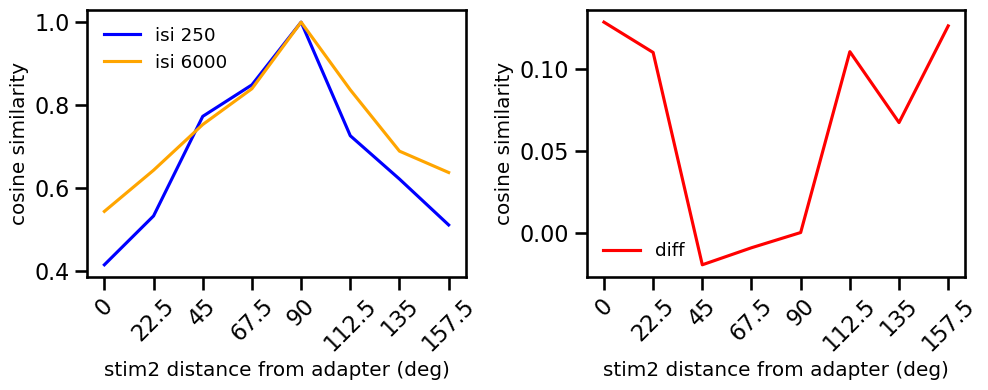

In [399]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

plt.tight_layout()
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = 'decorr_vs_stim2_ori_' + current_area + '.pdf'
plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### decorr vs stim2_distance from adapter

In [400]:
df_pop_vec = (df_decorr.groupby(['isi', 'stim2_dist', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                )
df_pop_vec

cell_id          200723_003_1  200723_003_10  200723_003_11  200723_003_12  \
isi  stim2_dist                                                              
250  0.0            -0.005401       0.007648       0.038531       0.011697   
     22.5           -0.023024      -0.000867      -0.023810       0.011754   
     45.0            0.024292       0.041707       0.053117       0.026700   
     67.5            0.056694       0.028808       0.026334       0.000991   
     90.0            0.119146       0.001094       0.017127       0.011128   
6000 0.0            -0.004944       0.091272      -0.022213       0.043560   
     22.5            0.061388       0.077287       0.013804       0.008354   
     45.0            0.080654       0.044041       0.084670       0.036834   
     67.5            0.092890       0.039130       0.061323       0.046505   
     90.0            0.064168       0.045880       0.047818       0.020374   

cell_id          200723_003_14  200723_003_15  200723_003_16  200723_003_18  \
isi  stim2_dist                                                               
250  0.0             -0.008486       0.046037       0.025867      -0.040432   
     22.5             0.022491       0.005579      -0.012443      -0.002798   
     45.0             0.011929       0.148864      -0.012710       0.029186   
     67.5             0.032174       0.126220       0.074722       0.059094   
     90.0             0.044916       0.150953      -0.004497       0.060277   
6000 0.0              0.068940       0.099363      -0.013935       0.028703   
     22.5             0.060510       0.104815       0.004678       0.070226   
     45.0             0.028009       0.145722       0.044324       0.071636   
     67.5             0.030116       0.120384       0.065932       0.075534   
     90.0             0.058745       0.143208       0.130853       0.042643   

cell_id          200723_003_19  200723_003_2  ...  230309_002_55  \
isi  stim2_dist                               ...                  
250  0.0              0.004073      0.031216  ...      -0.001467   
     22.5            -0.023526      0.033799  ...      -0.011129   
     45.0            -0.002912      0.026555  ...      -0.013328   
     67.5             0.064021      0.067418  ...       0.001677   
     90.0             0.081349      0.046425  ...      -0.004717   
6000 0.0              0.014449      0.108429  ...      -0.006541   
     22.5             0.037758      0.065268  ...      -0.000398   
     45.0             0.055914      0.019857  ...       0.007564   
     67.5             0.130829      0.072907  ...       0.012154   
     90.0             0.100264      0.014833  ...      -0.010514   

cell_id          230309_002_61  230309_002_79  230309_002_84  230309_002_86  \
isi  stim2_dist                                                               
250  0.0              0.012224      -0.008993       0.008518       0.017217   
     22.5             0.025407       0.001705      -0.005959       0.013086   
     45.0             0.024015       0.093804       0.003821       0.005552   
     67.5            -0.007980       0.049488      -0.000241       0.007012   
     90.0             0.004506       0.033759      -0.000547       0.036242   
6000 0.0              0.004988       0.027172       0.037115      -0.017311   
     22.5             0.011596       0.062406      -0.013651       0.007834   
     45.0             0.022510       0.079908       0.008351       0.022070   
     67.5             0.039286       0.046751       0.021350       0.012354   
     90.0             0.012296       0.068001       0.011025       0.037309   

cell_id          230309_002_89  230309_002_90  230309_003_17  230309_003_29  \
isi  stim2_dist                                                               
250  0.0              0.000927       0.000554       0.033249       0.067000   
     22.5             0.008694       0.003971      -0.003427       0.008000   
     45.0             0.023189  

In [401]:
nori = df_decorr.stim2_dist.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

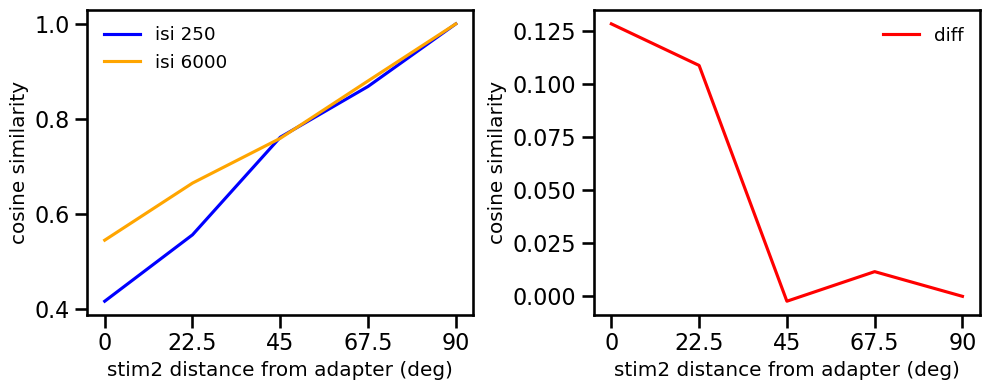

In [402]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

plt.tight_layout()
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = 'decorr_vs_stim2_dist_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# linear SVC decoder
using function sklearn.svm.LinearSVC:  

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

## example

In [491]:
from sklearn.svm import LinearSVC # NOTE: current scikit-learn ver: 1.2.2, not newest, beware with doc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

X, y = make_classification(n_features=4, random_state=0)
X.shape, y.shape, y[:5]

((100, 4), (100,), array([1, 1, 0, 0, 0]))

In [492]:
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)

print(clf.named_steps['linearsvc'].coef_)
print(clf.named_steps['linearsvc'].intercept_)

print(clf.predict([[0, 0, 0, 0]]))

[[0.14144316 0.52678399 0.67978685 0.49307524]]
[0.16935939]
[1]


0.93


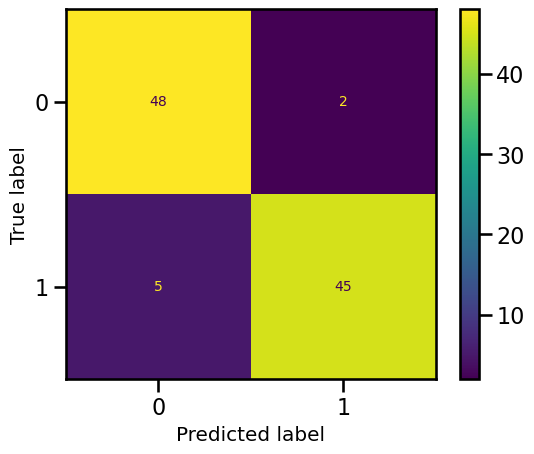

In [490]:
# get accuracy of clf
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print(acc)

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf.predict(X)
cm = confusion_matrix(y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

## decode 90 vs another ori

### filter cell by vis pval

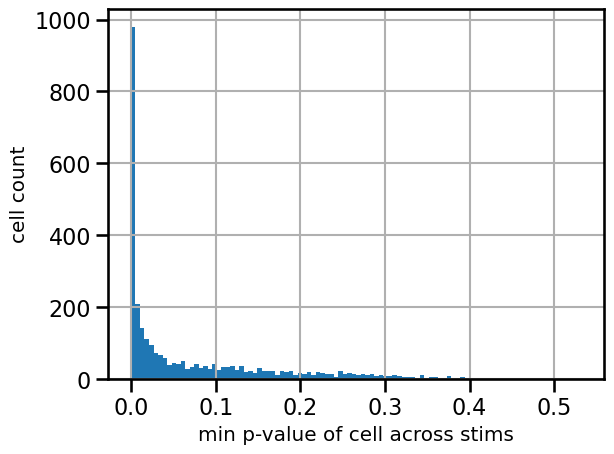

In [10]:
df_tidy.groupby('cell_id').filter_cell_vis_pval.first().hist(bins=100);
# plt.xlim(0, 0.05);
plt.xlabel('min p-value of cell across stims');
plt.ylabel('cell count');

In [578]:
pd.options.mode.chained_assignment = None  # default='warn'

df_svc = df_tidy[['dfof', 
                'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id',
                'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval',
                'area', 'mouse', 'date', 'sess'
                ]]

df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                          # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess

current_area = 'V1' # TODO: area = subplot
current_datesess = df_svc.date_sess.unique()[0] # TODO: date_sess = errorbar

df_svc = df_svc[(df_svc.isi != 750)
                & (df_svc.filter_cell_vis == True)
                & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                & (df_svc.area == current_area)
                & (df_svc.date_sess == current_datesess)
                ]

ncell_keep = 15
vis_pval_thresh = df_svc.groupby('cell_id').first().filter_cell_vis_pval.sort_values()[ncell_keep] # nsample (nrep trial) too small, need to reduce nfeature (ncell)
df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]

df_svc.cell_id.nunique()

15

### filter cell by SNR

In [572]:
def calc_SNR(df_tidy):
    ## SNR of R1, aka (R2 without adapter, isi=6k)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R1 = (tmp.mean() / tmp.std()).reset_index()

    ## SNR of R2, aka (R2 with adapter, isi=250)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R2 = (tmp.mean() / tmp.std()).reset_index()

    ## merge to df
    df_SNR = SNR_R1.merge(SNR_R2, on=['cell_id', 'stim2_id'], suffixes=('_R1', '_R2'))
    df_SNR.columns = ['cell_id', 'stim2_id', 'SNR_R1', 'SNR_R2'] # rename columns
    df_SNR = df_SNR.sort_values(by='SNR_R1', ascending=False)
    return df_SNR

df_SNR = calc_SNR(df_tidy)

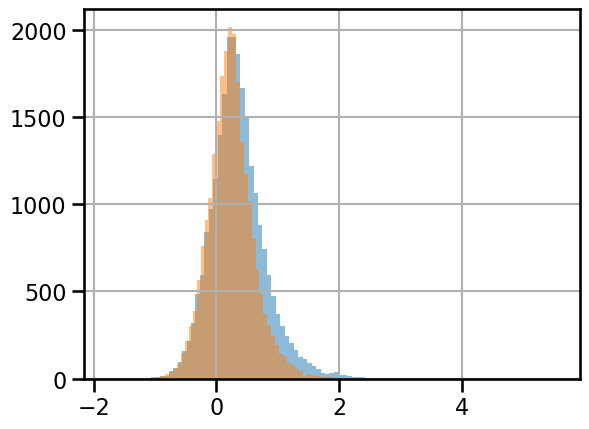

In [573]:
df_SNR.SNR_R1.hist(bins=100, alpha=0.5);
df_SNR.SNR_R2.hist(bins=100, alpha=0.5);

In [579]:
df_SNR

cell_id  stim2_id    SNR_R1    SNR_R2
100  200720_003_22         4  2.395537  1.623944
157  200720_003_32         5  1.708434  1.651759
101  200720_003_22         5  1.381164  0.904497
158  200720_003_32         6  1.304127  0.655797
479   200720_003_9         7  1.280462  0.873405
..             ...       ...       ...       ...
284  200720_003_59         4 -0.366162 -0.175773
289  200720_003_60         1 -0.382599  0.072970
240  200720_003_52         0 -0.411916 -0.292542
203  200720_003_45         3 -0.528744  0.338694
186  200720_003_42         2 -0.598282 -0.001973

[512 rows x 4 columns]

PearsonRResult(statistic=0.6293502025794551, pvalue=0.0)

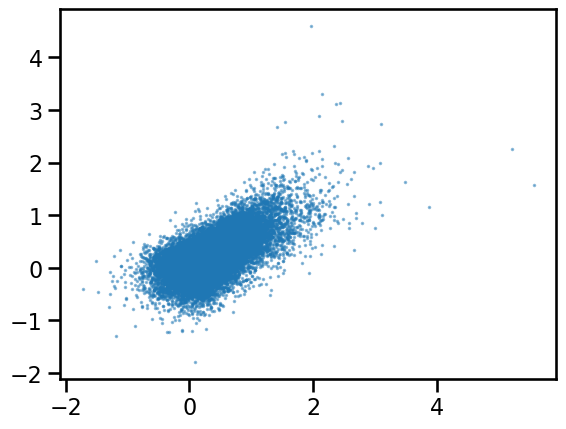

In [574]:
plt.scatter(df_SNR.SNR_R1, df_SNR.SNR_R2, alpha=0.5, s=1);

# correlation
from scipy.stats import pearsonr
pearsonr(df_SNR.SNR_R1, df_SNR.SNR_R2)

array(['210127_003_38', '210127_003_50', '201217_002_58', '200728_003_10',
       '230302_003_79', '210127_002_73', '210127_002_61', '210127_003_56',
       '230302_004_127', '200723_003_22', '230302_003_50',
       '210127_003_55', '201217_004_25', '210127_003_42', '210127_002_66'],
      dtype=object)

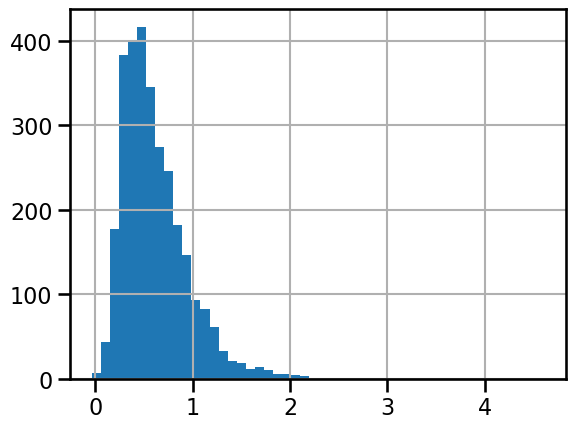

In [575]:
df_SNR.groupby('cell_id').SNR_R2.max().hist(bins=50);
df_SNR.groupby('cell_id').SNR_R2.max().reset_index().sort_values('SNR_R2', ascending=False).head(15).cell_id.values

In [576]:
pd.options.mode.chained_assignment = None  # default='warn'

df_svc = df_tidy[['dfof', 
                'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id',
                'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval',
                'area', 'mouse', 'date', 'sess'
                ]]

df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                          # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess

current_area = 'V1' # TODO: area = subplot
current_datesess = df_svc.date_sess.unique()[0] # TODO: date_sess = errorbar

df_svc = df_svc[(df_svc.isi != 750)
                & (df_svc.filter_cell_vis == True)
                & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                & (df_svc.area == current_area)
                & (df_svc.date_sess == current_datesess)
                ]

ncell_keep = 15
df_SNR = calc_SNR(df_svc)
model_cell_id = (df_SNR.groupby('cell_id')
                 .SNR_R2.max().reset_index()
                 .sort_values('SNR_R2', ascending=False)
                 .head(ncell_keep).cell_id.values
                 )

df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
df_svc.cell_id.nunique()

15

### validate diversity of tuning curves 
neuron in model should have diff tuning

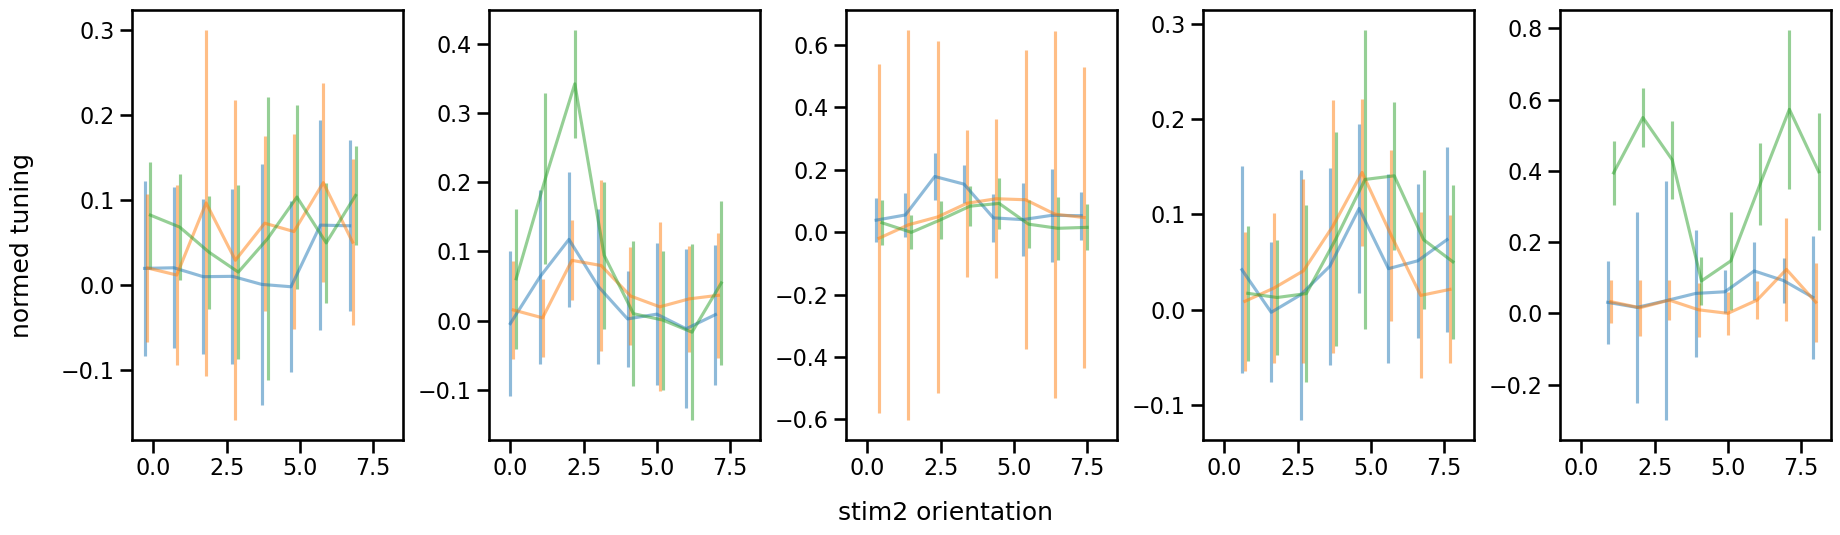

In [577]:
model_cell_resp = df_svc.groupby(['cell_id', 'stim2_id']).dfof.mean().reset_index()
model_cell_std = df_svc.groupby(['cell_id', 'stim2_id']).dfof.std().reset_index()

tuning_pop = []
tuning_pop_std = []
for icell in df_svc.cell_id.unique():
    tuning_cell = model_cell_resp[model_cell_resp.cell_id==icell].dfof.tolist()
    tuning_cell_std = model_cell_std[model_cell_std.cell_id==icell].dfof.tolist()
    
    # tuning_cell = (tuning_cell - np.min(tuning_cell)) / (np.max(tuning_cell) - np.min(tuning_cell)) # min-max normalization
    tuning_pop.append(tuning_cell)
    tuning_pop_std.append(tuning_cell_std)

len(tuning_pop), len(tuning_pop[0]) # ncell_keep, nori
tuning_pop = np.array(tuning_pop)
tuning_pop_std = np.array(tuning_pop_std)
tuning_pop = tuning_pop[np.argsort(np.argmax(tuning_pop, axis=1)), :] # sort cells by tuning argmax
tuning_pop_std = tuning_pop_std[np.argsort(np.argmax(tuning_pop, axis=1)), :]

nsubplot = 5
# fig, ax = plt.subplots(1, nsubplot, figsize=(18, 5), sharex=True, sharey=True)
fig, ax = plt.subplots(1, nsubplot, figsize=(18, 5), sharex=True)
ncell_subplot = ncell_keep // nsubplot

for isubplot in np.arange(nsubplot):
    for icell in np.arange(ncell_subplot*(isubplot-1), ncell_subplot*isubplot):
        ax[isubplot].errorbar(x=np.arange(8) + icell*0.1, 
                              y=tuning_pop[icell], 
                              yerr=tuning_pop_std[icell], 
                              alpha=0.5)
        
fig.text(0.5, -0.05, 'stim2 orientation', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'normed tuning', va='center', rotation='vertical', fontsize=18)
# fig.text(-0.02, 0.5, 'tuning', va='center', rotation='vertical', fontsize=18)

fig.tight_layout()
# fig.savefig(dir_fig + 'tuning_of_model_cells_no_norm.pdf', bbox_inches='tight')

In [402]:
def df_to_train_test(df):
    # input: filtered df_svc
    # output: X_train, X_test, y_train, y_test (of the filter condition)
    
    label_arr = df.groupby('trial_id').stim2_dist.first().values
    label_arr = (label_arr == 90) # 1 = 90 deg, 0 = other ori
    
    feature_mat = (df
                   .pivot_table(index=['trial_id'], columns='cell_id', values='dfof')
                   .fillna(0).to_numpy())
    
    assert feature_mat.shape[0] == label_arr.shape[0]
    # print(label_arr.shape) # ntrial
    # print(feature_mat.shape) # ntrial x ncell
    
    X_train, X_test, y_train, y_test = train_test_split(
        feature_mat, label_arr, test_size=int(1), # 1 trial for test. do not differentiate val/test now
        random_state=0, shuffle=True) 
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # ntrial x ncell
    
    return X_train, X_test, y_train, y_test

### try

In [88]:
acc_train_250_arr = []
acc_train_6000_arr = []
acc_test_250_arr = []
acc_test_6000_arr = []

# other_dist = sorted(df_svc.stim2_dist.unique())[:-1][::-1] # [0, 22, 45, 67] -> [67.5, 45.0, 22.5, 0.0]
tmp = df_svc.stim2_id.unique()
other_ori = sorted(tmp[tmp != 4])

# for idist in other_dist: # exclude 90 deg
for iori in other_ori: # exclude 90 deg
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))] # 90 deg vs another ori
    
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]
    
    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)
    
    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    
    ## shuffle trials in the same way
    np.random.seed(42)
    np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    np.random.shuffle(y_train)
    
    ## fit train (merge isi)
    clf = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=42, tol=1e-5, max_iter=100000, 
                                  penalty='l1', dual=False, C=0.1))
    clf.fit(X_train, y_train)
    
    ## predict test (separate isi)
    # y_pred_train_250 = clf.predict(X_train_250)
    # y_pred_train_6000 = clf.predict(X_train_6000)
    # y_pred_test_250 = clf.predict(X_test_250)
    # y_pred_test_6000 = clf.predict(X_test_6000)
    
    acc_train_250 = clf.score(X_train_250, y_train_250)
    acc_train_6000 = clf.score(X_train_6000, y_train_6000)
    acc_test_250 = clf.score(X_test_250, y_test_250)
    acc_test_6000 = clf.score(X_test_6000, y_test_6000)
    
    acc_train_250_arr.append(acc_train_250)
    acc_train_6000_arr.append(acc_train_6000)
    acc_test_250_arr.append(acc_test_250)
    acc_test_6000_arr.append(acc_test_6000)
    
    # ## confusion matrix
    # cm_train = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
    # cm_test_250 = confusion_matrix(y_test_250, y_pred_250, labels=clf.classes_)
    # cm_test_6000 = confusion_matrix(y_test_6000, y_pred_6000, labels=clf.classes_)
    
    # break
    
X_train.shape, y_train.shape, #X_test_250.shape, y_test_250.shape, X_test_6000.shape, y_test_6000.shape
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_6000,
#                               display_labels=clf.classes_)
# disp.plot()
# plt.show()

((61, 15), (61,))

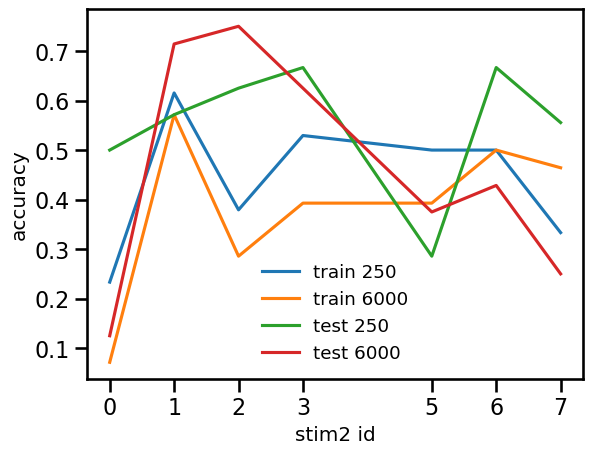

In [89]:
x = other_ori
plt.plot(x, acc_train_250_arr, label='train 250')
plt.plot(x, acc_train_6000_arr, label='train 6000')
plt.plot(x, acc_test_250_arr, label='test 250')
plt.plot(x, acc_test_6000_arr, label='test 6000')

plt.legend(frameon=False);
plt.xticks(x);
plt.xlabel('stim2 id');
plt.ylabel('accuracy');

In [36]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn import svm

# X, y = datasets.load_iris(return_X_y=True)
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=10)
print(scores)
clf.set_params(linearsvc__C=0.001)
clf.get_params()['linearsvc__C']

[0.55555556 0.44444444 0.22222222 0.66666667 0.44444444 0.66666667
 0.55555556 0.55555556 0.55555556 0.5       ]


0.001

In [38]:
from sklearn.model_selection import cross_validate
# from sklearn.metrics import recall_score

# scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X_train, y_train, cv=5,
                        # scoring=scoring, 
                        return_train_score=True)
scores['test_score'], scores['train_score']

(array([0.66666667, 0.66666667, 0.61111111, 0.61111111, 0.64705882]),
 array([0.63380282, 0.63380282, 0.64788732, 0.64788732, 0.63888889]))

In [239]:
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


## cross val to search reg param

### aware decoder

two separate models for two isi.  
one model: train and test with isi=6k  
another model: train and test with isi=250  

100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


isi=6k


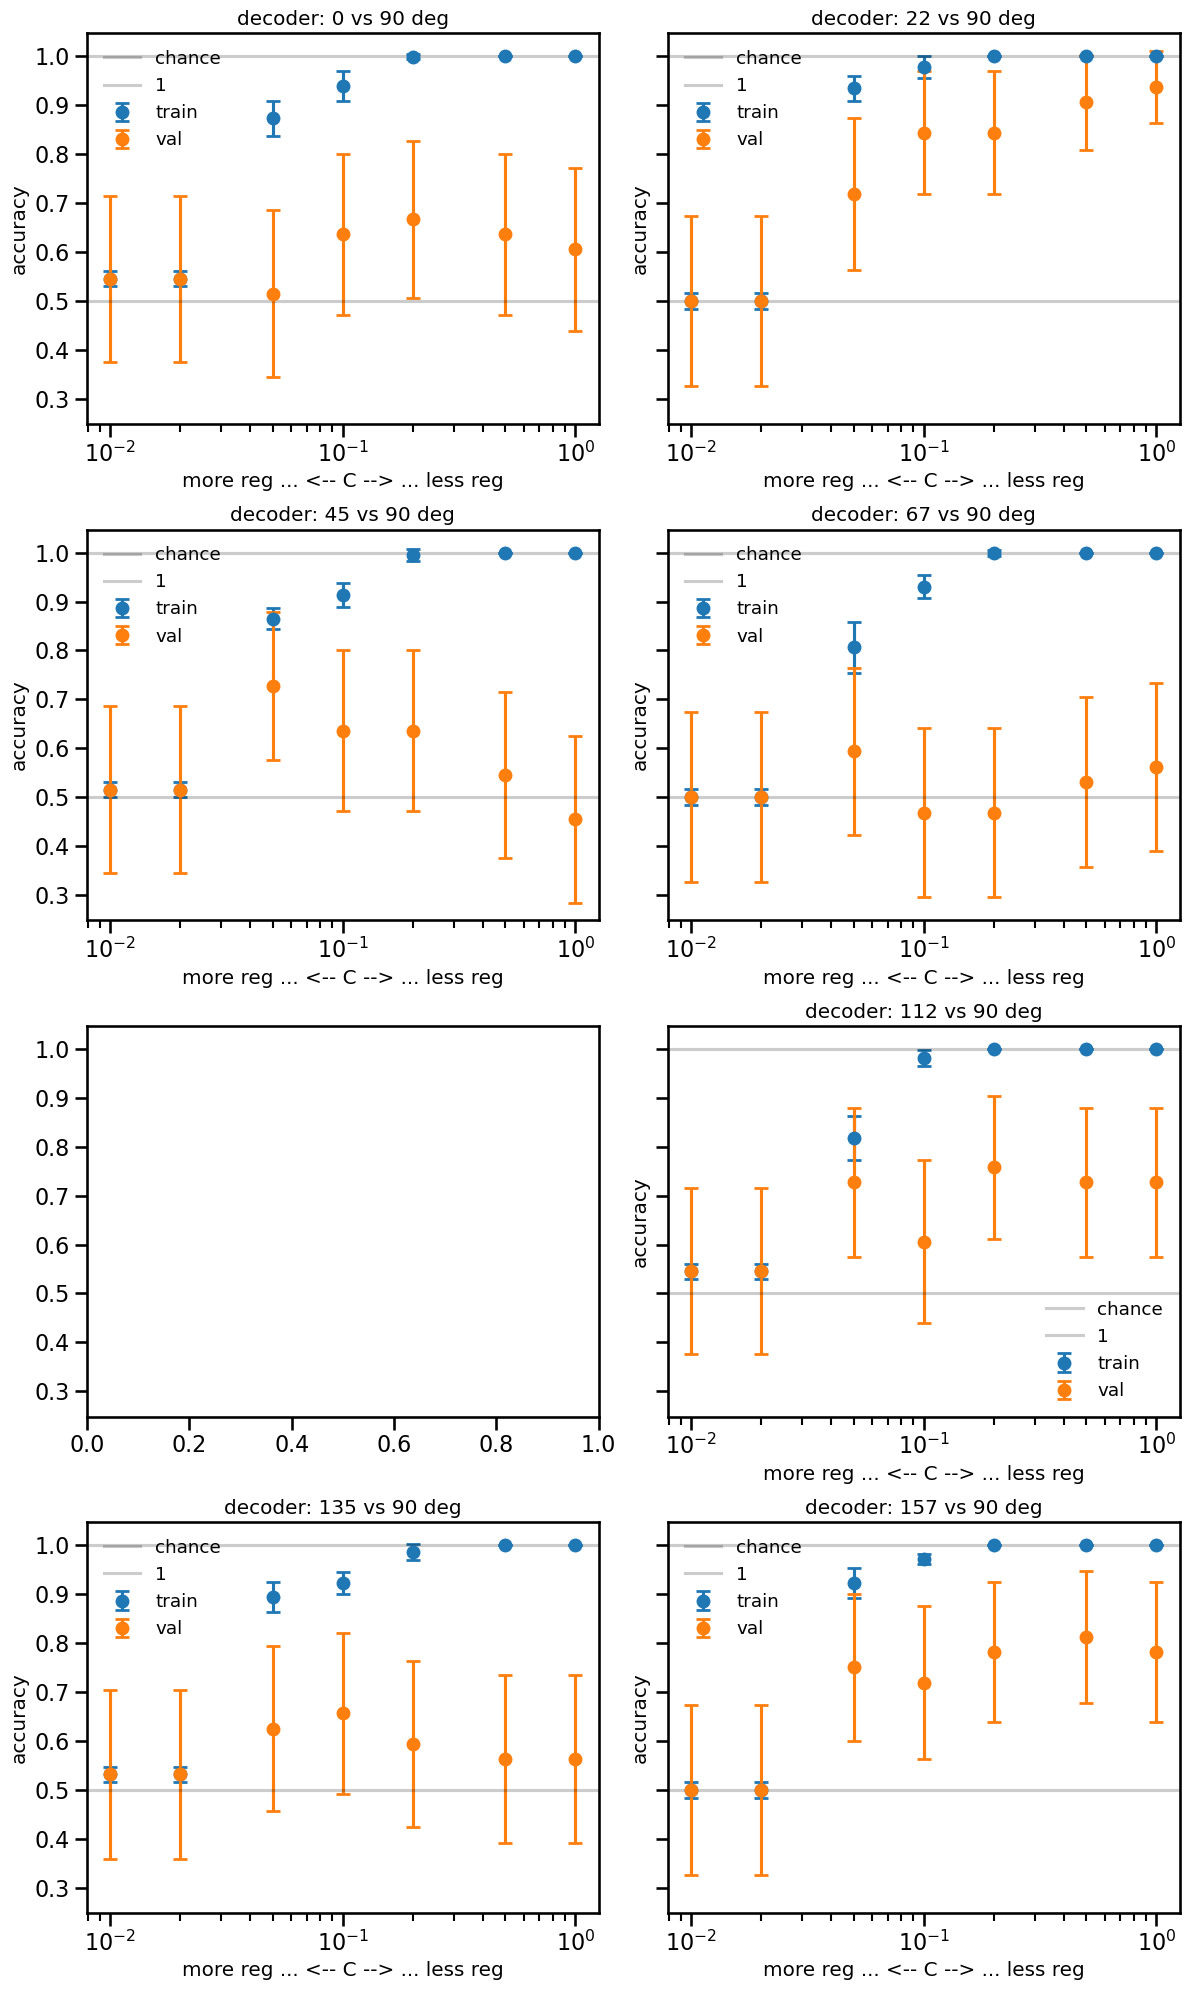

In [560]:
## find optimal reg param C. 

df_svc = get_df_svc(df_tidy, iarea='V1', idatesess=4, ncell_keep=999)

# use_data = 'isi_both'
# use_data = 'isi=250' # adapted
use_data = 'isi=6k' # unadapted

nrow = 4
ncol = 2
cross_val_method = LeaveOneOut()
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
for iori in tqdm(other_ori):
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    X_test = np.vstack((X_test_250, X_test_6000))
    y_test = np.hstack((y_test_250, y_test_6000))

    ## shuffle trials in the same way
    seed_val = 0
    np.random.seed(seed_val)
    np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    np.random.shuffle(y_train)
    np.random.shuffle(X_test)
    np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))
        
        if use_data == 'isi_both':
            score_val = cross_validate(clf, X_train, y_train, cv=cross_val_method, return_train_score=True) # instead of cv=nfold, we use leave-one-out
            clf.fit(X_train, y_train)
            score_test = clf.score(X_test, y_test)
        elif use_data == 'isi=250':
            score_val = cross_validate(clf, X_train_250, y_train_250, cv=cross_val_method, return_train_score=True)
            clf.fit(X_train_250, y_train_250)
            score_test = clf.score(X_test_250, y_test_250)
        elif use_data == 'isi=6k':
            score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=cross_val_method, return_train_score=True)
            clf.fit(X_train_6000, y_train_6000)
            score_test = clf.score(X_test_6000, y_test_6000)
        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)
        acc_test.append(score_test)
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
    # ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')
    ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k',alpha=0.2, label='1')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()
print(use_data)

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
# fig.savefig(dir_fig + f'aware_decoder_L1_{use_data}_all_cell.pdf', bbox_inches='tight')

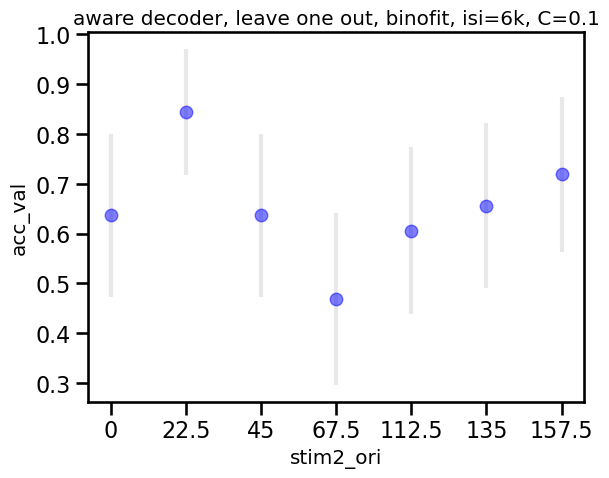

In [564]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc_val');

title_str = f'aware decoder, leave one out, binofit, {use_data}, C={fix_C}'
plt.title(title_str);
# plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

### naive unaware decoder
train with 6k, test with either - more directly related to decorr, give lower bound of decoding acc

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


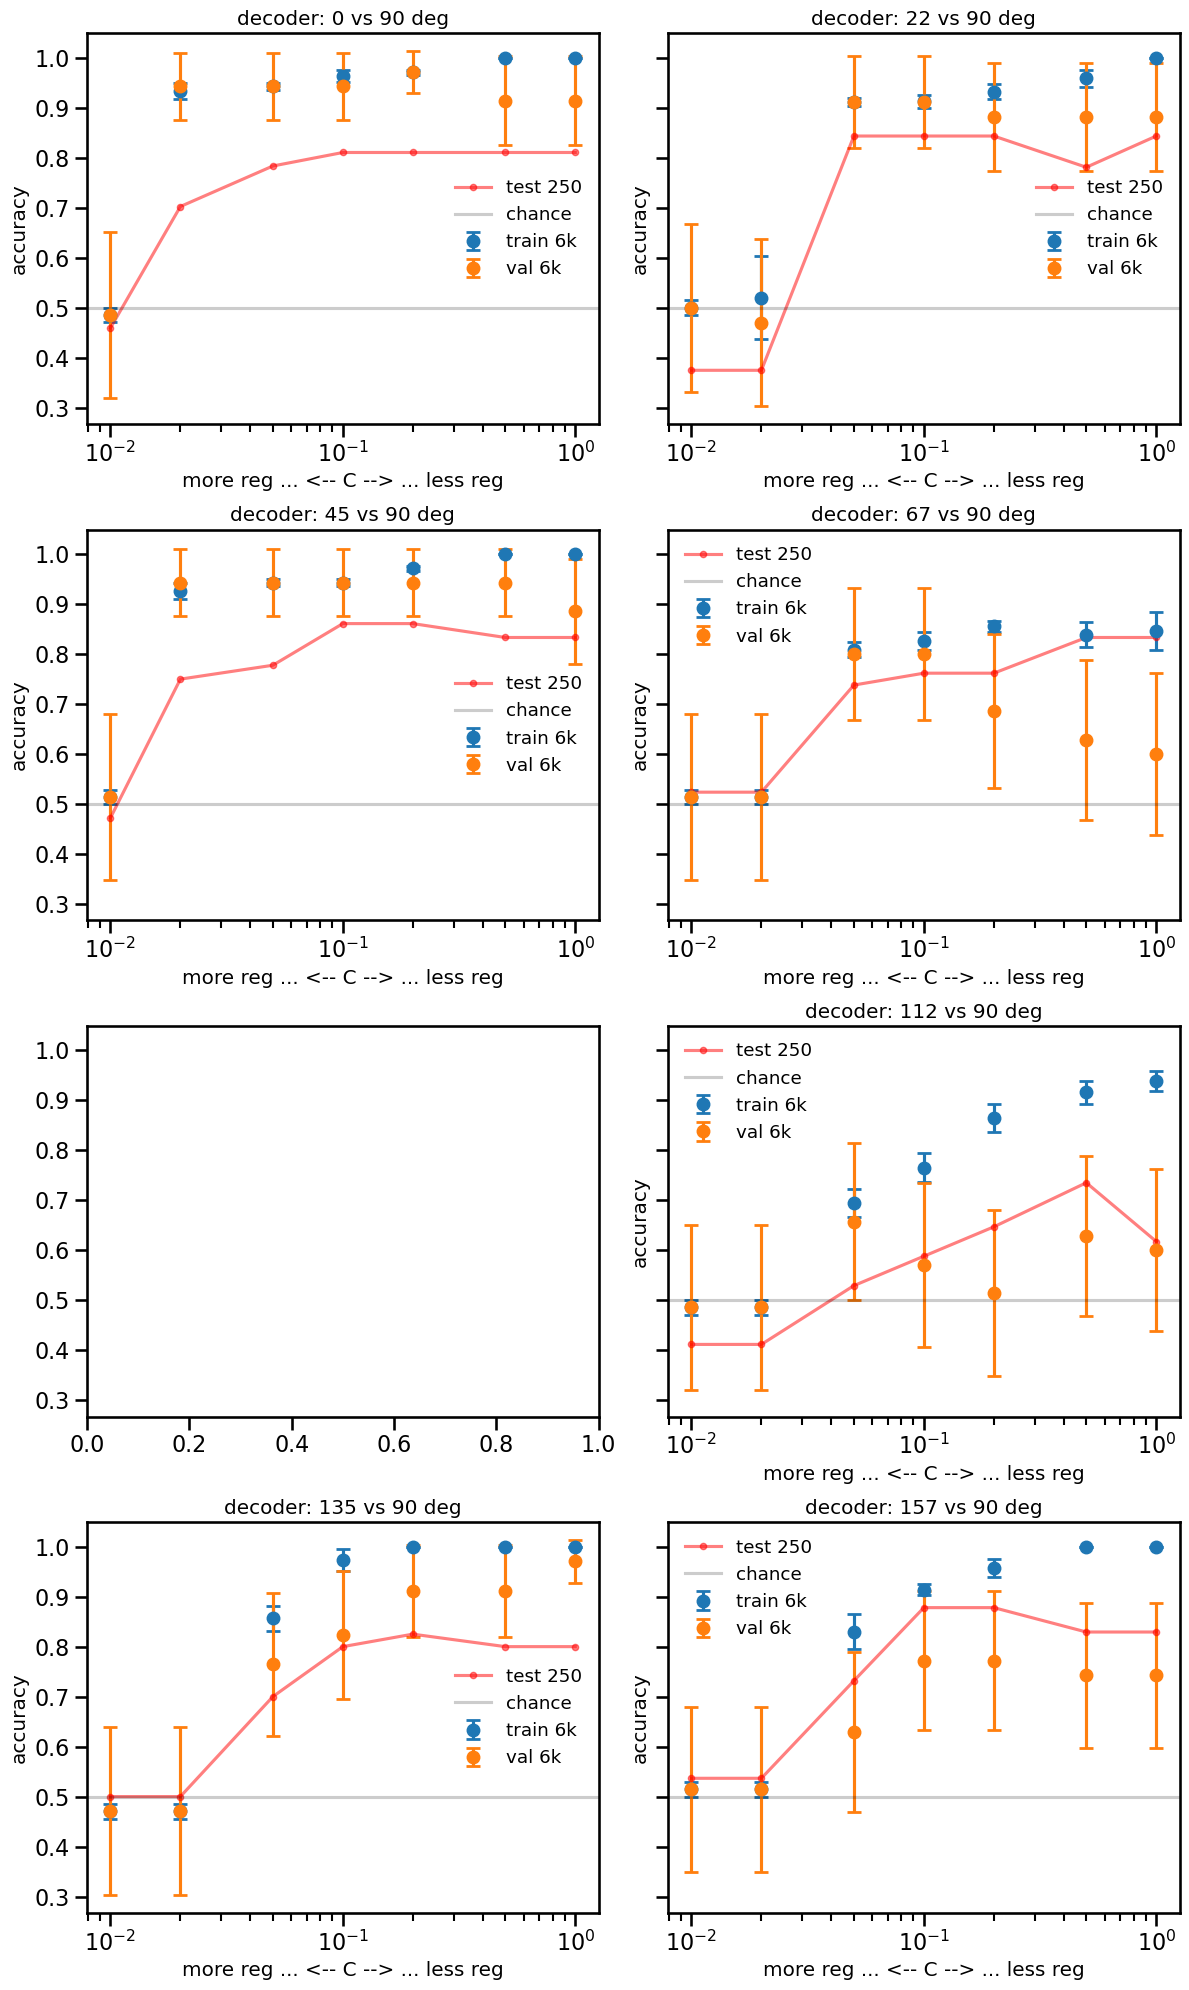

In [289]:
## find optimal reg param C. 

nrow = 4
ncol = 2
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
acc_test_iori = []

for iori in tqdm(other_ori):
    
    ## get data for each pair of ori (another vs 90 deg)
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    # ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    # X_train = np.vstack((X_train_250, X_train_6000))
    # y_train = np.hstack((y_train_250, y_train_6000))
    # X_test = np.vstack((X_test_250, X_test_6000))
    # y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    # use_data = 'isi=250' # train with unadapted, test with adapted
    # use_data = 'isi=6k' # train with unadapted, test with unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))

        ## train and val with isi 6k. val is considered as test
        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)

        ## test with isi 250. train_250 is considered as test (bc model is trained with isi 6k)
        clf.fit(X_train_6000, y_train_6000)
        score_test = clf.score(X_train_250, y_train_250) # test data has only 1 trial. use train as test for isi 250
        acc_test.append(score_test)
        
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
    acc_test_iori.append(acc_test)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train 6k')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val 6k')
    ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test 250')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_train_val_6k_test_250.pdf', bbox_inches='tight')

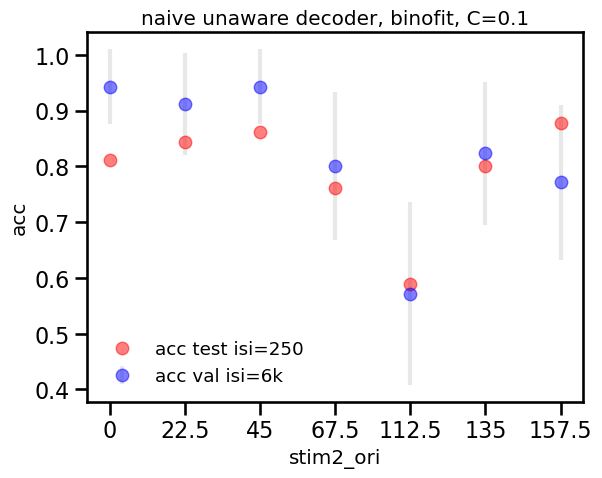

In [294]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_test_C = np.array(acc_test_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             label='acc val isi=6k',
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);
plt.plot(acc_test_C, 'o', color='r', alpha=0.5, label='acc test isi=250')

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc');
plt.legend(frameon=False, loc='lower left')

title_str = f'naive unaware decoder, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

### experienced unaware decoder
train with both, test with either - assume decoder learned from visual xp

100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


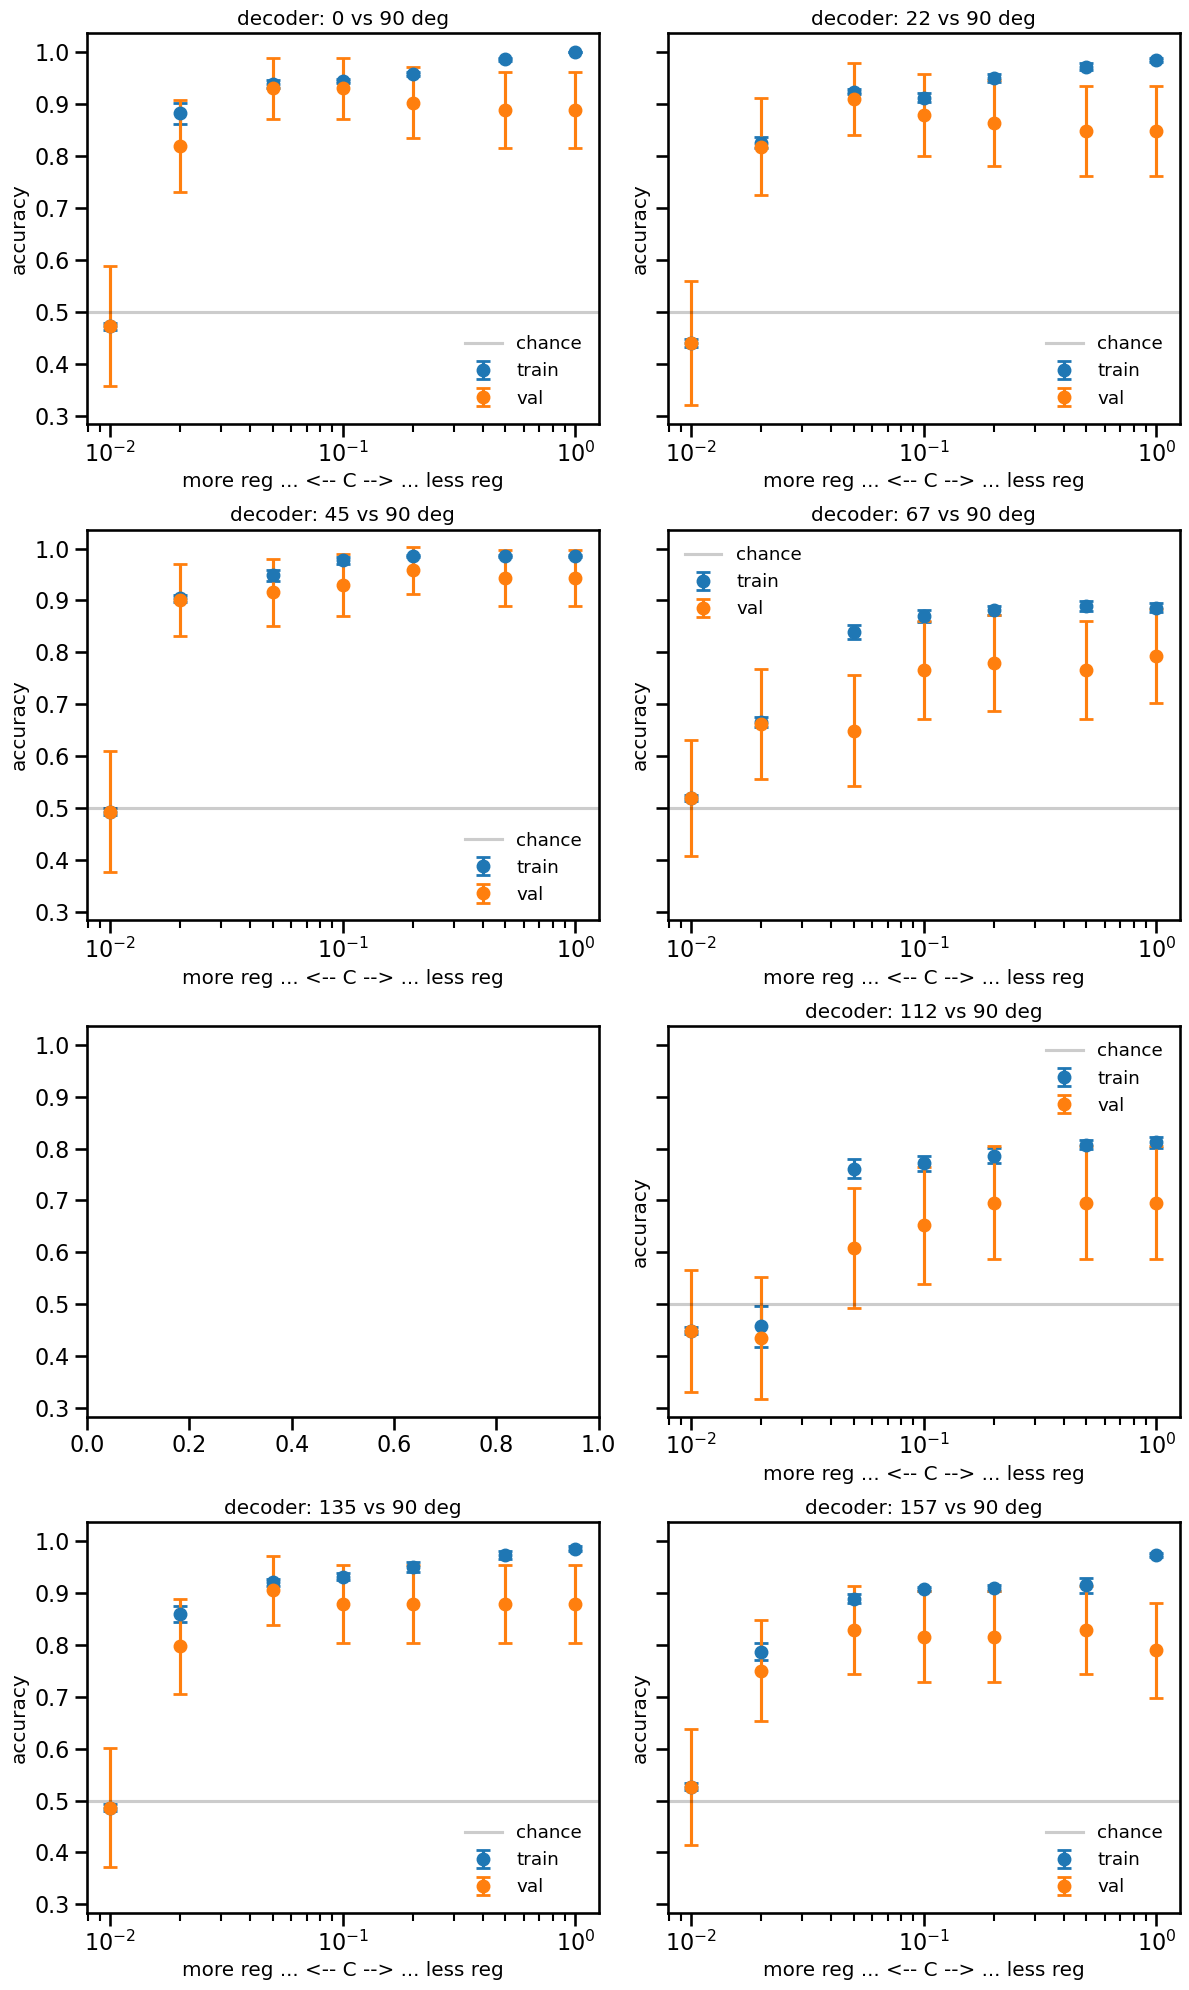

In [297]:
## find optimal reg param C. 

nrow = 4
ncol = 2
cross_val_method = LeaveOneOut()
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
for iori in tqdm(other_ori):
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    X_test = np.vstack((X_test_250, X_test_6000))
    y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    use_data = 'isi_both'
    # use_data = 'isi=250' # adapted
    # use_data = 'isi=6k' # unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))
        
        if use_data == 'isi_both':
            score_val = cross_validate(clf, X_train, y_train, cv=cross_val_method, return_train_score=True) # instead of cv=nfold, use leave-one-out
        #     clf.fit(X_train, y_train)
        #     score_test = clf.score(X_test, y_test)
        # elif use_data == 'isi=250':
        #     score_val = cross_validate(clf, X_train_250, y_train_250, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_250, y_train_250)
        #     score_test = clf.score(X_test_250, y_test_250)
        # elif use_data == 'isi=6k':
        #     score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_6000, y_train_6000)
        #     score_test = clf.score(X_test_6000, y_test_6000)
        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)
        # acc_test.append(score_test)
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
    # ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_leave1out.pdf', bbox_inches='tight')

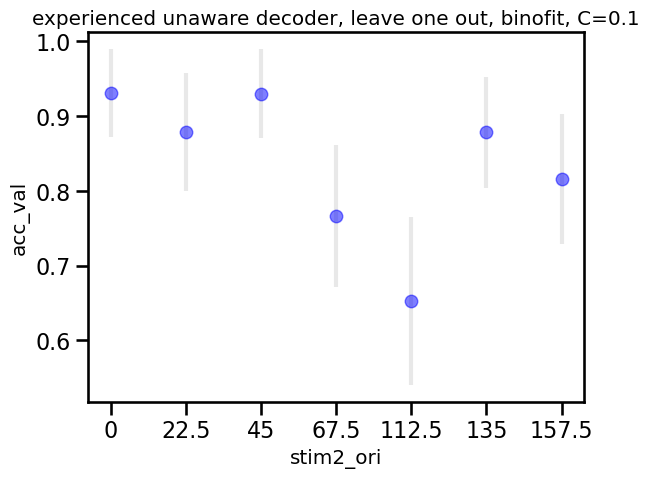

In [298]:
fix_C = 0.1
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc_val');

title_str = f'experienced unaware decoder, leave one out, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

# expand
area subplot, isi color, date_sess errorbar  
fix C=0.1

In [504]:
# pd.options.mode.chained_assignment = None  # default='warn'

def get_df_svc(df_tidy, iarea, idatesess, ncell_keep=15):
    df_svc = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id',
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval',
                    'area', 'mouse', 'date', 'sess'
                    ]]

    df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess
    
    df_svc = df_svc[(df_svc.isi != 750)
                    & (df_svc.filter_cell_vis == True)
                    & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                    & (df_svc.area == iarea)
                    ]
    date_sess_now = df_svc.date_sess.unique()[idatesess] # sess id in a specific area
    df_svc = df_svc[df_svc.date_sess == date_sess_now]

    if df_svc.cell_id.nunique() > ncell_keep:
        vis_pval_thresh = (df_svc.groupby('cell_id').first()
                        .filter_cell_vis_pval.sort_values() # ascending, smaller pval better
                        [ncell_keep]) # nsample (nrep trial) too small, need to reduce nfeature (ncell)
        df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]
        
    return df_svc

In [556]:
iarea = 'LI'

true_pos_isi = []
n_sample_isi = []
for use_data in ['isi=250', 'isi=6k']:

    true_pos_ori = np.zeros(len(other_ori) + 1) # true positive across ori pairs. leave a blank for stim2_id=4 (90 deg)
    n_sample_ori = np.zeros(len(other_ori) + 1)

    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                           & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                .groupby(['date', 'sess'])
                .first().__len__())

    for isess in tqdm(range(nsess_iarea)):
        del df_svc
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, ncell_keep=999)

        for iori in (other_ori):
            
            df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
            df_pair_250 = df_pair[df_pair.isi == 250]
            df_pair_6000 = df_pair[df_pair.isi == 6000]

            X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
            X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)


            clf = make_pipeline(StandardScaler(),
                                LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                        penalty='l1', dual=False, C=0.1))

            if use_data == 'isi=250':
                score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
            elif use_data == 'isi=6k':
                score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            true_pos = score_val['test_score'].sum()
            n_sample = len(score_val['test_score'])
            true_pos_ori[iori] += true_pos
            n_sample_ori[iori] += n_sample
    
    true_pos_isi.append(true_pos_ori)
    n_sample_isi.append(n_sample_ori)

100%|██████████| 15/15 [01:02<00:00,  4.18s/it]


In [557]:
# decode_res_V1 = [true_pos_isi, n_sample_isi]
# decode_res_LM = [true_pos_isi, n_sample_isi]
# decode_res_LI = [true_pos_isi, n_sample_isi]

# grat8_decode_all_cells = {'decode_res_V1': decode_res_V1,
#                     'decode_res_LM': decode_res_LM,
#                     'decode_res_LI': decode_res_LI}
# import pickle
# with open(dir_fig + 'grat8_decode_all_cells.pickle', 'wb') as f:
#     pickle.dump(grat8_decode_all_cells, f)


# iarea = 'LM'
# true_pos_isi, n_sample_isi = decode_res_LM

## plot

In [558]:
# suppress RuntimeWarning: invalid value encountered in true_divide
import warnings
warnings.filterwarnings('ignore')

isi_list = ['isi=250', 'isi=6k']
nisi = len(isi_list)
for iisi in range(nisi):

    ci_low, ci_high = proportion_confint(count=true_pos_isi[iisi], 
                                         nobs=n_sample_isi[iisi])
    ci_err = (ci_high - ci_low)/2
    
    plt.errorbar(x=np.arange(8) + iisi*0.1, 
                y=true_pos_isi[iisi] / n_sample_isi[iisi], 
                yerr=ci_err, 
                label=isi_list[iisi], fmt='o', alpha=0.5);

plt.axvline(x=4, color='gray', linestyle='-');
plt.ylim(0, 1);
plt.legend(frameon=False, loc='lower left');
plt.title(iarea);